# ----------------------------------------------------------------------
# Mutex Runs
# ----------------------------------------------------------------------


Mutex is a software package for finding mutual exclusivity and co-occurrence in cancer genes.

__To disregard the FDR and filtering method__, set:
1. leastPatientThreshold to 100
2. test_gene_threshold to 0
3. mpairPercntile to 100
4. cpairPercentile to 100

# ----------------------------------------------------------------------
# BRCA WUSTL SEGMENT only loss RUNS
# ----------------------------------------------------------------------

# Set parameters

In [1]:
mutationmatrix = '/Users/jlu96/maf/new/BRCA_wustl/BRCA_wustl-seg-jl.m2'
# Set to name of tab-delimited matrix file. First column of each row should be Patient ID. Remaining row entries are names of present mutations

patientFile = '/Users/jlu96/maf/new/BRCA_wustl/shared_patients.plst'
# Text file with patient names. Set to None to use all the patients.


output_prefix =  "output/BRCA_wustl-seg-jl-"
# Prefix for the following output filenames:
pairfile = output_prefix + 'pairs-min_cohort.txt' #Pair statistics within the least mutated patients
new_pairfile = output_prefix + "-pairs-min_cohort_filtered.txt" #Pair statistics over all patients
new_cpairfile = output_prefix + "-cpairs-min_cohort_filtered.txt" #Co-occurringPair statistics over all patients
new_mpairfile = output_prefix + "-mpairs-min_cohort_filtered.txt"#Mutually exclusive Pair statistics over all patients
triplet_output_prefix = output_prefix + '-triplets-'
segment_info_file = output_prefix + "segment_info_som.txt" # Name of file to write segmentation information to
network_c_file = new_cpairfile[:-4] + "_network.txt"
network_m_file = new_mpairfile[:-4] + "_network.txt"



leastPatientThreshold = 15
# To choose which genes to test, first consider only the patients below this percentile. e.g. if set to 50, the bottom 50% of patients
# are called least mutated.

test_gene_threshold = 10
# Test genes that are mutated in at least this percentage of the least mutated patients.


geneFile = None
# Only load genes listed in this file

minFreq = 0
# Minimum gene mutation frequency


closer_than_distance = 100000000
# Minimum distance between genes to test them, in bp.

cpvaluethreshold = 0.05
# FDR threshold for c-pvalues.

mpvaluethreshold = 0.05
# FDR threshold for mutually exclusive pairs.


# 1) Plot the distribution of mutations across genes and across patients
# 2) Plot distribution over the least mutated patients
# 3) Generate the gene pairs to be tested

A good rule of thumb is to 

1921 genes x 953 patients
*******************************************************************
*                   PLOT MUTATION DISTRIBUTIONS                   *
*******************************************************************
GENE MUTATION DISTRIBUTION


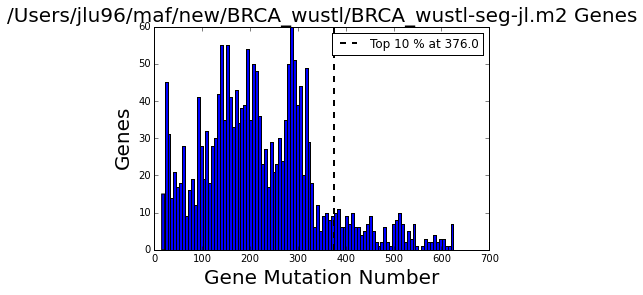

Zoomed into bottom 95 percent region


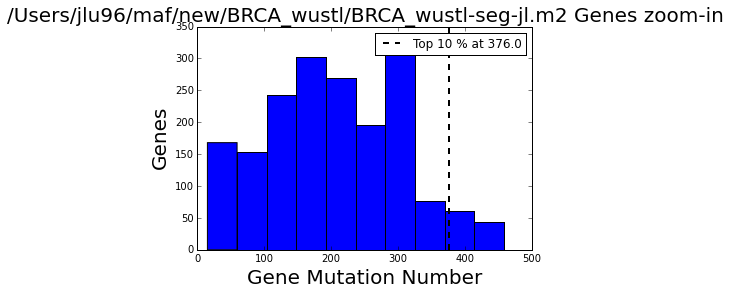


PATIENT MUTATION DISTRIBUTION


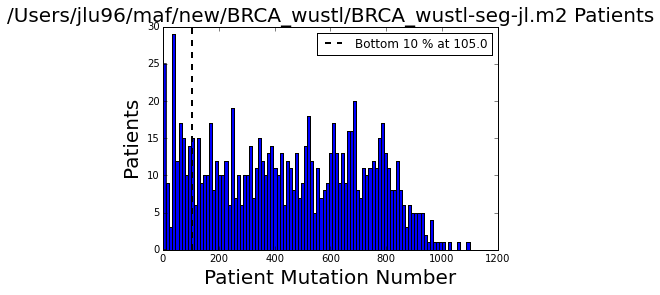

Zoomed into bottom 95 percent region


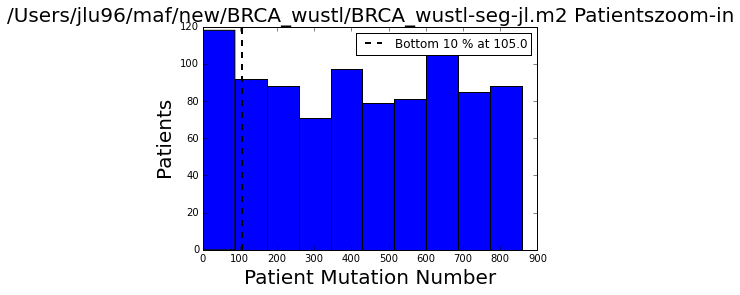

*******************************************************************
*         PLOT DISTRIBUTIONS AMONG LEAST MUTATED PATIENTS         *
*******************************************************************
GENE MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS


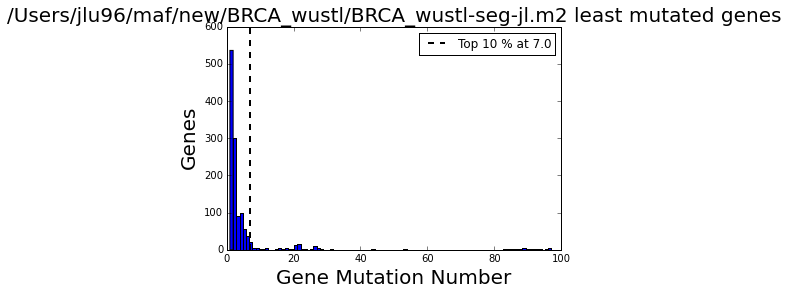


PATIENT MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS


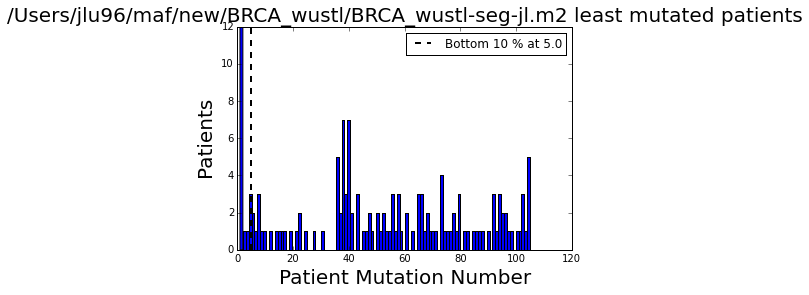

*******************************************************************
*                   GETTING TEST GENE PAIRS                       *
*******************************************************************
The least mutated patients are the bottom  15  % of patients
Least mutated patients: 1267 genes x 145 patients
The test gene threshold is  10 % of the least mutated patients
Test genes are mutated at least  14  in th least mutated patients
Number of test genes:  106
Number of pairs to test:  4030
Number of pairs is  4030  retrieved in time :  6.14459896088


0

In [2]:
import mutex as mex
import csv
import mutex_triangles as met
import chisquared as chi
import bingenesbypairs as bgbp
import time
import os
import scipy.stats as stats
import partition as par
import numpy as np
%matplotlib inline

COSMIC_pair_insertion_index = 8
COSMIC_triplet_insertion_index = 5
compute_mutex = True

numGenes, numCases, genes, patients, geneToCases, patientToGenes = mex.load_mutation_data(mutationmatrix, patientFile, geneFile, minFreq)

print '%s genes x %s patients' % (numGenes, numCases)


print "*******************************************************************"
print "*                   PLOT MUTATION DISTRIBUTIONS                   *"
print "*******************************************************************"

print "GENE MUTATION DISTRIBUTION"
mex.graph_mutation_distribution(numCases, genes, geneToCases, filename=mutationmatrix + " Genes", bins=100, zoomin_percentile=95)


print "\nPATIENT MUTATION DISTRIBUTION"
mex.graph_patient_distribution(len(genes), patients, patientToGenes, mutationmatrix + " Patients", bottom_percentile=leastPatientThreshold, zoomin_percentile=95)


print "*******************************************************************"
print "*         PLOT DISTRIBUTIONS AMONG LEAST MUTATED PATIENTS         *"
print "*******************************************************************"




D = [len(patientToGenes[p]) for p in patientToGenes]
minThreshold = stats.scoreatpercentile(D, leastPatientThreshold)

c0patients = [p for p in patientToGenes if len(patientToGenes[p]) <= minThreshold]

c0cohort_dict = {0: c0patients}

c0genes, c0geneToCases, c0patientToGenes = par.get_cluster_gTC_pTG(geneToCases, patientToGenes, c0patients)

print "GENE MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS"
mex.graph_mutation_distribution(len(c0patients), c0genes, c0geneToCases, filename=mutationmatrix + " least mutated genes", bins=100)

print "\nPATIENT MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS"
mex.graph_patient_distribution(len(genes), c0patients, c0patientToGenes, filename=mutationmatrix + " least mutated patients")



print "*******************************************************************"
print "*                   GETTING TEST GENE PAIRS                       *"
print "*******************************************************************"
print "The least mutated patients are the bottom ", leastPatientThreshold, " % of patients"
print "Least mutated patients: %s genes x %s patients" % (len(c0genes), len(c0patients) )


test_minFreq = int( test_gene_threshold * 0.01 * len(c0patients))
print "The test gene threshold is ", test_gene_threshold, "% of the least mutated patients"
print "Test genes are mutated at least ", test_minFreq, " in th least mutated patients"

print "Number of test genes: ", len([g for g in c0genes if len(c0geneToCases[g]) >= test_minFreq])


reload(bgbp)
t = time.time()
genepairs = bgbp.getgenepairs(c0geneToCases, c0genes, test_minFreq=test_minFreq, closer_than_distance=closer_than_distance)
print "Number of pairs is ", len(genepairs), " retrieved in time : ", time.time() - t

os.system('say "exploration finished"')

## Perform statistical tests of each of the pairs
### This cell's runtime is usually about (number of pairs)/ 900 seconds.

In [3]:
print "Getting normal statistics..."
t = time.time()
pairsdict, genedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, genepairs, compute_mutex=compute_mutex)
print "Finished in ", time.time() - t

print "Testing among least mutated patients..."
t = time.time()
pairsdict = chi.add_BinomP_cohorts_all_pairs(pairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)
print "Finished in ", time.time() - t
print "All pairs tested in least mutated patients written to ",  pairfile

fieldnames = (pairsdict.values()[0]).keys()
fieldnames.remove('MutationFrequencies')
fieldnames.remove('MutationFrequencyDifference')
fieldnames.remove('MutationFrequencyDifferenceRatio')
fieldnames.remove('CooccurrenceRatio')
fieldnames.remove('Coverage')
fieldnames.remove('SetScore')
fieldnames.remove('AverageOverlapPMN')
fieldnames.remove('CombinedScore')
fieldnames.remove('Concordance')
fieldnames.remove('Somatic')
fieldnames.remove('RoundedLogPCov')
fieldnames.remove('GeneSet')
fieldnames.remove('Type')


fieldnames.insert(2, 'Type')
fieldnames.insert(3, '1CBinomProb0')
fieldnames.insert(3, '1MBinomProb0')

met.writeanydict(pairsdict, pairfile, fieldnames=fieldnames)
print "Pairs in least mutated patients finished"
os.system('say "Pairs in least mutated patients finished"')



Getting normal statistics...
Finished in  7.54648208618
Testing among least mutated patients...
Finished in  5.00816679001
All pairs tested in least mutated patients written to  output/BRCA_wustl-seg-jl-pairs-min_cohort.txt
Pairs in least mutated patients finished


0

# Plot the distribution of p-values.

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


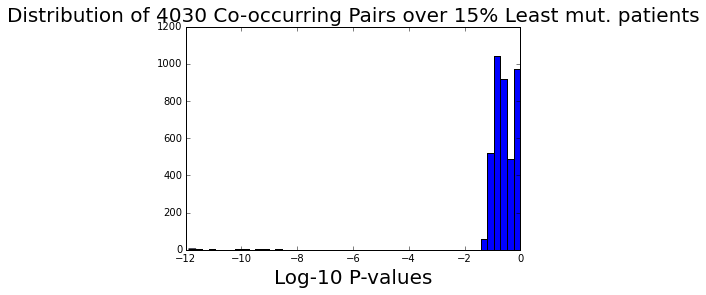

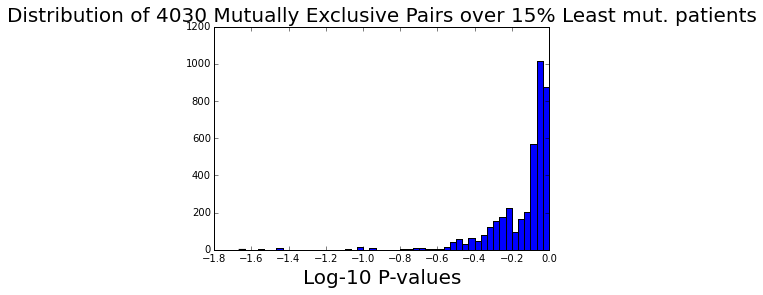

In [4]:
import matplotlib.pyplot as plt

%matplotlib inline
cpvalues = np.array([pairsdict[c]['1CBinomProb0'] for c in pairsdict])
logcp = np.log10(cpvalues)
mpvalues = np.array([pairsdict[c]['1MBinomProb0'] for c in pairsdict])
logmp = np.log10(mpvalues)


plt.figure()
plt.hist(logcp, bins=50)
plt.title("Distribution of " + str(len(logcp)) + " Co-occurring Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()

plt.figure()
plt.hist(logmp, bins=50)
plt.title("Distribution of " + str(len(logmp))  + " Mutually Exclusive Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()

# Set the cutoff of significant pairs to test over the whole distribution

In [5]:
cpairPercentile = 10
# Percentile of most significant co-occurring pairs to test

mpairPercentile = 10

# Visualize the cutoff
## Go back and adjust if you'd like!

Top  10 percent of cooccurring pairs:  0.100803562406
Top  10 percent of mutually exclusive pairs :  0.454158205301
Now number of mutex pairs to test  411
Now number of coocurr pairs to test  414
Number of genes  102


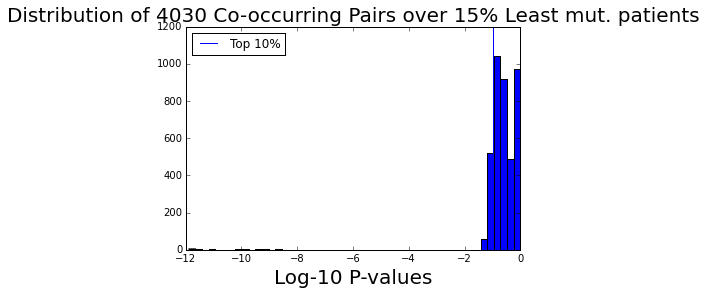

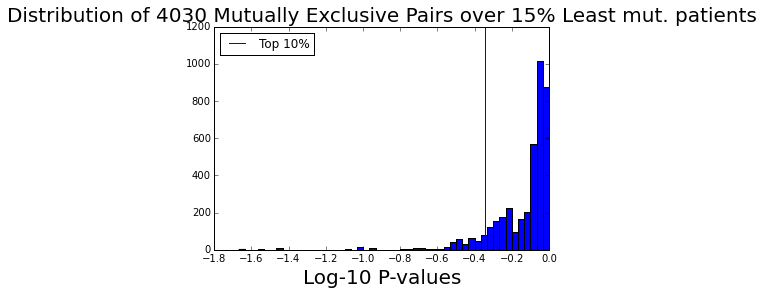

In [6]:
import matplotlib.pyplot as plt

%matplotlib inline
cpvalues = np.array([pairsdict[c]['1CBinomProb0'] for c in pairsdict])
logcp = np.log10(cpvalues)
mpvalues = np.array([pairsdict[c]['1MBinomProb0'] for c in pairsdict])
logmp = np.log10(mpvalues)


cthreshold = stats.scoreatpercentile(cpvalues, cpairPercentile)
mthreshold = stats.scoreatpercentile(mpvalues, mpairPercentile)
print "Top ", cpairPercentile, "percent of cooccurring pairs: ", cthreshold
print "Top ", mpairPercentile, "percent of mutually exclusive pairs : ", mthreshold

# Let's get the top 10 percent of pairs

goodcpairs = [c for c in pairsdict if (pairsdict[c]['1CBinomProb0'] <= cthreshold)]
goodmpairs = [c for c in pairsdict if (pairsdict[c]['1MBinomProb0'] <= mthreshold)]
goodpairs = goodcpairs + goodmpairs
goodgenes = set.union(*(set(goodpair) for goodpair in goodpairs))
print "Now number of mutex pairs to test ", len(goodmpairs)
print "Now number of coocurr pairs to test ", len(goodcpairs)
print "Number of genes ", len(goodgenes)

plt.figure()
plt.hist(logcp, bins=50)
plt.axvline(x= np.log10(cthreshold), label="Top " + str(cpairPercentile) + "%")
plt.title("Distribution of " + str(len(logcp)) + " Co-occurring Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()



plt.figure()
plt.hist(logmp, bins=50)
plt.axvline(x= np.log10(mthreshold), label="Top " + str(mpairPercentile) + "%")
plt.title("Distribution of " + str(len(logmp))  + " Mutually Exclusive Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()



### Test new pairs

In [7]:
print "Getting normal statistics across whole distribution"

new_mpairsdict, new_mgenedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, goodmpairs, compute_mutex=compute_mutex)
new_cpairsdict, new_cgenedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, goodcpairs, compute_mutex=compute_mutex)

print "Testing across the whole distribution"

new_mpairsdict = chi.add_BinomP_cohorts_all_pairs(new_mpairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)
new_cpairsdict = chi.add_BinomP_cohorts_all_pairs(new_cpairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)

new_pairsdict = new_mpairsdict.copy()
new_pairsdict.update(new_mpairsdict)


print "All tested pairs have been written to ", new_pairfile

fieldnames = (new_pairsdict.values()[0]).keys()
fieldnames.remove('MutationFrequencies')
fieldnames.remove('MutationFrequencyDifference')
fieldnames.remove('MutationFrequencyDifferenceRatio')
fieldnames.remove('CooccurrenceRatio')
fieldnames.remove('Coverage')
fieldnames.remove('SetScore')
fieldnames.remove('AverageOverlapPMN')
fieldnames.remove('CombinedScore')
fieldnames.remove('Concordance')
fieldnames.remove('Somatic')
fieldnames.remove('RoundedLogPCov')
fieldnames.remove('GeneSet')
fieldnames.remove('Type')

fieldnames.insert(2, 'Type')
fieldnames.insert(3, 'AllMBinomProb')
fieldnames.insert(3, 'AllCBinomProb')

met.writeanydict(new_pairsdict, new_pairfile, fieldnames=fieldnames)

os.system('say "whole distribution pairs finished"')

Getting normal statistics across whole distribution
Testing across the whole distribution
All tested pairs have been written to  output/BRCA_wustl-seg-jl--pairs-min_cohort_filtered.txt


0

### Plot results

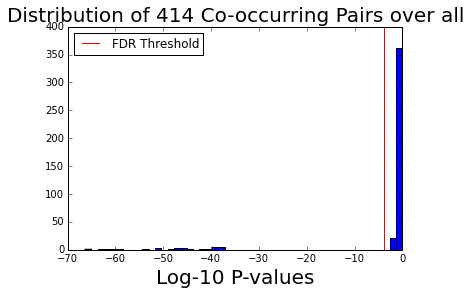

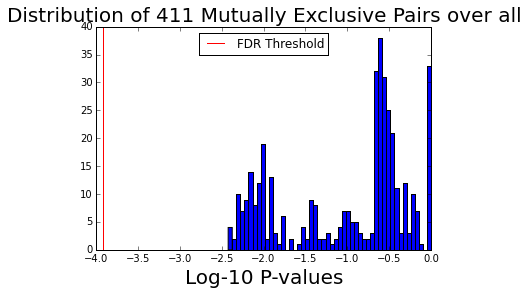

Number significant mutex 0
Number significant coocurr 31


In [8]:
import matplotlib.pyplot as plt

%matplotlib inline
# Left off here: jonathan
cpvalues = np.array([new_cpairsdict[c]['AllCBinomProb'] for c in new_cpairsdict])
logcp = np.log10(cpvalues)
mpvalues = np.array([new_mpairsdict[c]['AllMBinomProb'] for c in new_mpairsdict])
logmp = np.log10(mpvalues)

cthreshold = cpvaluethreshold/len(logcp)
mthreshold = mpvaluethreshold/len(logmp)
                            
plt.figure()
plt.hist(logcp, bins=50)
plt.axvline(x=np.log10(cthreshold), label="FDR Threshold", c='r')
plt.title("Distribution of " + str(len(logcp)) + " Co-occurring Pairs over all", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()

plt.figure()
plt.hist(logmp, bins=50)
plt.axvline(x=np.log10(mthreshold), label="FDR Threshold", c='r')
plt.title("Distribution of " + str(len(logmp))  + " Mutually Exclusive Pairs over all", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()


# filter all the pairs




        
# Split into mutex and cooccur
new_sig_m_dict = new_mpairsdict.copy()
new_sig_c_dict = new_cpairsdict.copy()

for pair in new_mpairsdict:
    if new_sig_m_dict[pair]['AllMBinomProb'] > mthreshold:
        new_sig_m_dict.pop(pair)

for pair in new_cpairsdict:
    if new_sig_c_dict[pair]['AllCBinomProb'] > cthreshold:
        new_sig_c_dict.pop(pair)
print "Number significant mutex", len(new_sig_m_dict)
print "Number significant coocurr", len(new_sig_c_dict)


new_sig_dict = new_sig_m_dict.copy()
new_sig_dict.update(new_sig_c_dict)
# new_sig_dict = new_pairsdict.copy()
# for pair in new_pairsdict:
#     if new_sig_dict[pair]['AllCBinomProb'] > cthreshold and new_sig_dict[pair]['AllMBinomProb'] > mthreshold:
#         new_sig_dict.pop(pair)

## Mutual exclusivity info

In [9]:


bgbp.write_segment_infos(goodgenes, segment_info_file)



print "*********MUTUAL EXCLUSIVITY INFO**********\n"

print len(new_sig_m_dict), " Mutually exclusive pairs"

mfieldnames = ['Gene0', 'Gene1', 'Gene0Cytobands', 'Gene1Cytobands', 'AllMBinomProb', 
                'AllFreqs', 'AllOverlap', 'AllSize','1MBinomProb0', '1Freqs0', '1Overlap0',
               '1Size0']


gene_m_dict = {}
cyto_m_dict = {}
cyto_pair_m_dict = {}

for pair in new_sig_m_dict:
    if new_sig_m_dict[pair]['Gene0'][-4:] in {'loss', 'gain'}:
        suffix0 = new_sig_m_dict[pair]['Gene0'][-4:]
    else:
        suffix0 = ""

    if new_sig_m_dict[pair]['Gene1'][-4:] in {'loss', 'gain'}:
        suffix1 = new_sig_m_dict[pair]['Gene1'][-4:]
    else:
        suffix1 = ""
    
    
    info0 = bgbp.get_segment_gene_info(new_sig_m_dict[pair]['Gene0'])
    new_sig_m_dict[pair]['Gene0Loc'] = str(info0['Chromosome']) + ':' + str(info0['Start'])
    info1 = bgbp.get_segment_gene_info(new_sig_m_dict[pair]['Gene1'])
    new_sig_m_dict[pair]['Gene1Loc'] = str(info1['Chromosome']) + ':' + str(info1['Start'])
    new_sig_m_dict[pair]['Gene0Cytobands'] = str(info0['Cytobands'])
    new_sig_m_dict[pair]['Gene1Cytobands'] = str(info1['Cytobands'])
    
    
    if new_sig_m_dict[pair]['Gene0'] not in gene_m_dict:
        gene_m_dict[new_sig_m_dict[pair]['Gene0']] = set()
    gene_m_dict[new_sig_m_dict[pair]['Gene0']].add(pair)
    if new_sig_m_dict[pair]['Gene1'] not in gene_m_dict:
        gene_m_dict[new_sig_m_dict[pair]['Gene1']] = set()
    gene_m_dict[new_sig_m_dict[pair]['Gene1']].add(pair)
    
    
    
    if str(info0['Cytobands']) + suffix0 not in cyto_m_dict:
        cyto_m_dict[str(info0['Cytobands']) + suffix0] = set()
    cyto_m_dict[str(info0['Cytobands'])].add(pair)
    if str(info1['Cytobands']) + suffix1 not in cyto_m_dict:
        cyto_m_dict[str(info1['Cytobands']) + suffix1] = set()
    cyto_m_dict[str(info1['Cytobands'])].add(pair)
    
    
    
    cyto_pair = frozenset([str(info0['Cytobands']) + suffix0, str(info1['Cytobands']) + suffix1])
    
    if cyto_pair not in cyto_pair_m_dict:
        cyto_pair_m_dict[cyto_pair] = set()
        
    cyto_pair_m_dict[cyto_pair].add(pair)


if new_sig_m_dict:
    for key in new_sig_m_dict[pair].keys():
        if key not in mfieldnames:
            mfieldnames.append(key)
    

orderedmpairs = sorted(new_sig_m_dict.keys(), key=lambda entry: (new_sig_m_dict[entry]['AllMBinomProb'],))
    
met.writeanydict(new_sig_m_dict, new_mpairfile, fieldnames=mfieldnames, orderedkeys=orderedmpairs)
print "updated with segment info ", new_mpairfile
!python add_COSMIC.py -ic Gene0 Gene1 -ip $COSMIC_pair_insertion_index -i $new_mpairfile -o $new_mpairfile
print "updated with COSMIC info ", new_mpairfile


# Writing gene infos
    

sorted_genes = sorted(gene_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytobands = sorted(cyto_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytotuples = sorted(cyto_pair_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)

print "\n**********SINGLE GENES**********"
print_length = 15
for gene in sorted_genes:
    if len(gene[0]) <= print_length + 4:
        print gene[0], "has", len(gene[1])
    else:
        print gene[0][0:print_length] + gene[0][-4:], "has\t", len(gene[1])

print "\n**********SINGLE CYTOBANDS**********"
for cytoband in sorted_cytobands:
    print cytoband[0], "has", len(cytoband[1])

print "\n**********PAIRED CYTOBANDS**********"
for cytotuple in sorted_cytotuples:
    print  cytotuple[0], "has", len(cytotuple[1])


os.system('say "finished"')

*********MUTUAL EXCLUSIVITY INFO**********

0  Mutually exclusive pairs
updated with segment info  output/BRCA_wustl-seg-jl--mpairs-min_cohort_filtered.txt
updated with COSMIC info  output/BRCA_wustl-seg-jl--mpairs-min_cohort_filtered.txt

**********SINGLE GENES**********

**********SINGLE CYTOBANDS**********

**********PAIRED CYTOBANDS**********


0

## Co-occurrence info

In [10]:
bgbp.write_segment_infos(goodgenes, segment_info_file)




print "*********COOCCURRENCE INFO**********\n"

print len(new_sig_c_dict), " Co-occurring pairs"

cfieldnames = ['Gene0', 'Gene1', 'Gene0Cytobands', 'Gene1Cytobands', 'AllCBinomProb', 
               'AllFreqs', 'AllOverlap', 'AllSize','1CBinomProb0', '1Freqs0', '1Overlap0',
               '1Size0']


gene_c_dict = {}
cyto_c_dict = {}
cyto_pair_c_dict = {}

for pair in new_sig_c_dict:
    if new_sig_c_dict[pair]['Gene0'][-4:] in {'loss', 'gain'}:
        suffix0 = new_sig_c_dict[pair]['Gene0'][-4:]
    else:
        suffix0 = ""

    if new_sig_c_dict[pair]['Gene1'][-4:] in {'loss', 'gain'}:
        suffix1 = new_sig_c_dict[pair]['Gene1'][-4:]
    else:
        suffix1 = ""
    
    
    info0 = bgbp.get_segment_gene_info(new_sig_c_dict[pair]['Gene0'])
    new_sig_c_dict[pair]['Gene0Loc'] = str(info0['Chromosome']) + ':' + str(info0['Start'])
    info1 = bgbp.get_segment_gene_info(new_sig_c_dict[pair]['Gene1'])
    new_sig_c_dict[pair]['Gene1Loc'] = str(info1['Chromosome']) + ':' + str(info1['Start'])
    new_sig_c_dict[pair]['Gene0Cytobands'] = str(info0['Cytobands'])
    new_sig_c_dict[pair]['Gene1Cytobands'] = str(info1['Cytobands'])
    
    
    if new_sig_c_dict[pair]['Gene0'] not in gene_c_dict:
        gene_c_dict[new_sig_c_dict[pair]['Gene0']] = set()
    gene_c_dict[new_sig_c_dict[pair]['Gene0']].add(pair)
    if new_sig_c_dict[pair]['Gene1'] not in gene_c_dict:
        gene_c_dict[new_sig_c_dict[pair]['Gene1']] = set()
    gene_c_dict[new_sig_c_dict[pair]['Gene1']].add(pair)
    
    
    
    if str(info0['Cytobands']) + suffix0 not in cyto_c_dict:
        cyto_c_dict[str(info0['Cytobands']) + suffix0] = set()
    cyto_c_dict[str(info0['Cytobands']) + suffix0].add(pair)
    if str(info1['Cytobands']) + suffix1 not in cyto_c_dict:
        cyto_c_dict[str(info1['Cytobands']) + suffix1] = set()
    cyto_c_dict[str(info1['Cytobands']) + suffix1].add(pair)
    
    
    
    cyto_pair = frozenset([str(info0['Cytobands']) + suffix0, str(info1['Cytobands']) + suffix1])
    
    if cyto_pair not in cyto_pair_c_dict:
        cyto_pair_c_dict[cyto_pair] = set()
        
    cyto_pair_c_dict[cyto_pair].add(pair)
    
# Writing to file
if new_sig_c_dict:
    for key in new_sig_c_dict[pair].keys():
        if key not in cfieldnames:
            cfieldnames.append(key)
    
orderedcpairs = sorted(new_sig_c_dict.keys(), key=lambda entry: (new_sig_c_dict[entry]['AllCBinomProb'],))
    
met.writeanydict(new_sig_c_dict, new_cpairfile, fieldnames=cfieldnames, orderedkeys=orderedcpairs)
print "updated with segment info ", new_cpairfile
!python add_COSMIC.py -ic Gene0 Gene1 -ip $COSMIC_pair_insertion_index -i $new_cpairfile -o $new_cpairfile
print "updated with COSMIC info ", new_cpairfile


# Writing gene infos
    

sorted_genes = sorted(gene_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytobands = sorted(cyto_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytotuples = sorted(cyto_pair_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)

print "\n**********SINGLE GENES**********"
print_length = 15
for gene in sorted_genes:
    if len(gene[0]) <= print_length + 4:
        print gene[0], "has", len(gene[1])
    else:
        print gene[0][0:print_length] + gene[0][-4:], "has\t", len(gene[1])

print "\n**********SINGLE CYTOBANDS**********"
for cytoband in sorted_cytobands:
    print cytoband[0], "has", len(cytoband[1])

print "\n**********PAIRED CYTOBANDS**********"
for cytotuple in sorted_cytotuples:
    print  cytotuple[0], "has", len(cytotuple[1])


os.system('say "finished"')

*********COOCCURRENCE INFO**********

31  Co-occurring pairs
updated with segment info  output/BRCA_wustl-seg-jl--cpairs-min_cohort_filtered.txt
updated with COSMIC info  output/BRCA_wustl-seg-jl--cpairs-min_cohort_filtered.txt

**********SINGLE GENES**********
FAM230Closs has 19
RN7SL605Ploss has 12
TBC1D22Aloss has 1
ZNRF3_C22orf31_loss has	1
SEZ6L_RNA5SP495loss has	1
RN7SL757Ploss has 1
AIPL1_FAM64A_KIloss has	1
HS3ST3A1_MIR548loss has	1
MAP2K4_MIR744loss has 1
MYH13_MYH8_MYH4loss has	1
CYB5D1_CHD3_KCNloss has	1
PPM1F_TOP3B_VPRloss has	1
YWHAEloss has 1
IGLL1_GUSBP11_Rloss has	1
LINC00898loss has 1
LARGEloss has 1
RN7SL162P_CHEK2loss has	1
LINC00670_MYOCDloss has	1
MN1_PITPNBloss has 1
WSCD1loss has 1
OR11H1_POTEH_KCloss has	1
HMGXB4_TOM1_MIRloss has	1
TXN2_FOXRED2_EIloss has	1
DOC2B_RPH3AL_C1loss has	1
ISXloss has 1
CRK_MYO1C_INPP5loss has	1
STX8_USP43_DHRSloss has	1
DNAH9_ZNF18_RPLloss has	1
MIR3201_FAM19A5loss has	1
TTC28loss has 1
MAPK1_RNA5SP493loss has 1
PEX26_TUBA8_USPloss ha

0

## Search for triplets from among the pairs

In [11]:
# Search for triplets
import mutex_triangles as met
import edgereader as edg


        
    
    
# Search for triplets
import mutex_triangles as met
import edgereader as edg

genedict = edg.get_gene_dict(new_sig_dict)
Triplets, pairsdict_Triplets, sorted_pairs, genesdict_Triplets, sorted_genes = met.getTriplets(new_sig_dict, genedict, new_sig_dict, numCases, geneToCases=geneToCases, patientToGenes=patientToGenes)
Triplet_dict = met.sort_triplets_by_type(Triplets)

for t_type in Triplet_dict:
    print len(Triplet_dict[t_type]), " of type ",  t_type
    Triplet_dict[t_type] = sorted(Triplet_dict[t_type], key=lambda entry: entry.stats['Count'], reverse=True)
    triplet_file_name = triplet_output_prefix + t_type + '.txt'
    met.writeTriplets2(Triplet_dict[t_type], triplet_file_name)
    !python add_COSMIC.py -ic Gene0 Gene1 Gene2 -ip $COSMIC_triplet_insertion_index -i $triplet_file_name -o $triplet_file_name
    print "updated with COSMIC info ", triplet_file_name
    
    
    
    print "*********" + str(t_type) + "INFO**********\n"
    gene_t_dict = {}
    cyto_t_dict = {}
    cyto_trip_t_dict = {}
    
    
    # LEFT OFF HERE-JLU
    
    for triplet in Triplet_dict[t_type]:
        genes = triplet.genes
        suffixes = [gene[-4:] if gene[-4:] in {'loss', 'gain'} else "" for gene in genes]
        
        cytobands = set([str(bgbp.get_segment_gene_info(gene)['Cytobands']) for gene, suffix in zip(genes, suffixes)])
        
        for gene in genes:
            if gene not in gene_t_dict:
                gene_t_dict[gene] = set()
            gene_t_dict[gene].add(frozenset(genes.difference(set([gene]))))
    
        
        for cytoband in cytobands:
            if cytoband not in cyto_t_dict:
                cyto_t_dict[cytoband] = set()
            cyto_t_dict[cytoband].add(frozenset(cytobands.difference(set([cytoband]))))
    
        if frozenset(cytobands) not in cyto_trip_t_dict:
            cyto_trip_t_dict[frozenset(cytobands)] = set()
            
        cyto_trip_t_dict[frozenset(cytobands)].add(frozenset(genes))
    
    
    

    sorted_genes = sorted(gene_t_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
    sorted_cytobands = sorted(cyto_t_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
    sorted_cytotuples = sorted(cyto_trip_t_dict.items(), key = lambda entry: len(entry[1]), reverse=True)

    print "\n**********SINGLE GENES**********"
    print_length = 15
    for gene in sorted_genes:
        if len(gene[0]) <= print_length + 4:
            print gene[0], "has", len(gene[1])
        else:
            print gene[0][0:print_length] + gene[0][-4:], "has\t", len(gene[1])

    print "\n**********SINGLE CYTOBANDS**********"
    for cytoband in sorted_cytobands:
        print cytoband[0], "has", len(cytoband[1])

    print "\n**********PAIRED CYTOBANDS**********"
    for cytotuple in sorted_cytotuples:
        print  cytotuple[0], "has", len(cytotuple[1])


    os.system('say "finished"')



number of pairs  31
Pair info of triplets initialized
0  triplets calculated in  0.00104594230652
Including sorting time  0.0011510848999


# Draw mutual exclusivity network

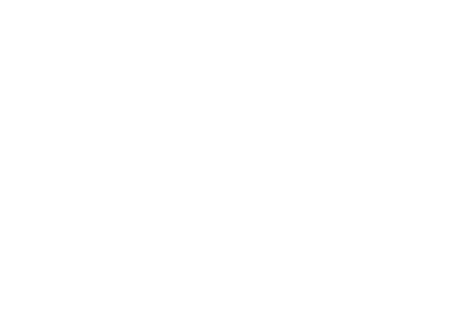

In [12]:
import networkx as nx
import csv

G=nx.Graph()
for pair in new_sig_m_dict:
    pair_type = new_sig_m_dict[pair]['Type']
    
    G.add_edge(tuple(pair)[0], tuple(pair)[1], {"Type": pair_type})

pos = nx.spring_layout(G)
nx.draw(G, pos)

# show graph
plt.show()

graphs = list(nx.connected_component_subgraphs(G))

top_number = 3

for i in range(len(graphs)):
    print "\n***********************"
    print "COMPONENT " + str(i) 
    print "***********************"
    graph = graphs[i]
    print "Number of nodes ", graph.number_of_nodes()
    print "Number of edges ", graph.number_of_edges()
    
    node_items = [g + (graph.degree(g[0]),) for g in nx.degree_centrality(graph).items()]
    node_items = sorted(node_items, key=lambda entry: entry[1], reverse = True)
    

    print "---"
    print "Top", top_number, "nodes by degree centraliy in component", i
    print "Gene: Degree Centrality   Degree"
    for j in range(top_number):
        print node_items[j][0], ":", np.round(node_items[j][1], 2), node_items[j][2]
    
    component_file = network_m_file[:-4] + "_comp" + str(i) + ".txt"
    
    print "---"
    print "Writing nodes to: ", component_file
    with open(component_file, 'w') as csvfile:
        writer = csv.writer(csvfile, delimiter='\t')
        writer.writerow(["Node", "Degreee Centrality", "Degree"])
        for node_item in node_items:
            writer.writerow(node_item)

# Draw co-occurrence network

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


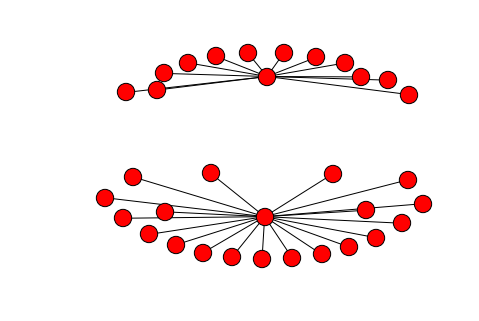


***********************
COMPONENT 0
***********************
Number of nodes  20
Number of edges  19
---
Top 3 nodes by degree centraliy in component 0
Gene: Degree Centrality   Degree
FAM230Closs : 1.0 19
ISXloss : 0.05 1
MN1_PITPNBloss : 0.05 1
---
Writing nodes to:  output/BRCA_wustl-seg-jl--cpairs-min_cohort_filtered_network_comp0.txt

***********************
COMPONENT 1
***********************
Number of nodes  13
Number of edges  12
---
Top 3 nodes by degree centraliy in component 1
Gene: Degree Centrality   Degree
RN7SL605Ploss : 1.0 12
WSCD1loss : 0.08 1
YWHAEloss : 0.08 1
---
Writing nodes to:  output/BRCA_wustl-seg-jl--cpairs-min_cohort_filtered_network_comp1.txt


In [13]:
import networkx as nx
import csv

G=nx.Graph()
for pair in new_sig_c_dict:
    pair_type = new_sig_c_dict[pair]['Type']
    
    G.add_edge(tuple(pair)[0], tuple(pair)[1], {"Type": pair_type})

pos = nx.spring_layout(G)
nx.draw(G, pos)

# show graph
plt.show()

graphs = list(nx.connected_component_subgraphs(G))

top_number = 3

for i in range(len(graphs)):
    print "\n***********************"
    print "COMPONENT " + str(i) 
    print "***********************"
    graph = graphs[i]
    print "Number of nodes ", graph.number_of_nodes()
    print "Number of edges ", graph.number_of_edges()
    
    node_items = [g + (graph.degree(g[0]),) for g in nx.degree_centrality(graph).items()]
    node_items = sorted(node_items, key=lambda entry: entry[1], reverse = True)
    

    print "---"
    print "Top", top_number, "nodes by degree centraliy in component", i
    print "Gene: Degree Centrality   Degree"
    for j in range(top_number):
        print node_items[j][0], ":", np.round(node_items[j][1], 2), node_items[j][2]
    
    component_file = network_c_file[:-4] + "_comp" + str(i) + ".txt"
    
    print "---"
    print "Writing nodes to: ", component_file
    with open(component_file, 'w') as csvfile:
        writer = csv.writer(csvfile, delimiter='\t')
        writer.writerow(["Node", "Degreee Centrality", "Degree"])
        for node_item in node_items:
            writer.writerow(node_item)

# ----------------------------------------------------------------------
# BRCA WUSTL SNV RUNS
# ----------------------------------------------------------------------

# Set parameters

In [14]:
mutationmatrix = '/Users/jlu96/maf/new/BRCA_wustl/BRCA_wustl-som.m2'
# Set to name of tab-delimited matrix file. First column of each row should be Patient ID. Remaining row entries are names of present mutations

patientFile = '/Users/jlu96/maf/new/BRCA_wustl/shared_patients.plst'
# Text file with patient names. Set to None to use all the patients.


output_prefix =  "output/BRCA_wustl-som-"
# Prefix for the following output filenames:
pairfile = output_prefix + 'pairs-min_cohort.txt' #Pair statistics within the least mutated patients
new_pairfile = output_prefix + "-pairs-min_cohort_filtered.txt" #Pair statistics over all patients
new_cpairfile = output_prefix + "-cpairs-min_cohort_filtered.txt" #Co-occurringPair statistics over all patients
new_mpairfile = output_prefix + "-mpairs-min_cohort_filtered.txt"#Mutually exclusive Pair statistics over all patients
triplet_output_prefix = output_prefix + '-triplets-'
segment_info_file = output_prefix + "segment_info_som.txt" # Name of file to write segmentation information to
network_c_file = new_cpairfile[:-4] + "_network.txt"
network_m_file = new_mpairfile[:-4] + "_network.txt"



leastPatientThreshold = 15
# To choose which genes to test, first consider only the patients below this percentile. e.g. if set to 50, the bottom 50% of patients
# are called least mutated.

test_gene_threshold = 2
# Test genes that are mutated in at least this percentage of the least mutated patients.


geneFile = None
# Only load genes listed in this file

minFreq = 0
# Minimum gene mutation frequency


closer_than_distance = 100000000
# Minimum distance between genes to test them, in bp.

cpvaluethreshold = 0.05
# FDR threshold for c-pvalues.

mpvaluethreshold = 0.05
# FDR threshold for mutually exclusive pairs.


# 1) Plot the distribution of mutations across genes and across patients
# 2) Plot distribution over the least mutated patients
# 3) Generate the gene pairs to be tested

A good rule of thumb is to 

17637 genes x 963 patients
*******************************************************************
*                   PLOT MUTATION DISTRIBUTIONS                   *
*******************************************************************
GENE MUTATION DISTRIBUTION


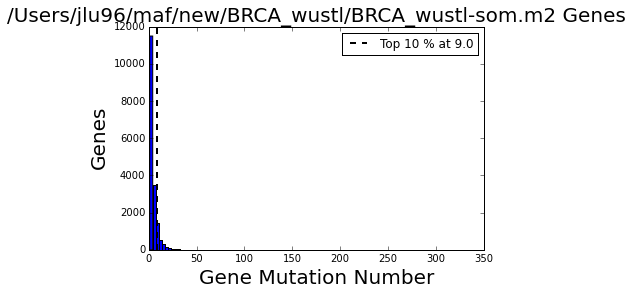

Zoomed into bottom 95 percent region


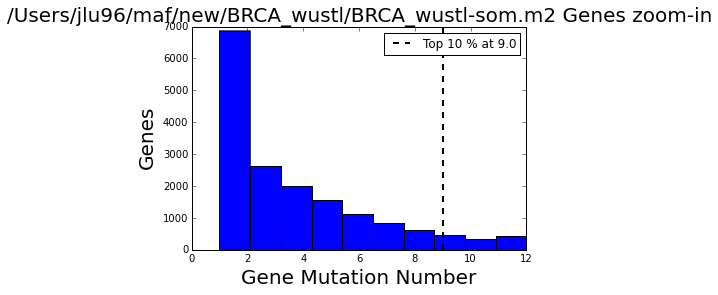


PATIENT MUTATION DISTRIBUTION


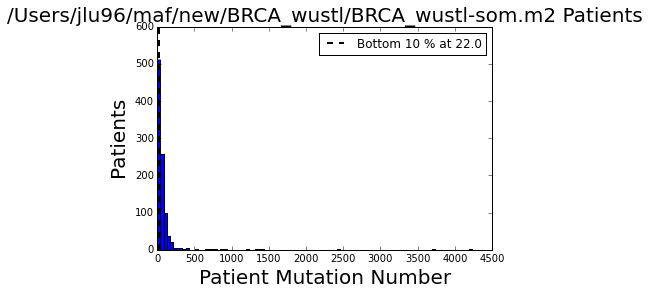

Zoomed into bottom 95 percent region


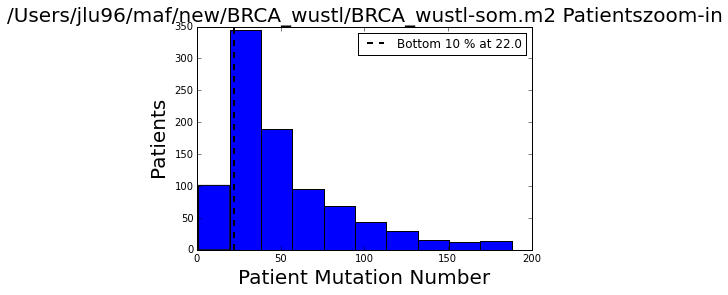

*******************************************************************
*         PLOT DISTRIBUTIONS AMONG LEAST MUTATED PATIENTS         *
*******************************************************************
GENE MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS


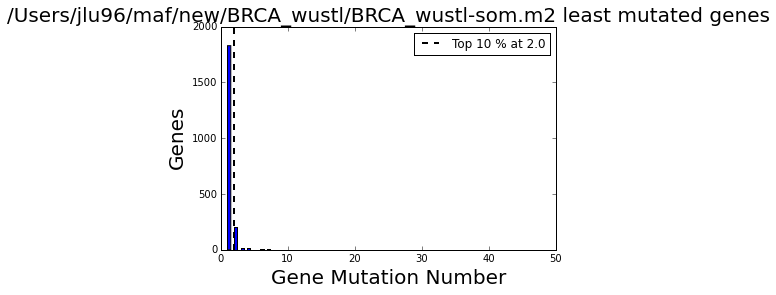


PATIENT MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS


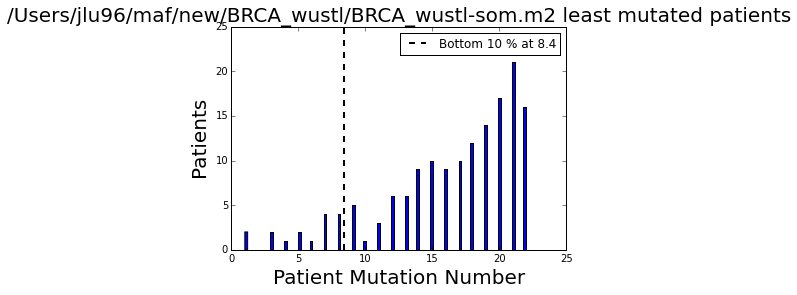

*******************************************************************
*                   GETTING TEST GENE PAIRS                       *
*******************************************************************
The least mutated patients are the bottom  15  % of patients
Least mutated patients: 2081 genes x 155 patients
The test gene threshold is  2 % of the least mutated patients
Test genes are mutated at least  3  in th least mutated patients
Number of test genes:  49
Gene  GPR98  was not found in gene_positions.txt. We pretend it is on Chromosome Z.
Number of pairs to test:  1132
Number of pairs is  1132  retrieved in time :  6.27046108246


0

In [15]:
import mutex as mex
import csv
import mutex_triangles as met
import chisquared as chi
import bingenesbypairs as bgbp
import time
import os
import scipy.stats as stats
import partition as par
import numpy as np
%matplotlib inline

COSMIC_pair_insertion_index = 8
COSMIC_triplet_insertion_index = 5
compute_mutex = True

numGenes, numCases, genes, patients, geneToCases, patientToGenes = mex.load_mutation_data(mutationmatrix, patientFile, geneFile, minFreq)

print '%s genes x %s patients' % (numGenes, numCases)


print "*******************************************************************"
print "*                   PLOT MUTATION DISTRIBUTIONS                   *"
print "*******************************************************************"

print "GENE MUTATION DISTRIBUTION"
mex.graph_mutation_distribution(numCases, genes, geneToCases, filename=mutationmatrix + " Genes", bins=100, zoomin_percentile=95)


print "\nPATIENT MUTATION DISTRIBUTION"
mex.graph_patient_distribution(len(genes), patients, patientToGenes, mutationmatrix + " Patients", bottom_percentile=leastPatientThreshold, zoomin_percentile=95)


print "*******************************************************************"
print "*         PLOT DISTRIBUTIONS AMONG LEAST MUTATED PATIENTS         *"
print "*******************************************************************"




D = [len(patientToGenes[p]) for p in patientToGenes]
minThreshold = stats.scoreatpercentile(D, leastPatientThreshold)

c0patients = [p for p in patientToGenes if len(patientToGenes[p]) <= minThreshold]

c0cohort_dict = {0: c0patients}

c0genes, c0geneToCases, c0patientToGenes = par.get_cluster_gTC_pTG(geneToCases, patientToGenes, c0patients)

print "GENE MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS"
mex.graph_mutation_distribution(len(c0patients), c0genes, c0geneToCases, filename=mutationmatrix + " least mutated genes", bins=100)

print "\nPATIENT MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS"
mex.graph_patient_distribution(len(genes), c0patients, c0patientToGenes, filename=mutationmatrix + " least mutated patients")



print "*******************************************************************"
print "*                   GETTING TEST GENE PAIRS                       *"
print "*******************************************************************"
print "The least mutated patients are the bottom ", leastPatientThreshold, " % of patients"
print "Least mutated patients: %s genes x %s patients" % (len(c0genes), len(c0patients) )


test_minFreq = int( test_gene_threshold * 0.01 * len(c0patients))
print "The test gene threshold is ", test_gene_threshold, "% of the least mutated patients"
print "Test genes are mutated at least ", test_minFreq, " in th least mutated patients"

print "Number of test genes: ", len([g for g in c0genes if len(c0geneToCases[g]) >= test_minFreq])


reload(bgbp)
t = time.time()
genepairs = bgbp.getgenepairs(c0geneToCases, c0genes, test_minFreq=test_minFreq, closer_than_distance=closer_than_distance)
print "Number of pairs is ", len(genepairs), " retrieved in time : ", time.time() - t

os.system('say "exploration finished"')

## Perform statistical tests of each of the pairs
### This cell's runtime is usually about (number of pairs)/ 900 seconds.

In [16]:
print "Getting normal statistics..."
t = time.time()
pairsdict, genedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, genepairs, compute_mutex=compute_mutex)
print "Finished in ", time.time() - t

print "Testing among least mutated patients..."
t = time.time()
pairsdict = chi.add_BinomP_cohorts_all_pairs(pairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)
print "Finished in ", time.time() - t
print "All pairs tested in least mutated patients written to ",  pairfile

fieldnames = (pairsdict.values()[0]).keys()
fieldnames.remove('MutationFrequencies')
fieldnames.remove('MutationFrequencyDifference')
fieldnames.remove('MutationFrequencyDifferenceRatio')
fieldnames.remove('CooccurrenceRatio')
fieldnames.remove('Coverage')
fieldnames.remove('SetScore')
fieldnames.remove('AverageOverlapPMN')
fieldnames.remove('CombinedScore')
fieldnames.remove('Concordance')
fieldnames.remove('Somatic')
fieldnames.remove('RoundedLogPCov')
fieldnames.remove('GeneSet')
fieldnames.remove('Type')


fieldnames.insert(2, 'Type')
fieldnames.insert(3, '1CBinomProb0')
fieldnames.insert(3, '1MBinomProb0')

met.writeanydict(pairsdict, pairfile, fieldnames=fieldnames)
print "Pairs in least mutated patients finished"
os.system('say "Pairs in least mutated patients finished"')



Getting normal statistics...
Finished in  0.807583093643
Testing among least mutated patients...
Finished in  0.872720003128
All pairs tested in least mutated patients written to  output/BRCA_wustl-som-pairs-min_cohort.txt
Pairs in least mutated patients finished


0

# Plot the distribution of p-values.

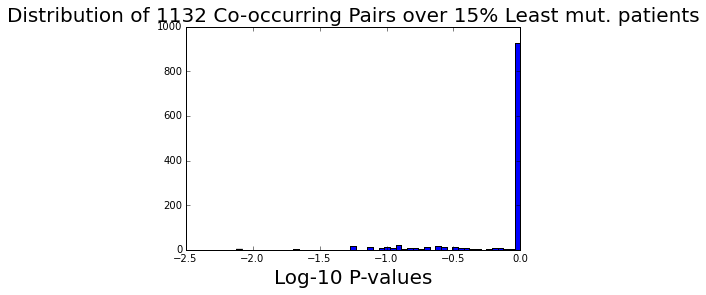

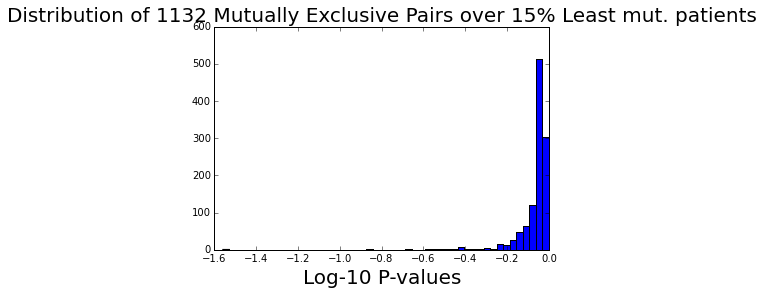

In [17]:
import matplotlib.pyplot as plt

%matplotlib inline
cpvalues = np.array([pairsdict[c]['1CBinomProb0'] for c in pairsdict])
logcp = np.log10(cpvalues)
mpvalues = np.array([pairsdict[c]['1MBinomProb0'] for c in pairsdict])
logmp = np.log10(mpvalues)


plt.figure()
plt.hist(logcp, bins=50)
plt.title("Distribution of " + str(len(logcp)) + " Co-occurring Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()

plt.figure()
plt.hist(logmp, bins=50)
plt.title("Distribution of " + str(len(logmp))  + " Mutually Exclusive Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()

# Set the cutoff of significant pairs to test over the whole distribution

In [18]:
cpairPercentile = 10
# Percentile of most significant co-occurring pairs to test

mpairPercentile = 10

# Visualize the cutoff
## Go back and adjust if you'd like!

Top  10 percent of cooccurring pairs:  0.207396554245
Top  10 percent of mutually exclusive pairs :  0.747662312754
Now number of mutex pairs to test  118
Now number of coocurr pairs to test  116
Number of genes  49


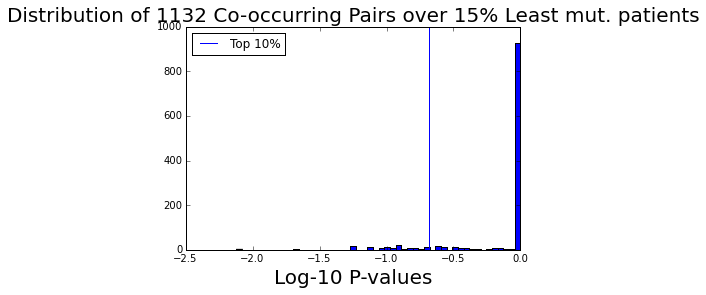

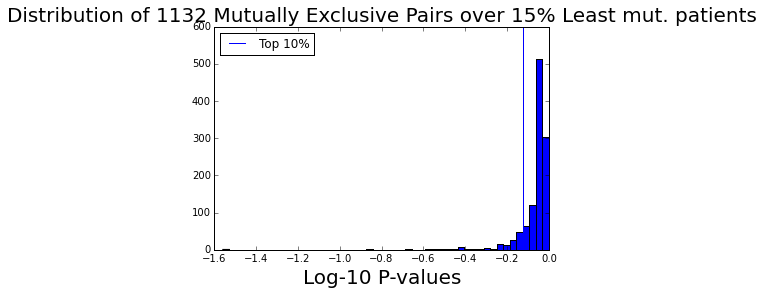

In [19]:
import matplotlib.pyplot as plt

%matplotlib inline
cpvalues = np.array([pairsdict[c]['1CBinomProb0'] for c in pairsdict])
logcp = np.log10(cpvalues)
mpvalues = np.array([pairsdict[c]['1MBinomProb0'] for c in pairsdict])
logmp = np.log10(mpvalues)


cthreshold = stats.scoreatpercentile(cpvalues, cpairPercentile)
mthreshold = stats.scoreatpercentile(mpvalues, mpairPercentile)
print "Top ", cpairPercentile, "percent of cooccurring pairs: ", cthreshold
print "Top ", mpairPercentile, "percent of mutually exclusive pairs : ", mthreshold

# Let's get the top 10 percent of pairs

goodcpairs = [c for c in pairsdict if (pairsdict[c]['1CBinomProb0'] <= cthreshold)]
goodmpairs = [c for c in pairsdict if (pairsdict[c]['1MBinomProb0'] <= mthreshold)]
goodpairs = goodcpairs + goodmpairs
goodgenes = set.union(*(set(goodpair) for goodpair in goodpairs))
print "Now number of mutex pairs to test ", len(goodmpairs)
print "Now number of coocurr pairs to test ", len(goodcpairs)
print "Number of genes ", len(goodgenes)

plt.figure()
plt.hist(logcp, bins=50)
plt.axvline(x= np.log10(cthreshold), label="Top " + str(cpairPercentile) + "%")
plt.title("Distribution of " + str(len(logcp)) + " Co-occurring Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()



plt.figure()
plt.hist(logmp, bins=50)
plt.axvline(x= np.log10(mthreshold), label="Top " + str(mpairPercentile) + "%")
plt.title("Distribution of " + str(len(logmp))  + " Mutually Exclusive Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()



### Test new pairs

In [20]:
print "Getting normal statistics across whole distribution"

new_mpairsdict, new_mgenedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, goodmpairs, compute_mutex=compute_mutex)
new_cpairsdict, new_cgenedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, goodcpairs, compute_mutex=compute_mutex)

print "Testing across the whole distribution"

new_mpairsdict = chi.add_BinomP_cohorts_all_pairs(new_mpairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)
new_cpairsdict = chi.add_BinomP_cohorts_all_pairs(new_cpairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)

new_pairsdict = new_mpairsdict.copy()
new_pairsdict.update(new_mpairsdict)


print "All tested pairs have been written to ", new_pairfile

fieldnames = (new_pairsdict.values()[0]).keys()
fieldnames.remove('MutationFrequencies')
fieldnames.remove('MutationFrequencyDifference')
fieldnames.remove('MutationFrequencyDifferenceRatio')
fieldnames.remove('CooccurrenceRatio')
fieldnames.remove('Coverage')
fieldnames.remove('SetScore')
fieldnames.remove('AverageOverlapPMN')
fieldnames.remove('CombinedScore')
fieldnames.remove('Concordance')
fieldnames.remove('Somatic')
fieldnames.remove('RoundedLogPCov')
fieldnames.remove('GeneSet')
fieldnames.remove('Type')

fieldnames.insert(2, 'Type')
fieldnames.insert(3, 'AllMBinomProb')
fieldnames.insert(3, 'AllCBinomProb')

met.writeanydict(new_pairsdict, new_pairfile, fieldnames=fieldnames)

os.system('say "whole distribution pairs finished"')

Getting normal statistics across whole distribution
Testing across the whole distribution
All tested pairs have been written to  output/BRCA_wustl-som--pairs-min_cohort_filtered.txt


0

### Plot results

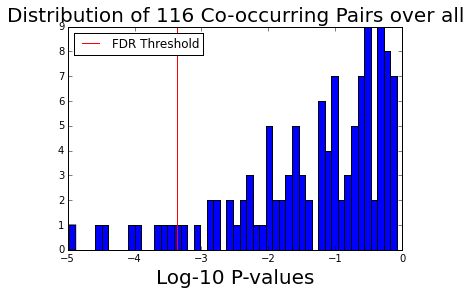

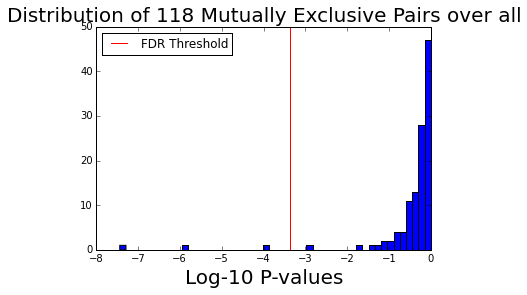

Number significant mutex 3
Number significant coocurr 8


In [21]:
import matplotlib.pyplot as plt

%matplotlib inline
# Left off here: jonathan
cpvalues = np.array([new_cpairsdict[c]['AllCBinomProb'] for c in new_cpairsdict])
logcp = np.log10(cpvalues)
mpvalues = np.array([new_mpairsdict[c]['AllMBinomProb'] for c in new_mpairsdict])
logmp = np.log10(mpvalues)

cthreshold = cpvaluethreshold/len(logcp)
mthreshold = mpvaluethreshold/len(logmp)
                            
plt.figure()
plt.hist(logcp, bins=50)
plt.axvline(x=np.log10(cthreshold), label="FDR Threshold", c='r')
plt.title("Distribution of " + str(len(logcp)) + " Co-occurring Pairs over all", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()

plt.figure()
plt.hist(logmp, bins=50)
plt.axvline(x=np.log10(mthreshold), label="FDR Threshold", c='r')
plt.title("Distribution of " + str(len(logmp))  + " Mutually Exclusive Pairs over all", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()


# filter all the pairs




        
# Split into mutex and cooccur
new_sig_m_dict = new_mpairsdict.copy()
new_sig_c_dict = new_cpairsdict.copy()

for pair in new_mpairsdict:
    if new_sig_m_dict[pair]['AllMBinomProb'] > mthreshold:
        new_sig_m_dict.pop(pair)

for pair in new_cpairsdict:
    if new_sig_c_dict[pair]['AllCBinomProb'] > cthreshold:
        new_sig_c_dict.pop(pair)
print "Number significant mutex", len(new_sig_m_dict)
print "Number significant coocurr", len(new_sig_c_dict)


new_sig_dict = new_sig_m_dict.copy()
new_sig_dict.update(new_sig_c_dict)
# new_sig_dict = new_pairsdict.copy()
# for pair in new_pairsdict:
#     if new_sig_dict[pair]['AllCBinomProb'] > cthreshold and new_sig_dict[pair]['AllMBinomProb'] > mthreshold:
#         new_sig_dict.pop(pair)

## Mutual exclusivity info

In [22]:


bgbp.write_segment_infos(goodgenes, segment_info_file)



print "*********MUTUAL EXCLUSIVITY INFO**********\n"

print len(new_sig_m_dict), " Mutually exclusive pairs"

mfieldnames = ['Gene0', 'Gene1', 'Gene0Cytobands', 'Gene1Cytobands', 'AllMBinomProb', 
                'AllFreqs', 'AllOverlap', 'AllSize','1MBinomProb0', '1Freqs0', '1Overlap0',
               '1Size0']


gene_m_dict = {}
cyto_m_dict = {}
cyto_pair_m_dict = {}

for pair in new_sig_m_dict:
    if new_sig_m_dict[pair]['Gene0'][-4:] in {'loss', 'gain'}:
        suffix0 = new_sig_m_dict[pair]['Gene0'][-4:]
    else:
        suffix0 = ""

    if new_sig_m_dict[pair]['Gene1'][-4:] in {'loss', 'gain'}:
        suffix1 = new_sig_m_dict[pair]['Gene1'][-4:]
    else:
        suffix1 = ""
    
    
    info0 = bgbp.get_segment_gene_info(new_sig_m_dict[pair]['Gene0'])
    new_sig_m_dict[pair]['Gene0Loc'] = str(info0['Chromosome']) + ':' + str(info0['Start'])
    info1 = bgbp.get_segment_gene_info(new_sig_m_dict[pair]['Gene1'])
    new_sig_m_dict[pair]['Gene1Loc'] = str(info1['Chromosome']) + ':' + str(info1['Start'])
    new_sig_m_dict[pair]['Gene0Cytobands'] = str(info0['Cytobands'])
    new_sig_m_dict[pair]['Gene1Cytobands'] = str(info1['Cytobands'])
    
    
    if new_sig_m_dict[pair]['Gene0'] not in gene_m_dict:
        gene_m_dict[new_sig_m_dict[pair]['Gene0']] = set()
    gene_m_dict[new_sig_m_dict[pair]['Gene0']].add(pair)
    if new_sig_m_dict[pair]['Gene1'] not in gene_m_dict:
        gene_m_dict[new_sig_m_dict[pair]['Gene1']] = set()
    gene_m_dict[new_sig_m_dict[pair]['Gene1']].add(pair)
    
    
    
    if str(info0['Cytobands']) + suffix0 not in cyto_m_dict:
        cyto_m_dict[str(info0['Cytobands']) + suffix0] = set()
    cyto_m_dict[str(info0['Cytobands'])].add(pair)
    if str(info1['Cytobands']) + suffix1 not in cyto_m_dict:
        cyto_m_dict[str(info1['Cytobands']) + suffix1] = set()
    cyto_m_dict[str(info1['Cytobands'])].add(pair)
    
    
    
    cyto_pair = frozenset([str(info0['Cytobands']) + suffix0, str(info1['Cytobands']) + suffix1])
    
    if cyto_pair not in cyto_pair_m_dict:
        cyto_pair_m_dict[cyto_pair] = set()
        
    cyto_pair_m_dict[cyto_pair].add(pair)


if new_sig_m_dict:
    for key in new_sig_m_dict[pair].keys():
        if key not in mfieldnames:
            mfieldnames.append(key)
    

orderedmpairs = sorted(new_sig_m_dict.keys(), key=lambda entry: (new_sig_m_dict[entry]['AllMBinomProb'],))
    
met.writeanydict(new_sig_m_dict, new_mpairfile, fieldnames=mfieldnames, orderedkeys=orderedmpairs)
print "updated with segment info ", new_mpairfile
!python add_COSMIC.py -ic Gene0 Gene1 -ip $COSMIC_pair_insertion_index -i $new_mpairfile -o $new_mpairfile
print "updated with COSMIC info ", new_mpairfile


# Writing gene infos
    

sorted_genes = sorted(gene_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytobands = sorted(cyto_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytotuples = sorted(cyto_pair_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)

print "\n**********SINGLE GENES**********"
print_length = 15
for gene in sorted_genes:
    if len(gene[0]) <= print_length + 4:
        print gene[0], "has", len(gene[1])
    else:
        print gene[0][0:print_length] + gene[0][-4:], "has\t", len(gene[1])

print "\n**********SINGLE CYTOBANDS**********"
for cytoband in sorted_cytobands:
    print cytoband[0], "has", len(cytoband[1])

print "\n**********PAIRED CYTOBANDS**********"
for cytotuple in sorted_cytotuples:
    print  cytotuple[0], "has", len(cytotuple[1])


os.system('say "finished"')

*********MUTUAL EXCLUSIVITY INFO**********

3  Mutually exclusive pairs
updated with segment info  output/BRCA_wustl-som--mpairs-min_cohort_filtered.txt
updated with COSMIC info  output/BRCA_wustl-som--mpairs-min_cohort_filtered.txt

**********SINGLE GENES**********
TP53 has 3
CDH1 has 1
MAP3K1 has 1
GATA3 has 1

**********SINGLE CYTOBANDS**********
['17p13.1'] has 3
['5q11.2'] has 1
['16q22.1'] has 1
['10p14'] has 1

**********PAIRED CYTOBANDS**********
frozenset(["['5q11.2']", "['17p13.1']"]) has 1
frozenset(["['10p14']", "['17p13.1']"]) has 1
frozenset(["['16q22.1']", "['17p13.1']"]) has 1


0

# Draw mutual exclusivity network

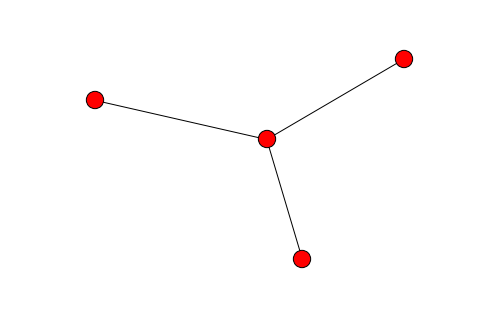


***********************
COMPONENT 0
***********************
Number of nodes  4
Number of edges  3
---
Top 3 nodes by degree centraliy in component 0
Gene: Degree Centrality   Degree
TP53 : 1.0 3
CDH1 : 0.33 1
MAP3K1 : 0.33 1
---
Writing nodes to:  output/BRCA_wustl-som--mpairs-min_cohort_filtered_network_comp0.txt


In [24]:
import networkx as nx
import csv

G=nx.Graph()
for pair in new_sig_m_dict:
    pair_type = new_sig_m_dict[pair]['Type']
    
    G.add_edge(tuple(pair)[0], tuple(pair)[1], {"Type": pair_type})

pos = nx.spring_layout(G)
nx.draw(G, pos)

# show graph
plt.show()

graphs = list(nx.connected_component_subgraphs(G))

top_number = 3

for i in range(len(graphs)):
    print "\n***********************"
    print "COMPONENT " + str(i) 
    print "***********************"
    graph = graphs[i]
    print "Number of nodes ", graph.number_of_nodes()
    print "Number of edges ", graph.number_of_edges()
    
    node_items = [g + (graph.degree(g[0]),) for g in nx.degree_centrality(graph).items()]
    node_items = sorted(node_items, key=lambda entry: entry[1], reverse = True)
    

    print "---"
    print "Top", top_number, "nodes by degree centraliy in component", i
    print "Gene: Degree Centrality   Degree"
    for j in range(top_number):
        print node_items[j][0], ":", np.round(node_items[j][1], 2), node_items[j][2]
    
    component_file = network_m_file[:-4] + "_comp" + str(i) + ".txt"
    
    print "---"
    print "Writing nodes to: ", component_file
    with open(component_file, 'w') as csvfile:
        writer = csv.writer(csvfile, delimiter='\t')
        writer.writerow(["Node", "Degreee Centrality", "Degree"])
        for node_item in node_items:
            writer.writerow(node_item)

## Co-occurrence info

In [25]:
bgbp.write_segment_infos(goodgenes, segment_info_file)




print "*********COOCCURRENCE INFO**********\n"

print len(new_sig_c_dict), " Co-occurring pairs"

cfieldnames = ['Gene0', 'Gene1', 'Gene0Cytobands', 'Gene1Cytobands', 'AllCBinomProb', 
               'AllFreqs', 'AllOverlap', 'AllSize','1CBinomProb0', '1Freqs0', '1Overlap0',
               '1Size0']


gene_c_dict = {}
cyto_c_dict = {}
cyto_pair_c_dict = {}

for pair in new_sig_c_dict:
    if new_sig_c_dict[pair]['Gene0'][-4:] in {'loss', 'gain'}:
        suffix0 = new_sig_c_dict[pair]['Gene0'][-4:]
    else:
        suffix0 = ""

    if new_sig_c_dict[pair]['Gene1'][-4:] in {'loss', 'gain'}:
        suffix1 = new_sig_c_dict[pair]['Gene1'][-4:]
    else:
        suffix1 = ""
    
    
    info0 = bgbp.get_segment_gene_info(new_sig_c_dict[pair]['Gene0'])
    new_sig_c_dict[pair]['Gene0Loc'] = str(info0['Chromosome']) + ':' + str(info0['Start'])
    info1 = bgbp.get_segment_gene_info(new_sig_c_dict[pair]['Gene1'])
    new_sig_c_dict[pair]['Gene1Loc'] = str(info1['Chromosome']) + ':' + str(info1['Start'])
    new_sig_c_dict[pair]['Gene0Cytobands'] = str(info0['Cytobands'])
    new_sig_c_dict[pair]['Gene1Cytobands'] = str(info1['Cytobands'])
    
    
    if new_sig_c_dict[pair]['Gene0'] not in gene_c_dict:
        gene_c_dict[new_sig_c_dict[pair]['Gene0']] = set()
    gene_c_dict[new_sig_c_dict[pair]['Gene0']].add(pair)
    if new_sig_c_dict[pair]['Gene1'] not in gene_c_dict:
        gene_c_dict[new_sig_c_dict[pair]['Gene1']] = set()
    gene_c_dict[new_sig_c_dict[pair]['Gene1']].add(pair)
    
    
    
    if str(info0['Cytobands']) + suffix0 not in cyto_c_dict:
        cyto_c_dict[str(info0['Cytobands']) + suffix0] = set()
    cyto_c_dict[str(info0['Cytobands']) + suffix0].add(pair)
    if str(info1['Cytobands']) + suffix1 not in cyto_c_dict:
        cyto_c_dict[str(info1['Cytobands']) + suffix1] = set()
    cyto_c_dict[str(info1['Cytobands']) + suffix1].add(pair)
    
    
    
    cyto_pair = frozenset([str(info0['Cytobands']) + suffix0, str(info1['Cytobands']) + suffix1])
    
    if cyto_pair not in cyto_pair_c_dict:
        cyto_pair_c_dict[cyto_pair] = set()
        
    cyto_pair_c_dict[cyto_pair].add(pair)
    
# Writing to file
if new_sig_c_dict:
    for key in new_sig_c_dict[pair].keys():
        if key not in cfieldnames:
            cfieldnames.append(key)
    
orderedcpairs = sorted(new_sig_c_dict.keys(), key=lambda entry: (new_sig_c_dict[entry]['AllCBinomProb'],))
    
met.writeanydict(new_sig_c_dict, new_cpairfile, fieldnames=cfieldnames, orderedkeys=orderedcpairs)
print "updated with segment info ", new_cpairfile
!python add_COSMIC.py -ic Gene0 Gene1 -ip $COSMIC_pair_insertion_index -i $new_cpairfile -o $new_cpairfile
print "updated with COSMIC info ", new_cpairfile


# Writing gene infos
    

sorted_genes = sorted(gene_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytobands = sorted(cyto_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytotuples = sorted(cyto_pair_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)

print "\n**********SINGLE GENES**********"
print_length = 15
for gene in sorted_genes:
    if len(gene[0]) <= print_length + 4:
        print gene[0], "has", len(gene[1])
    else:
        print gene[0][0:print_length] + gene[0][-4:], "has\t", len(gene[1])

print "\n**********SINGLE CYTOBANDS**********"
for cytoband in sorted_cytobands:
    print cytoband[0], "has", len(cytoband[1])

print "\n**********PAIRED CYTOBANDS**********"
for cytotuple in sorted_cytotuples:
    print  cytotuple[0], "has", len(cytotuple[1])


os.system('say "finished"')

*********COOCCURRENCE INFO**********

8  Co-occurring pairs
updated with segment info  output/BRCA_wustl-som--cpairs-min_cohort_filtered.txt
updated with COSMIC info  output/BRCA_wustl-som--cpairs-min_cohort_filtered.txt

**********SINGLE GENES**********
C9orf43 has 3
CACNA1D has 3
TTN has 2
SACS has 2
MUC16 has 2
PLCB4 has 1
WNK1 has 1
PRKDC has 1
MUC5B has 1

**********SINGLE CYTOBANDS**********
['9q31.3'] has 3
['3p21.1'] has 3
['13q12.12'] has 2
['19p13.2'] has 2
['2q31.2'] has 2
['12p13.33'] has 1
['11p15.5'] has 1
['8q11.1'] has 1
['20p12.3', '20p12.2'] has 1

**********PAIRED CYTOBANDS**********
frozenset(["['13q12.12']", "['19p13.2']"]) has 1
frozenset(["['19p13.2']", "['2q31.2']"]) has 1
frozenset(["['9q31.3']", "['3p21.1']"]) has 1
frozenset(["['3p21.1']", "['2q31.2']"]) has 1
frozenset(["['9q31.3']", "['8q11.1']"]) has 1
frozenset(["['12p13.33']", "['20p12.3', '20p12.2']"]) has 1
frozenset(["['11p15.5']", "['9q31.3']"]) has 1
frozenset(["['13q12.12']", "['3p21.1']"]) has 1


0

## Search for triplets from among the pairs

In [26]:
# Search for triplets
import mutex_triangles as met
import edgereader as edg


        
    
    
# Search for triplets
import mutex_triangles as met
import edgereader as edg

genedict = edg.get_gene_dict(new_sig_dict)
Triplets, pairsdict_Triplets, sorted_pairs, genesdict_Triplets, sorted_genes = met.getTriplets(new_sig_dict, genedict, new_sig_dict, numCases, geneToCases=geneToCases, patientToGenes=patientToGenes)
Triplet_dict = met.sort_triplets_by_type(Triplets)

for t_type in Triplet_dict:
    print len(Triplet_dict[t_type]), " of type ",  t_type
    Triplet_dict[t_type] = sorted(Triplet_dict[t_type], key=lambda entry: entry.stats['Count'], reverse=True)
    triplet_file_name = triplet_output_prefix + t_type + '.txt'
    met.writeTriplets2(Triplet_dict[t_type], triplet_file_name)
    !python add_COSMIC.py -ic Gene0 Gene1 Gene2 -ip $COSMIC_triplet_insertion_index -i $triplet_file_name -o $triplet_file_name
    print "updated with COSMIC info ", triplet_file_name
    
    
    
    print "*********" + str(t_type) + "INFO**********\n"
    gene_t_dict = {}
    cyto_t_dict = {}
    cyto_trip_t_dict = {}
    
    
    # LEFT OFF HERE-JLU
    
    for triplet in Triplet_dict[t_type]:
        genes = triplet.genes
        suffixes = [gene[-4:] if gene[-4:] in {'loss', 'gain'} else "" for gene in genes]
        
        cytobands = set([str(bgbp.get_segment_gene_info(gene)['Cytobands']) for gene, suffix in zip(genes, suffixes)])
        
        for gene in genes:
            if gene not in gene_t_dict:
                gene_t_dict[gene] = set()
            gene_t_dict[gene].add(frozenset(genes.difference(set([gene]))))
    
        
        for cytoband in cytobands:
            if cytoband not in cyto_t_dict:
                cyto_t_dict[cytoband] = set()
            cyto_t_dict[cytoband].add(frozenset(cytobands.difference(set([cytoband]))))
    
        if frozenset(cytobands) not in cyto_trip_t_dict:
            cyto_trip_t_dict[frozenset(cytobands)] = set()
            
        cyto_trip_t_dict[frozenset(cytobands)].add(frozenset(genes))
    
    
    

    sorted_genes = sorted(gene_t_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
    sorted_cytobands = sorted(cyto_t_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
    sorted_cytotuples = sorted(cyto_trip_t_dict.items(), key = lambda entry: len(entry[1]), reverse=True)

    print "\n**********SINGLE GENES**********"
    print_length = 15
    for gene in sorted_genes:
        if len(gene[0]) <= print_length + 4:
            print gene[0], "has", len(gene[1])
        else:
            print gene[0][0:print_length] + gene[0][-4:], "has\t", len(gene[1])

    print "\n**********SINGLE CYTOBANDS**********"
    for cytoband in sorted_cytobands:
        print cytoband[0], "has", len(cytoband[1])

    print "\n**********PAIRED CYTOBANDS**********"
    for cytotuple in sorted_cytotuples:
        print  cytotuple[0], "has", len(cytotuple[1])


    os.system('say "finished"')



number of pairs  11
Pair info of triplets initialized
0  triplets calculated in  0.00109887123108
Including sorting time  0.00121688842773


# Draw co-occurrence network

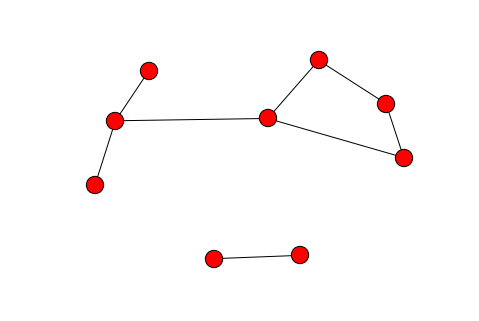


***********************
COMPONENT 0
***********************
Number of nodes  7
Number of edges  7
---
Top 3 nodes by degree centraliy in component 0
Gene: Degree Centrality   Degree
C9orf43 : 0.5 3
CACNA1D : 0.5 3
TTN : 0.33 2
---
Writing nodes to:  output/BRCA_wustl-som--cpairs-min_cohort_filtered_network_comp0.txt

***********************
COMPONENT 1
***********************
Number of nodes  2
Number of edges  1
---
Top 3 nodes by degree centraliy in component 1
Gene: Degree Centrality   Degree
WNK1 : 1.0 1
PLCB4 : 1.0 1


IndexError: list index out of range

In [27]:
import networkx as nx
import csv

G=nx.Graph()
for pair in new_sig_c_dict:
    pair_type = new_sig_c_dict[pair]['Type']
    
    G.add_edge(tuple(pair)[0], tuple(pair)[1], {"Type": pair_type})

pos = nx.spring_layout(G)
nx.draw(G, pos)

# show graph
plt.show()

graphs = list(nx.connected_component_subgraphs(G))

top_number = 3

for i in range(len(graphs)):
    print "\n***********************"
    print "COMPONENT " + str(i) 
    print "***********************"
    graph = graphs[i]
    print "Number of nodes ", graph.number_of_nodes()
    print "Number of edges ", graph.number_of_edges()
    
    node_items = [g + (graph.degree(g[0]),) for g in nx.degree_centrality(graph).items()]
    node_items = sorted(node_items, key=lambda entry: entry[1], reverse = True)
    

    print "---"
    print "Top", top_number, "nodes by degree centraliy in component", i
    print "Gene: Degree Centrality   Degree"
    for j in range(top_number):
        print node_items[j][0], ":", np.round(node_items[j][1], 2), node_items[j][2]
    
    component_file = network_c_file[:-4] + "_comp" + str(i) + ".txt"
    
    print "---"
    print "Writing nodes to: ", component_file
    with open(component_file, 'w') as csvfile:
        writer = csv.writer(csvfile, delimiter='\t')
        writer.writerow(["Node", "Degreee Centrality", "Degree"])
        for node_item in node_items:
            writer.writerow(node_item)

# ----------------------------------------------------------------------
# BRCA WUSTL SNV + SEGMENT LOSSES RUNS only copy number filter
# ----------------------------------------------------------------------

# Set parameters

In [6]:
mutationmatrix = '/Users/jlu96/maf/new/BRCA_wustl/BRCA_wustl-som-seg-jl.m2'
# Set to name of tab-delimited matrix file. First column of each row should be Patient ID. Remaining row entries are names of present mutations

patientFile = '/Users/jlu96/maf/new/BRCA_wustl/shared_patients.plst'
# Text file with patient names. Set to None to use all the patients.


output_prefix =  "output/BRCA_wustl-som-seg-jl"
# Prefix for the following output filenames:
pairfile = output_prefix + 'pairs-min_cohort.txt' #Pair statistics within the least mutated patients
new_pairfile = output_prefix + "-pairs-min_cohort_filtered.txt" #Pair statistics over all patients
new_cpairfile = output_prefix + "-cpairs-min_cohort_filtered.txt" #Co-occurringPair statistics over all patients
new_mpairfile = output_prefix + "-mpairs-min_cohort_filtered.txt"#Mutually exclusive Pair statistics over all patients
triplet_output_prefix = output_prefix + '-triplets-'
segment_info_file = output_prefix + "segment_info_som.txt" # Name of file to write segmentation information to
network_c_file = new_cpairfile[:-4] + "_network.txt"
network_m_file = new_mpairfile[:-4] + "_network.txt"



leastPatientThreshold = 15
# To choose which genes to test, first consider only the patients below this percentile. e.g. if set to 50, the bottom 50% of patients
# are called least mutated.

test_gene_threshold = 3
# Test genes that are mutated in at least this percentage of the least mutated patients.


geneFile = None
# Only load genes listed in this file

minFreq = 0
# Minimum gene mutation frequency


closer_than_distance = 100000000
# Minimum distance between genes to test them, in bp.

only_filter_copy_distance = True
# only filter the distance between copy number segements

cpvaluethreshold = 0.05
# FDR threshold for c-pvalues.

mpvaluethreshold = 0.05
# FDR threshold for mutually exclusive pairs.


# 1) Plot the distribution of mutations across genes and across patients
# 2) Plot distribution over the least mutated patients
# 3) Generate the gene pairs to be tested

A good rule of thumb is to 

19558 genes x 963 patients
*******************************************************************
*                   PLOT MUTATION DISTRIBUTIONS                   *
*******************************************************************
GENE MUTATION DISTRIBUTION


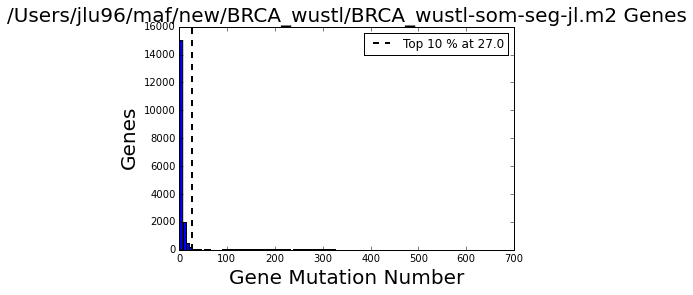

Zoomed into bottom 95 percent region


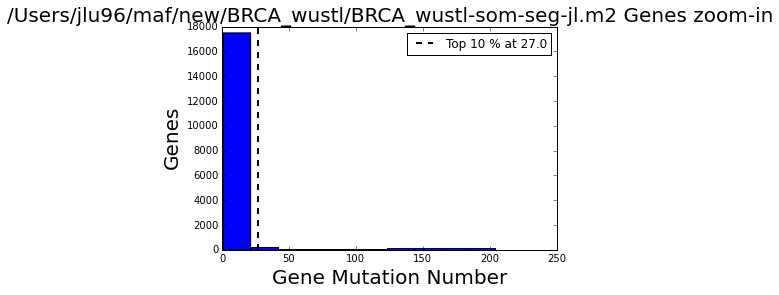


PATIENT MUTATION DISTRIBUTION


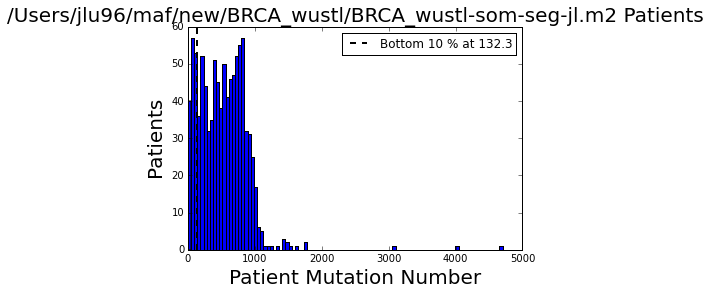

Zoomed into bottom 95 percent region


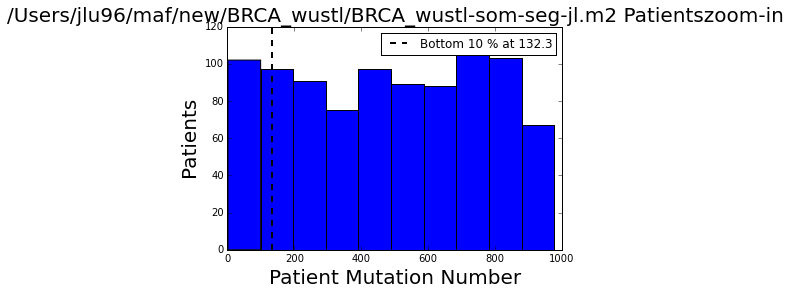

*******************************************************************
*         PLOT DISTRIBUTIONS AMONG LEAST MUTATED PATIENTS         *
*******************************************************************
GENE MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS


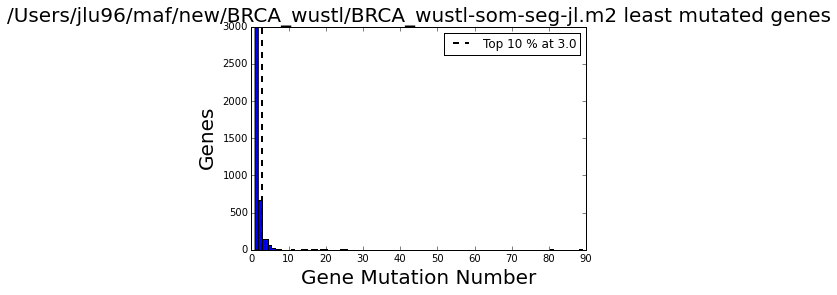


PATIENT MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS


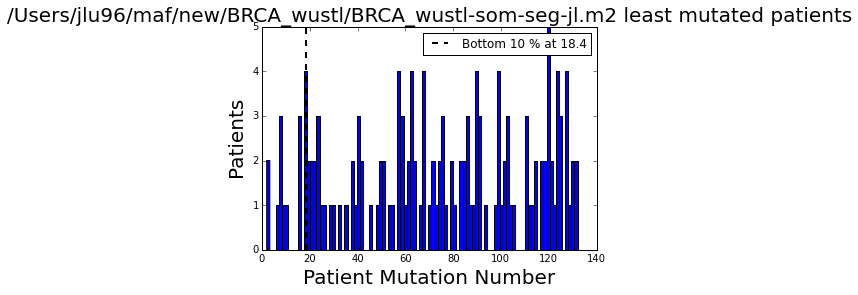

*******************************************************************
*                   GETTING TEST GENE PAIRS                       *
*******************************************************************
The least mutated patients are the bottom  15  % of patients
Least mutated patients: 4177 genes x 145 patients
The test gene threshold is  3 % of the least mutated patients
Test genes are mutated at least  4  in th least mutated patients
Number of test genes:  374
Number of pairs to test:  63814
Number of pairs is  63814  retrieved in time :  10.2620961666


0

In [7]:
import mutex as mex
import csv
import mutex_triangles as met
import chisquared as chi
import bingenesbypairs as bgbp
import time
import os
import scipy.stats as stats
import partition as par
import numpy as np
%matplotlib inline

COSMIC_pair_insertion_index = 8
COSMIC_triplet_insertion_index = 5
compute_mutex = True

numGenes, numCases, genes, patients, geneToCases, patientToGenes = mex.load_mutation_data(mutationmatrix, patientFile, geneFile, minFreq)

print '%s genes x %s patients' % (numGenes, numCases)


print "*******************************************************************"
print "*                   PLOT MUTATION DISTRIBUTIONS                   *"
print "*******************************************************************"

print "GENE MUTATION DISTRIBUTION"
mex.graph_mutation_distribution(numCases, genes, geneToCases, filename=mutationmatrix + " Genes", bins=100, zoomin_percentile=95)


print "\nPATIENT MUTATION DISTRIBUTION"
mex.graph_patient_distribution(len(genes), patients, patientToGenes, mutationmatrix + " Patients", bottom_percentile=leastPatientThreshold, zoomin_percentile=95)


print "*******************************************************************"
print "*         PLOT DISTRIBUTIONS AMONG LEAST MUTATED PATIENTS         *"
print "*******************************************************************"




D = [len(patientToGenes[p]) for p in patientToGenes]
minThreshold = stats.scoreatpercentile(D, leastPatientThreshold)

c0patients = [p for p in patientToGenes if len(patientToGenes[p]) <= minThreshold]

c0cohort_dict = {0: c0patients}

c0genes, c0geneToCases, c0patientToGenes = par.get_cluster_gTC_pTG(geneToCases, patientToGenes, c0patients)

print "GENE MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS"
mex.graph_mutation_distribution(len(c0patients), c0genes, c0geneToCases, filename=mutationmatrix + " least mutated genes", bins=100)

print "\nPATIENT MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS"
mex.graph_patient_distribution(len(genes), c0patients, c0patientToGenes, filename=mutationmatrix + " least mutated patients")



print "*******************************************************************"
print "*                   GETTING TEST GENE PAIRS                       *"
print "*******************************************************************"
print "The least mutated patients are the bottom ", leastPatientThreshold, " % of patients"
print "Least mutated patients: %s genes x %s patients" % (len(c0genes), len(c0patients) )


test_minFreq = int( test_gene_threshold * 0.01 * len(c0patients))
print "The test gene threshold is ", test_gene_threshold, "% of the least mutated patients"
print "Test genes are mutated at least ", test_minFreq, " in th least mutated patients"

print "Number of test genes: ", len([g for g in c0genes if len(c0geneToCases[g]) >= test_minFreq])


reload(bgbp)
t = time.time()
genepairs = bgbp.getgenepairs(c0geneToCases, c0genes, test_minFreq=test_minFreq, closer_than_distance=closer_than_distance, only_filter_copy_distance=only_filter_copy_distance)
print "Number of pairs is ", len(genepairs), " retrieved in time : ", time.time() - t

os.system('say "exploration finished"')

## Perform statistical tests of each of the pairs
### This cell's runtime is usually about (number of pairs)/ 900 seconds.

In [3]:
print "Getting normal statistics..."
t = time.time()
pairsdict, genedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, genepairs, compute_mutex=compute_mutex)
print "Finished in ", time.time() - t

print "Testing among least mutated patients..."
t = time.time()
pairsdict = chi.add_BinomP_cohorts_all_pairs(pairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)
print "Finished in ", time.time() - t
print "All pairs tested in least mutated patients written to ",  pairfile

fieldnames = (pairsdict.values()[0]).keys()
fieldnames.remove('MutationFrequencies')
fieldnames.remove('MutationFrequencyDifference')
fieldnames.remove('MutationFrequencyDifferenceRatio')
fieldnames.remove('CooccurrenceRatio')
fieldnames.remove('Coverage')
fieldnames.remove('SetScore')
fieldnames.remove('AverageOverlapPMN')
fieldnames.remove('CombinedScore')
fieldnames.remove('Concordance')
fieldnames.remove('Somatic')
fieldnames.remove('RoundedLogPCov')
fieldnames.remove('GeneSet')
fieldnames.remove('Type')


fieldnames.insert(2, 'Type')
fieldnames.insert(3, '1CBinomProb0')
fieldnames.insert(3, '1MBinomProb0')

met.writeanydict(pairsdict, pairfile, fieldnames=fieldnames)
print "Pairs in least mutated patients finished"
os.system('say "Pairs in least mutated patients finished"')



Getting normal statistics...
Finished in  77.340487957
Testing among least mutated patients...
Finished in  61.6681849957
All pairs tested in least mutated patients written to  output/BRCA_wustl-som-seg-jlpairs-min_cohort.txt
Pairs in least mutated patients finished


0

# Plot the distribution of p-values.

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


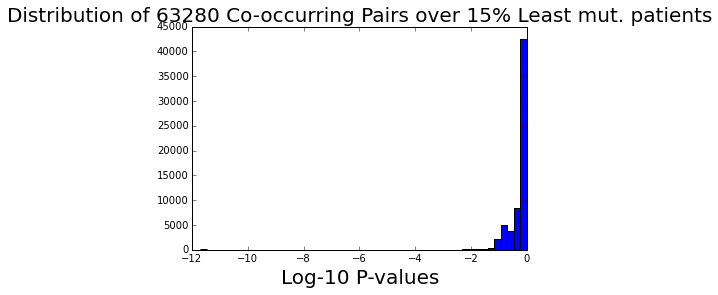

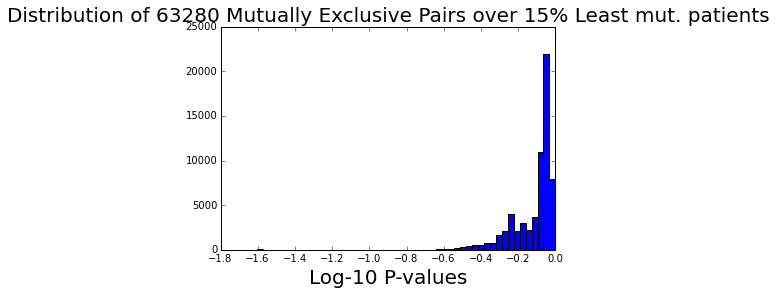

In [4]:
import matplotlib.pyplot as plt

%matplotlib inline
cpvalues = np.array([pairsdict[c]['1CBinomProb0'] for c in pairsdict])
logcp = np.log10(cpvalues)
mpvalues = np.array([pairsdict[c]['1MBinomProb0'] for c in pairsdict])
logmp = np.log10(mpvalues)


plt.figure()
plt.hist(logcp, bins=50)
plt.title("Distribution of " + str(len(logcp)) + " Co-occurring Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()

plt.figure()
plt.hist(logmp, bins=50)
plt.title("Distribution of " + str(len(logmp))  + " Mutually Exclusive Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()

# Set the cutoff of significant pairs to test over the whole distribution

In [5]:
cpairPercentile = 10
# Percentile of most significant co-occurring pairs to test

mpairPercentile = 10

# Visualize the cutoff
## Go back and adjust if you'd like!

Top  10 percent of cooccurring pairs:  0.158455495514
Top  10 percent of mutually exclusive pairs :  0.518582027045
Now number of mutex pairs to test  6821
Now number of coocurr pairs to test  6424
Number of genes  374


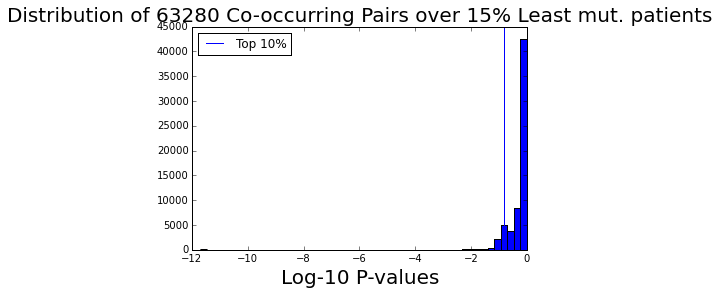

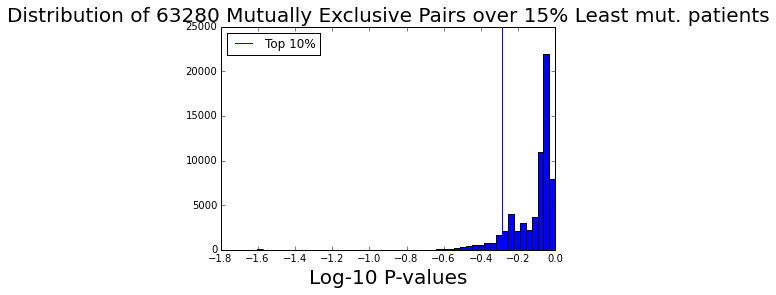

In [6]:
import matplotlib.pyplot as plt

%matplotlib inline
cpvalues = np.array([pairsdict[c]['1CBinomProb0'] for c in pairsdict])
logcp = np.log10(cpvalues)
mpvalues = np.array([pairsdict[c]['1MBinomProb0'] for c in pairsdict])
logmp = np.log10(mpvalues)


cthreshold = stats.scoreatpercentile(cpvalues, cpairPercentile)
mthreshold = stats.scoreatpercentile(mpvalues, mpairPercentile)
print "Top ", cpairPercentile, "percent of cooccurring pairs: ", cthreshold
print "Top ", mpairPercentile, "percent of mutually exclusive pairs : ", mthreshold

# Let's get the top 10 percent of pairs

goodcpairs = [c for c in pairsdict if (pairsdict[c]['1CBinomProb0'] <= cthreshold)]
goodmpairs = [c for c in pairsdict if (pairsdict[c]['1MBinomProb0'] <= mthreshold)]
goodpairs = goodcpairs + goodmpairs
goodgenes = set.union(*(set(goodpair) for goodpair in goodpairs))
print "Now number of mutex pairs to test ", len(goodmpairs)
print "Now number of coocurr pairs to test ", len(goodcpairs)
print "Number of genes ", len(goodgenes)

plt.figure()
plt.hist(logcp, bins=50)
plt.axvline(x= np.log10(cthreshold), label="Top " + str(cpairPercentile) + "%")
plt.title("Distribution of " + str(len(logcp)) + " Co-occurring Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()



plt.figure()
plt.hist(logmp, bins=50)
plt.axvline(x= np.log10(mthreshold), label="Top " + str(mpairPercentile) + "%")
plt.title("Distribution of " + str(len(logmp))  + " Mutually Exclusive Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()



### Test new pairs

In [7]:
print "Getting normal statistics across whole distribution"

new_mpairsdict, new_mgenedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, goodmpairs, compute_mutex=compute_mutex)
new_cpairsdict, new_cgenedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, goodcpairs, compute_mutex=compute_mutex)

print "Testing across the whole distribution"

new_mpairsdict = chi.add_BinomP_cohorts_all_pairs(new_mpairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)
new_cpairsdict = chi.add_BinomP_cohorts_all_pairs(new_cpairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)

new_pairsdict = new_mpairsdict.copy()
new_pairsdict.update(new_mpairsdict)


print "All tested pairs have been written to ", new_pairfile

fieldnames = (new_pairsdict.values()[0]).keys()
fieldnames.remove('MutationFrequencies')
fieldnames.remove('MutationFrequencyDifference')
fieldnames.remove('MutationFrequencyDifferenceRatio')
fieldnames.remove('CooccurrenceRatio')
fieldnames.remove('Coverage')
fieldnames.remove('SetScore')
fieldnames.remove('AverageOverlapPMN')
fieldnames.remove('CombinedScore')
fieldnames.remove('Concordance')
fieldnames.remove('Somatic')
fieldnames.remove('RoundedLogPCov')
fieldnames.remove('GeneSet')
fieldnames.remove('Type')

fieldnames.insert(2, 'Type')
fieldnames.insert(3, 'AllMBinomProb')
fieldnames.insert(3, 'AllCBinomProb')

met.writeanydict(new_pairsdict, new_pairfile, fieldnames=fieldnames)

os.system('say "whole distribution pairs finished"')

Getting normal statistics across whole distribution
Testing across the whole distribution
All tested pairs have been written to  output/BRCA_wustl-som-seg-jl-pairs-min_cohort_filtered.txt


0

### Plot results

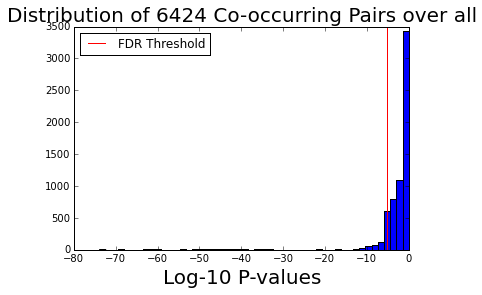

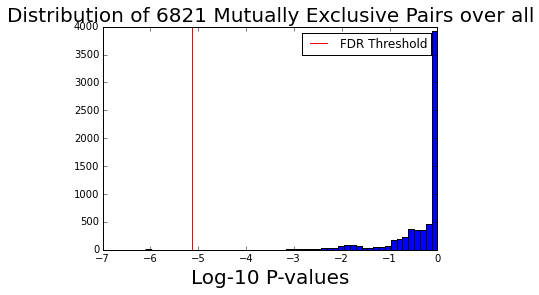

Number significant mutex 8
Number significant coocurr 775


In [8]:
import matplotlib.pyplot as plt

%matplotlib inline
# Left off here: jonathan
cpvalues = np.array([new_cpairsdict[c]['AllCBinomProb'] for c in new_cpairsdict])
logcp = np.log10(cpvalues)
mpvalues = np.array([new_mpairsdict[c]['AllMBinomProb'] for c in new_mpairsdict])
logmp = np.log10(mpvalues)

cthreshold = cpvaluethreshold/len(logcp)
mthreshold = mpvaluethreshold/len(logmp)
                            
plt.figure()
plt.hist(logcp, bins=50)
plt.axvline(x=np.log10(cthreshold), label="FDR Threshold", c='r')
plt.title("Distribution of " + str(len(logcp)) + " Co-occurring Pairs over all", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()

plt.figure()
plt.hist(logmp, bins=50)
plt.axvline(x=np.log10(mthreshold), label="FDR Threshold", c='r')
plt.title("Distribution of " + str(len(logmp))  + " Mutually Exclusive Pairs over all", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()


# filter all the pairs




        
# Split into mutex and cooccur
new_sig_m_dict = new_mpairsdict.copy()
new_sig_c_dict = new_cpairsdict.copy()

for pair in new_mpairsdict:
    if new_sig_m_dict[pair]['AllMBinomProb'] > mthreshold:
        new_sig_m_dict.pop(pair)

for pair in new_cpairsdict:
    if new_sig_c_dict[pair]['AllCBinomProb'] > cthreshold:
        new_sig_c_dict.pop(pair)
print "Number significant mutex", len(new_sig_m_dict)
print "Number significant coocurr", len(new_sig_c_dict)


new_sig_dict = new_sig_m_dict.copy()
new_sig_dict.update(new_sig_c_dict)
# new_sig_dict = new_pairsdict.copy()
# for pair in new_pairsdict:
#     if new_sig_dict[pair]['AllCBinomProb'] > cthreshold and new_sig_dict[pair]['AllMBinomProb'] > mthreshold:
#         new_sig_dict.pop(pair)

## Mutual exclusivity info

In [10]:


bgbp.write_segment_infos(goodgenes, segment_info_file)



print "*********MUTUAL EXCLUSIVITY INFO**********\n"

print len(new_sig_m_dict), " Mutually exclusive pairs"

mfieldnames = ['Gene0', 'Gene1', 'Gene0Cytobands', 'Gene1Cytobands', 'AllMBinomProb', 
                'AllFreqs', 'AllOverlap', 'AllSize','1MBinomProb0', '1Freqs0', '1Overlap0',
               '1Size0']


gene_m_dict = {}
cyto_m_dict = {}
cyto_pair_m_dict = {}

for pair in new_sig_m_dict:
    if new_sig_m_dict[pair]['Gene0'][-4:] in {'loss', 'gain'}:
        suffix0 = new_sig_m_dict[pair]['Gene0'][-4:]
    else:
        suffix0 = ""

    if new_sig_m_dict[pair]['Gene1'][-4:] in {'loss', 'gain'}:
        suffix1 = new_sig_m_dict[pair]['Gene1'][-4:]
    else:
        suffix1 = ""
    
    
    info0 = bgbp.get_segment_gene_info(new_sig_m_dict[pair]['Gene0'])
    new_sig_m_dict[pair]['Gene0Loc'] = str(info0['Chromosome']) + ':' + str(info0['Start'])
    info1 = bgbp.get_segment_gene_info(new_sig_m_dict[pair]['Gene1'])
    new_sig_m_dict[pair]['Gene1Loc'] = str(info1['Chromosome']) + ':' + str(info1['Start'])
    new_sig_m_dict[pair]['Gene0Cytobands'] = str(info0['Cytobands'])
    new_sig_m_dict[pair]['Gene1Cytobands'] = str(info1['Cytobands'])
    
    
    if new_sig_m_dict[pair]['Gene0'] not in gene_m_dict:
        gene_m_dict[new_sig_m_dict[pair]['Gene0']] = set()
    gene_m_dict[new_sig_m_dict[pair]['Gene0']].add(pair)
    if new_sig_m_dict[pair]['Gene1'] not in gene_m_dict:
        gene_m_dict[new_sig_m_dict[pair]['Gene1']] = set()
    gene_m_dict[new_sig_m_dict[pair]['Gene1']].add(pair)
    
    
    
    if str(info0['Cytobands']) + suffix0 not in cyto_m_dict:
        cyto_m_dict[str(info0['Cytobands']) + suffix0] = set()
    cyto_m_dict[str(info0['Cytobands']) + suffix0].add(pair)
    if str(info1['Cytobands']) + suffix1 not in cyto_m_dict:
        cyto_m_dict[str(info1['Cytobands']) + suffix1] = set()
    cyto_m_dict[str(info1['Cytobands']) + suffix1].add(pair)
    
    
    
    cyto_pair = frozenset([str(info0['Cytobands']) + suffix0, str(info1['Cytobands']) + suffix1])
    
    if cyto_pair not in cyto_pair_m_dict:
        cyto_pair_m_dict[cyto_pair] = set()
        
    cyto_pair_m_dict[cyto_pair].add(pair)


if new_sig_m_dict:
    for key in new_sig_m_dict[pair].keys():
        if key not in mfieldnames:
            mfieldnames.append(key)
    

orderedmpairs = sorted(new_sig_m_dict.keys(), key=lambda entry: (new_sig_m_dict[entry]['AllMBinomProb'],))
    
met.writeanydict(new_sig_m_dict, new_mpairfile, fieldnames=mfieldnames, orderedkeys=orderedmpairs)
print "updated with segment info ", new_mpairfile
!python add_COSMIC.py -ic Gene0 Gene1 -ip $COSMIC_pair_insertion_index -i $new_mpairfile -o $new_mpairfile
print "updated with COSMIC info ", new_mpairfile


# Writing gene infos
    

sorted_genes = sorted(gene_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytobands = sorted(cyto_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytotuples = sorted(cyto_pair_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)

print "\n**********SINGLE GENES**********"
print_length = 15
for gene in sorted_genes:
    if len(gene[0]) <= print_length + 4:
        print gene[0], "has", len(gene[1])
    else:
        print gene[0][0:print_length] + gene[0][-4:], "has\t", len(gene[1])

print "\n**********SINGLE CYTOBANDS**********"
for cytoband in sorted_cytobands:
    print cytoband[0], "has", len(cytoband[1])

print "\n**********PAIRED CYTOBANDS**********"
for cytotuple in sorted_cytotuples:
    print  cytotuple[0], "has", len(cytotuple[1])


os.system('say "finished"')

*********MUTUAL EXCLUSIVITY INFO**********

8  Mutually exclusive pairs
updated with segment info  output/BRCA_wustl-som-seg-jl-mpairs-min_cohort_filtered.txt
updated with COSMIC info  output/BRCA_wustl-som-seg-jl-mpairs-min_cohort_filtered.txt

**********SINGLE GENES**********
MAP3K1 has 7
CCDC144NLloss has 1
PIK3CA has 1
TOM1L2_LRRC48_Aloss has	1
SLC5A10_FAM83G_loss has	1
SCN8A_ANKRD33_Aloss has	1
B9D1_MIR1180_MAloss has	1
USP22loss has 1
MAP2K3loss has 1
SPECC1loss has 1

**********SINGLE CYTOBANDS**********
['5q11.2'] has 7
['17p11.2']loss has 7
['3q26.33'] has 1
['12q13.13']loss has 1

**********PAIRED CYTOBANDS**********
frozenset(["['5q11.2']", "['17p11.2']loss"]) has 7
frozenset(["['3q26.33']", "['12q13.13']loss"]) has 1


0

# Draw mutual exclusivity network

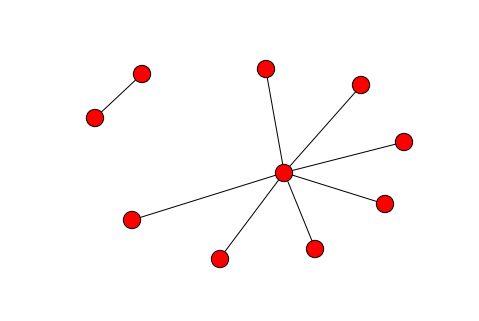


***********************
COMPONENT 0
***********************
Number of nodes  8
Number of edges  7
---
Top 3 nodes by degree centraliy in component 0
Gene: Degree Centrality   Degree
MAP3K1 : 1.0 7
CCDC144NLloss : 0.14 1
TOM1L2_LRRC48_ATPAF2_GID4_DRG2_MYO15A_ALKBH5_LLGL1_FLII_TOP3A_SMCR8_SHMT1loss : 0.14 1
---
Writing nodes to:  output/BRCA_wustl-som-seg-jl-mpairs-min_cohort_filtered_network_comp0.txt

***********************
COMPONENT 1
***********************
Number of nodes  2
Number of edges  1
---
Top 3 nodes by degree centraliy in component 1
Gene: Degree Centrality   Degree
PIK3CA : 1.0 1
SCN8A_ANKRD33_ACVRL1_ACVR1B_GRASP_NR4A1_OR7E47P_KRT80_C12orf80_LINC00592_KRT7_KRT86_KRT81_KRT83_KRT85_KRT84_KRT82_KRT75_KRT6B_KRT6C_KRT6A_KRT5_KRT71_KRT74_KRT72_KRT73_KRT2_KRT1_KRT77_KRT76_KRT3_KRT4_KRT79_KRT78_KRT8_KRT18_EIF4B_SPRYD3_IGFBP6_SOAT2_CSAD_ZNF740_ITGB7_RARG_MFSD5_ESPL1_PFDN5_C12orf10_AAAS_SP7_SP1_AMHR2_PRR13_PCBP2_MAP3K12_TARBP2_NPFF_ATF7_ATP5G2_CALCOCO1_RN7SKP289_HOXC13_HOXC12_HOT

In [12]:
import networkx as nx
import csv

G=nx.Graph()
for pair in new_sig_m_dict:
    pair_type = new_sig_m_dict[pair]['Type']
    
    G.add_edge(tuple(pair)[0], tuple(pair)[1], {"Type": pair_type})

pos = nx.spring_layout(G)
nx.draw(G, pos)

# show graph
plt.show()

graphs = list(nx.connected_component_subgraphs(G))

top_number = 3

for i in range(len(graphs)):
    print "\n***********************"
    print "COMPONENT " + str(i) 
    print "***********************"
    graph = graphs[i]
    print "Number of nodes ", graph.number_of_nodes()
    print "Number of edges ", graph.number_of_edges()
    
    node_items = [g + (graph.degree(g[0]),) for g in nx.degree_centrality(graph).items()]
    node_items = sorted(node_items, key=lambda entry: entry[1], reverse = True)
    

    print "---"
    print "Top", top_number, "nodes by degree centraliy in component", i
    print "Gene: Degree Centrality   Degree"
    for j in range(min(top_number, len(node_items))):
        print node_items[j][0], ":", np.round(node_items[j][1], 2), node_items[j][2]
    
    component_file = network_m_file[:-4] + "_comp" + str(i) + ".txt"
    
    print "---"
    print "Writing nodes to: ", component_file
    with open(component_file, 'w') as csvfile:
        writer = csv.writer(csvfile, delimiter='\t')
        writer.writerow(["Node", "Degreee Centrality", "Degree"])
        for node_item in node_items:
            writer.writerow(node_item)

## Co-occurrence info

In [13]:
bgbp.write_segment_infos(goodgenes, segment_info_file)




print "*********COOCCURRENCE INFO**********\n"

print len(new_sig_c_dict), " Co-occurring pairs"

cfieldnames = ['Gene0', 'Gene1', 'Gene0Cytobands', 'Gene1Cytobands', 'AllCBinomProb', 
               'AllFreqs', 'AllOverlap', 'AllSize','1CBinomProb0', '1Freqs0', '1Overlap0',
               '1Size0']


gene_c_dict = {}
cyto_c_dict = {}
cyto_pair_c_dict = {}

for pair in new_sig_c_dict:
    if new_sig_c_dict[pair]['Gene0'][-4:] in {'loss', 'gain'}:
        suffix0 = new_sig_c_dict[pair]['Gene0'][-4:]
    else:
        suffix0 = ""

    if new_sig_c_dict[pair]['Gene1'][-4:] in {'loss', 'gain'}:
        suffix1 = new_sig_c_dict[pair]['Gene1'][-4:]
    else:
        suffix1 = ""
    
    
    info0 = bgbp.get_segment_gene_info(new_sig_c_dict[pair]['Gene0'])
    new_sig_c_dict[pair]['Gene0Loc'] = str(info0['Chromosome']) + ':' + str(info0['Start'])
    info1 = bgbp.get_segment_gene_info(new_sig_c_dict[pair]['Gene1'])
    new_sig_c_dict[pair]['Gene1Loc'] = str(info1['Chromosome']) + ':' + str(info1['Start'])
    new_sig_c_dict[pair]['Gene0Cytobands'] = str(info0['Cytobands'])
    new_sig_c_dict[pair]['Gene1Cytobands'] = str(info1['Cytobands'])
    
    
    if new_sig_c_dict[pair]['Gene0'] not in gene_c_dict:
        gene_c_dict[new_sig_c_dict[pair]['Gene0']] = set()
    gene_c_dict[new_sig_c_dict[pair]['Gene0']].add(pair)
    if new_sig_c_dict[pair]['Gene1'] not in gene_c_dict:
        gene_c_dict[new_sig_c_dict[pair]['Gene1']] = set()
    gene_c_dict[new_sig_c_dict[pair]['Gene1']].add(pair)
    
    
    
    if str(info0['Cytobands']) + suffix0 not in cyto_c_dict:
        cyto_c_dict[str(info0['Cytobands']) + suffix0] = set()
    cyto_c_dict[str(info0['Cytobands']) + suffix0].add(pair)
    if str(info1['Cytobands']) + suffix1 not in cyto_c_dict:
        cyto_c_dict[str(info1['Cytobands']) + suffix1] = set()
    cyto_c_dict[str(info1['Cytobands']) + suffix1].add(pair)
    
    
    
    cyto_pair = frozenset([str(info0['Cytobands']) + suffix0, str(info1['Cytobands']) + suffix1])
    
    if cyto_pair not in cyto_pair_c_dict:
        cyto_pair_c_dict[cyto_pair] = set()
        
    cyto_pair_c_dict[cyto_pair].add(pair)
    
# Writing to file
if new_sig_c_dict:
    for key in new_sig_c_dict[pair].keys():
        if key not in cfieldnames:
            cfieldnames.append(key)
    
orderedcpairs = sorted(new_sig_c_dict.keys(), key=lambda entry: (new_sig_c_dict[entry]['AllCBinomProb'],))
    
met.writeanydict(new_sig_c_dict, new_cpairfile, fieldnames=cfieldnames, orderedkeys=orderedcpairs)
print "updated with segment info ", new_cpairfile
!python add_COSMIC.py -ic Gene0 Gene1 -ip $COSMIC_pair_insertion_index -i $new_cpairfile -o $new_cpairfile
print "updated with COSMIC info ", new_cpairfile


# Writing gene infos
    

sorted_genes = sorted(gene_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytobands = sorted(cyto_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytotuples = sorted(cyto_pair_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)

print "\n**********SINGLE GENES**********"
print_length = 15
for gene in sorted_genes:
    if len(gene[0]) <= print_length + 4:
        print gene[0], "has", len(gene[1])
    else:
        print gene[0][0:print_length] + gene[0][-4:], "has\t", len(gene[1])

print "\n**********SINGLE CYTOBANDS**********"
for cytoband in sorted_cytobands:
    print cytoband[0], "has", len(cytoband[1])

print "\n**********PAIRED CYTOBANDS**********"
for cytotuple in sorted_cytotuples:
    print  cytotuple[0], "has", len(cytotuple[1])


os.system('say "finished"')

*********COOCCURRENCE INFO**********

775  Co-occurring pairs
updated with segment info  output/BRCA_wustl-som-seg-jl-cpairs-min_cohort_filtered.txt
updated with COSMIC info  output/BRCA_wustl-som-seg-jl-cpairs-min_cohort_filtered.txt

**********SINGLE GENES**********
FKSG52_PART1_DEloss has	49
SNORD22loss has 48
PDE4Dloss has 47
MIR582loss has 46
PLK2_GAPT_MIR54loss has	45
PIK3R1_SLC30A5_loss has	45
MAP3K1_SETD9_MIloss has	43
HTR1A_RNF180_RGloss has	42
MAST4_CD180loss has 42
KCNQ1DNloss has 39
RN7SL811Ploss has 36
NAA38loss has 36
OR4F17_PPAP2C_Mloss has	33
TRPC2_ART5_ART1loss has	33
RN7SL605Ploss has 27
BET1L_SCGB1C1_Oloss has	27
TP53 has 24
ESM1_GZMK_GZMA_loss has	20
FAM230Closs has 19
TOPAZ1_TCAIM_LIloss has	17
ADM_AMPD3_RNU6Aloss has	15
GALNT18_CSNK2A3loss has 15
SBF2loss has 15
LIPJ_LIPF_LIPK_loss has	15
MIR4299_USP47_Dloss has	15
SCN8A_ANKRD33_Aloss has	15
LHX2_NEK6_PSMB7loss has	15
RN7SKP67_DCTD_Floss has	12
ZFP42_TRIML2_TRloss has	11
RN7SKP13loss has 11
TENM3_MIR1305loss has 1

0

# Draw co-occurrence network

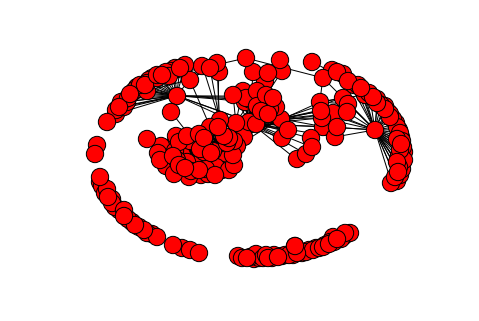


***********************
COMPONENT 0
***********************
Number of nodes  174
Number of edges  681
---
Top 3 nodes by degree centraliy in component 0
Gene: Degree Centrality   Degree
FKSG52_PART1_DEPDC1B_ELOVL7_ERCC8_NDUFAF2_SMIM15_ZSWIM6_C5orf64_RN7SKP157_KIF2A_DIMT1_IPO11_LRRC70loss : 0.28 49
SNORD22loss : 0.28 48
PDE4Dloss : 0.27 47
---
Writing nodes to:  output/BRCA_wustl-som-seg-jl-cpairs-min_cohort_filtered_network_comp0.txt

***********************
COMPONENT 1
***********************
Number of nodes  37
Number of edges  71
---
Top 3 nodes by degree centraliy in component 1
Gene: Degree Centrality   Degree
RN7SL811Ploss : 1.0 36
NAA38loss : 1.0 36
KCND2_TSPAN12_ING3_RNA5SP240_CPED1_RNA5SP241_WNT16_FAM3C_RN7SKP277_PTPRZ1_AASS_FEZF1_CADPS2_RNF133_RNF148_TAS2R16_SLC13A1_IQUB_NDUFA5_ASB15_LMOD2_WASL_HYAL4_SPAM1_TMEM229A_GPR37_POT1loss : 0.06 2
---
Writing nodes to:  output/BRCA_wustl-som-seg-jl-cpairs-min_cohort_filtered_network_comp1.txt

***********************
COMPONENT 2
****

In [15]:
import networkx as nx
import csv

G=nx.Graph()
for pair in new_sig_c_dict:
    pair_type = new_sig_c_dict[pair]['Type']
    
    G.add_edge(tuple(pair)[0], tuple(pair)[1], {"Type": pair_type})

pos = nx.spring_layout(G)
nx.draw(G, pos)

# show graph
plt.show()

graphs = list(nx.connected_component_subgraphs(G))

top_number = 3

for i in range(len(graphs)):
    print "\n***********************"
    print "COMPONENT " + str(i) 
    print "***********************"
    graph = graphs[i]
    print "Number of nodes ", graph.number_of_nodes()
    print "Number of edges ", graph.number_of_edges()
    
    node_items = [g + (graph.degree(g[0]),) for g in nx.degree_centrality(graph).items()]
    node_items = sorted(node_items, key=lambda entry: entry[1], reverse = True)
    

    print "---"
    print "Top", top_number, "nodes by degree centraliy in component", i
    print "Gene: Degree Centrality   Degree"
    for j in range(min(top_number, len(node_items))):
        print node_items[j][0], ":", np.round(node_items[j][1], 2), node_items[j][2]
    
    component_file = network_c_file[:-4] + "_comp" + str(i) + ".txt"
    
    print "---"
    print "Writing nodes to: ", component_file
    with open(component_file, 'w') as csvfile:
        writer = csv.writer(csvfile, delimiter='\t')
        writer.writerow(["Node", "Degreee Centrality", "Degree"])
        for node_item in node_items:
            writer.writerow(node_item)

## Search for triplets from among the pairs

In [14]:
# Search for triplets
import mutex_triangles as met
import edgereader as edg


        
    
    
# Search for triplets
import mutex_triangles as met
import edgereader as edg

genedict = edg.get_gene_dict(new_sig_dict)
Triplets, pairsdict_Triplets, sorted_pairs, genesdict_Triplets, sorted_genes = met.getTriplets(new_sig_dict, genedict, new_sig_dict, numCases, geneToCases=geneToCases, patientToGenes=patientToGenes)
Triplet_dict = met.sort_triplets_by_type(Triplets)

for t_type in Triplet_dict:
    print len(Triplet_dict[t_type]), " of type ",  t_type
    Triplet_dict[t_type] = sorted(Triplet_dict[t_type], key=lambda entry: entry.stats['Count'], reverse=True)
    triplet_file_name = triplet_output_prefix + t_type + '.txt'
    met.writeTriplets2(Triplet_dict[t_type], triplet_file_name)
    !python add_COSMIC.py -ic Gene0 Gene1 Gene2 -ip $COSMIC_triplet_insertion_index -i $triplet_file_name -o $triplet_file_name
    print "updated with COSMIC info ", triplet_file_name
    
    
    
    print "*********" + str(t_type) + "INFO**********\n"
    gene_t_dict = {}
    cyto_t_dict = {}
    cyto_trip_t_dict = {}
    
    
    # LEFT OFF HERE-JLU
    
    for triplet in Triplet_dict[t_type]:
        genes = triplet.genes
        suffixes = [gene[-4:] if gene[-4:] in {'loss', 'gain'} else "" for gene in genes]
        
        cytobands = set([str(bgbp.get_segment_gene_info(gene)['Cytobands']) for gene, suffix in zip(genes, suffixes)])
        
        for gene in genes:
            if gene not in gene_t_dict:
                gene_t_dict[gene] = set()
            gene_t_dict[gene].add(frozenset(genes.difference(set([gene]))))
    
        
        for cytoband in cytobands:
            if cytoband not in cyto_t_dict:
                cyto_t_dict[cytoband] = set()
            cyto_t_dict[cytoband].add(frozenset(cytobands.difference(set([cytoband]))))
    
        if frozenset(cytobands) not in cyto_trip_t_dict:
            cyto_trip_t_dict[frozenset(cytobands)] = set()
            
        cyto_trip_t_dict[frozenset(cytobands)].add(frozenset(genes))
    
    
    

    sorted_genes = sorted(gene_t_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
    sorted_cytobands = sorted(cyto_t_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
    sorted_cytotuples = sorted(cyto_trip_t_dict.items(), key = lambda entry: len(entry[1]), reverse=True)

    print "\n**********SINGLE GENES**********"
    print_length = 15
    for gene in sorted_genes:
        if len(gene[0]) <= print_length + 4:
            print gene[0], "has", len(gene[1])
        else:
            print gene[0][0:print_length] + gene[0][-4:], "has\t", len(gene[1])

    print "\n**********SINGLE CYTOBANDS**********"
    for cytoband in sorted_cytobands:
        print cytoband[0], "has", len(cytoband[1])

    print "\n**********PAIRED CYTOBANDS**********"
    for cytotuple in sorted_cytotuples:
        print  cytotuple[0], "has", len(cytotuple[1])


    os.system('say "finished"')



number of pairs  783
Pair info of triplets initialized
339  triplets calculated in  0.216156959534
Including sorting time  0.217441082001
339  of type  CooccurringCooccurringCooccurring
Triplets written to  output/BRCA_wustl-som-seg-jl-triplets-CooccurringCooccurringCooccurring.txt
updated with COSMIC info  output/BRCA_wustl-som-seg-jl-triplets-CooccurringCooccurringCooccurring.txt
*********CooccurringCooccurringCooccurringINFO**********


**********SINGLE GENES**********
KCNQ1DNloss has 128
TP53 has 114
TRPC2_ART5_ART1loss has	58
BET1L_SCGB1C1_Oloss has	56
SCN8A_ANKRD33_Aloss has	54
LHX2_NEK6_PSMB7loss has	54
RN7SL811Ploss has 35
NAA38loss has 35
OR4F17_PPAP2C_Mloss has	31
RN7SL605Ploss has 25
MAP3K1_SETD9_MIloss has	20
MIR582loss has 20
PDE4Dloss has 20
HTR1A_RNF180_RGloss has	20
PLK2_GAPT_MIR54loss has	20
PIK3R1_SLC30A5_loss has	20
ESM1_GZMK_GZMA_loss has	20
FKSG52_PART1_DEloss has	20
MAST4_CD180loss has 20
ADM_AMPD3_RNU6Aloss has	12
GALNT18_CSNK2A3loss has 12
SBF2loss has 12
MIR429

# ----------------------------------------------------------------------
# BRCA WUSTL SNV + SEGMENT GAIN LOSS RUNS
# ----------------------------------------------------------------------

# Set parameters

In [18]:
mutationmatrix = '/Users/jlu96/maf/new/BRCA_wustl/BRCA_wustl-som-seg-gl.m2'
# Set to name of tab-delimited matrix file. First column of each row should be Patient ID. Remaining row entries are names of present mutations

patientFile = '/Users/jlu96/maf/new/BRCA_wustl/shared_patients.plst'
# Text file with patient names. Set to None to use all the patients.


output_prefix =  "output/BRCA_wustl-som-seg-gl"

# Prefix for the following output filenames:
pairfile = output_prefix + 'pairs-min_cohort.txt' #Pair statistics within the least mutated patients
new_pairfile = output_prefix + "-pairs-min_cohort_filtered.txt" #Pair statistics over all patients
new_cpairfile = output_prefix + "-cpairs-min_cohort_filtered.txt" #Co-occurringPair statistics over all patients
new_mpairfile = output_prefix + "-mpairs-min_cohort_filtered.txt"#Mutually exclusive Pair statistics over all patients
triplet_output_prefix = output_prefix + '-triplets-'
network_c_file = new_cpairfile[:-4] + "_network.txt"
network_m_file = new_mpairfile[:-4] + "_network.txt"
segment_info_file = output_prefix + "segment_info.txt" # Name of file to write segmentation information to



leastPatientThreshold = 15
# To choose which genes to test, first consider only the patients below this percentile. e.g. if set to 50, the bottom 50% of patients
# are called least mutated.

test_gene_threshold = 5
# Test genes that are mutated in at least this percentage of the least mutated patients.


geneFile = None
# Only load genes listed in this file

minFreq = 0
# Minimum gene mutation frequency


closer_than_distance = 100000000
# Minimum distance between genes to test them, in bp.


cpvaluethreshold = 0.05
# FDR threshold for c-pvalues.

mpvaluethreshold = 0.05
# FDR threshold for mutually exclusive pairs.


# 1) Plot the distribution of mutations across genes and across patients
# 2) Plot distribution over the least mutated patients
# 3) Generate the gene pairs to be tested

A good rule of thumb is to 

21479 genes x 963 patients
*******************************************************************
*                   PLOT MUTATION DISTRIBUTIONS                   *
*******************************************************************
GENE MUTATION DISTRIBUTION


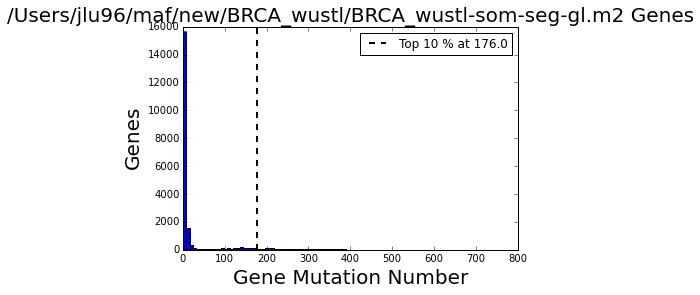

Zoomed into bottom 95 percent region


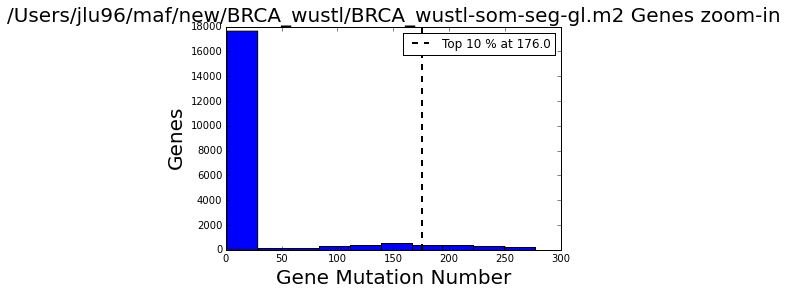


PATIENT MUTATION DISTRIBUTION


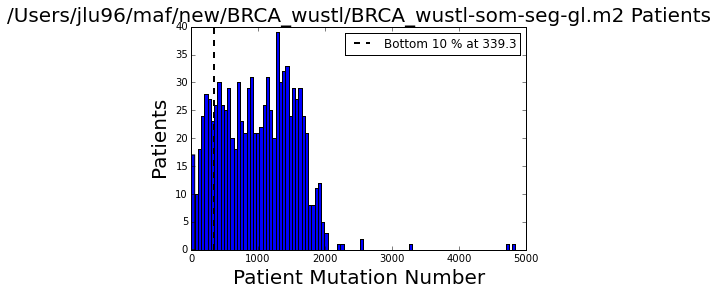

Zoomed into bottom 95 percent region


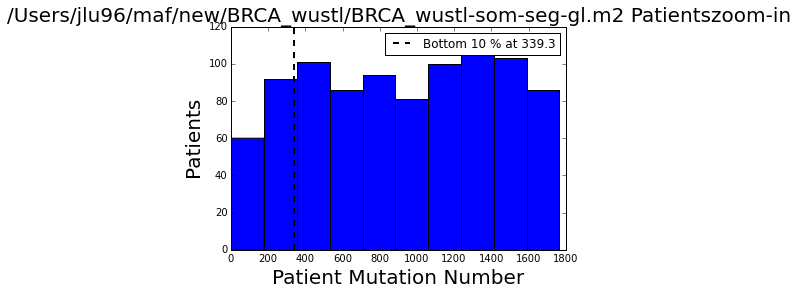

*******************************************************************
*         PLOT DISTRIBUTIONS AMONG LEAST MUTATED PATIENTS         *
*******************************************************************
GENE MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS


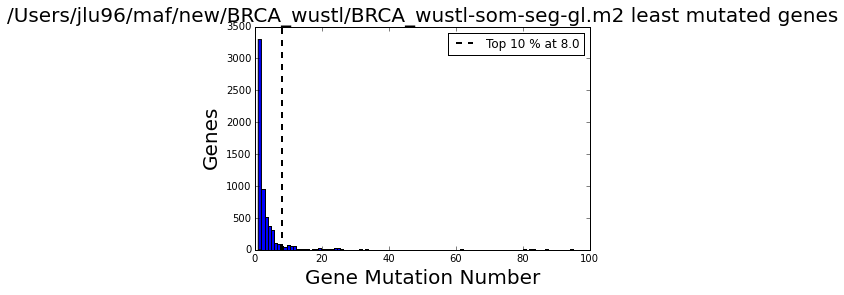


PATIENT MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS


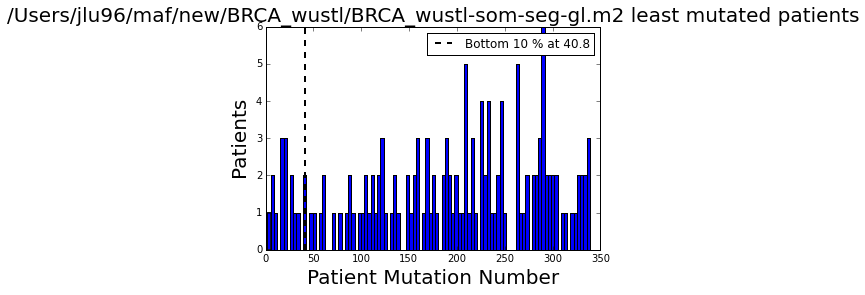

*******************************************************************
*                   GETTING TEST GENE PAIRS                       *
*******************************************************************
The least mutated patients are the bottom  15  % of patients
Least mutated patients: 6281 genes x 145 patients
The test gene threshold is  5 % of the least mutated patients
Test genes are mutated at least  7  in th least mutated patients
Number of test genes:  731
Number of pairs to test:  234222
Number of pairs is  234222  retrieved in time :  17.9709630013


0

In [19]:
import mutex as mex
import csv
import mutex_triangles as met
import chisquared as chi
import bingenesbypairs as bgbp
import time
import os
import scipy.stats as stats
import partition as par
import numpy as np
%matplotlib inline

COSMIC_pair_insertion_index = 8
COSMIC_triplet_insertion_index = 5
compute_mutex = True

numGenes, numCases, genes, patients, geneToCases, patientToGenes = mex.load_mutation_data(mutationmatrix, patientFile, geneFile, minFreq)

print '%s genes x %s patients' % (numGenes, numCases)


print "*******************************************************************"
print "*                   PLOT MUTATION DISTRIBUTIONS                   *"
print "*******************************************************************"

print "GENE MUTATION DISTRIBUTION"
mex.graph_mutation_distribution(numCases, genes, geneToCases, filename=mutationmatrix + " Genes", bins=100, zoomin_percentile=95)


print "\nPATIENT MUTATION DISTRIBUTION"
mex.graph_patient_distribution(len(genes), patients, patientToGenes, mutationmatrix + " Patients", bottom_percentile=leastPatientThreshold, zoomin_percentile=95)


print "*******************************************************************"
print "*         PLOT DISTRIBUTIONS AMONG LEAST MUTATED PATIENTS         *"
print "*******************************************************************"




D = [len(patientToGenes[p]) for p in patientToGenes]
minThreshold = stats.scoreatpercentile(D, leastPatientThreshold)

c0patients = [p for p in patientToGenes if len(patientToGenes[p]) <= minThreshold]

c0cohort_dict = {0: c0patients}

c0genes, c0geneToCases, c0patientToGenes = par.get_cluster_gTC_pTG(geneToCases, patientToGenes, c0patients)

print "GENE MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS"
mex.graph_mutation_distribution(len(c0patients), c0genes, c0geneToCases, filename=mutationmatrix + " least mutated genes", bins=100)

print "\nPATIENT MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS"
mex.graph_patient_distribution(len(genes), c0patients, c0patientToGenes, filename=mutationmatrix + " least mutated patients")



print "*******************************************************************"
print "*                   GETTING TEST GENE PAIRS                       *"
print "*******************************************************************"
print "The least mutated patients are the bottom ", leastPatientThreshold, " % of patients"
print "Least mutated patients: %s genes x %s patients" % (len(c0genes), len(c0patients) )


test_minFreq = int( test_gene_threshold * 0.01 * len(c0patients))
print "The test gene threshold is ", test_gene_threshold, "% of the least mutated patients"
print "Test genes are mutated at least ", test_minFreq, " in th least mutated patients"

print "Number of test genes: ", len([g for g in c0genes if len(c0geneToCases[g]) >= test_minFreq])


reload(bgbp)
t = time.time()
genepairs = bgbp.getgenepairs(c0geneToCases, c0genes, test_minFreq=test_minFreq, closer_than_distance=closer_than_distance)
print "Number of pairs is ", len(genepairs), " retrieved in time : ", time.time() - t

os.system('say "exploration finished"')

## Perform statistical tests of each of the pairs
### This cell's runtime is usually about (number of pairs)/ 900 seconds.

In [20]:
print "Getting normal statistics..."
t = time.time()
pairsdict, genedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, genepairs, compute_mutex=compute_mutex)
print "Finished in ", time.time() - t

print "Testing among least mutated patients..."
t = time.time()
pairsdict = chi.add_BinomP_cohorts_all_pairs(pairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)
print "Finished in ", time.time() - t
print "All pairs tested in least mutated patients written to ",  pairfile

fieldnames = (pairsdict.values()[0]).keys()
fieldnames.remove('MutationFrequencies')
fieldnames.remove('MutationFrequencyDifference')
fieldnames.remove('MutationFrequencyDifferenceRatio')
fieldnames.remove('CooccurrenceRatio')
fieldnames.remove('Coverage')
fieldnames.remove('SetScore')
fieldnames.remove('AverageOverlapPMN')
fieldnames.remove('CombinedScore')
fieldnames.remove('Concordance')
fieldnames.remove('Somatic')
fieldnames.remove('RoundedLogPCov')
fieldnames.remove('GeneSet')
fieldnames.remove('Type')


fieldnames.insert(2, 'Type')
fieldnames.insert(3, '1CBinomProb0')
fieldnames.insert(3, '1MBinomProb0')

met.writeanydict(pairsdict, pairfile, fieldnames=fieldnames)
print "Pairs in least mutated patients finished"
os.system('say "Pairs in least mutated patients finished"')



Getting normal statistics...
Finished in  337.05513382
Testing among least mutated patients...
Finished in  1818.66015697
All pairs tested in least mutated patients written to  output/BRCA_wustl-som-seg-glpairs-min_cohort.txt
Pairs in least mutated patients finished


0

# Plot the distribution of p-values.

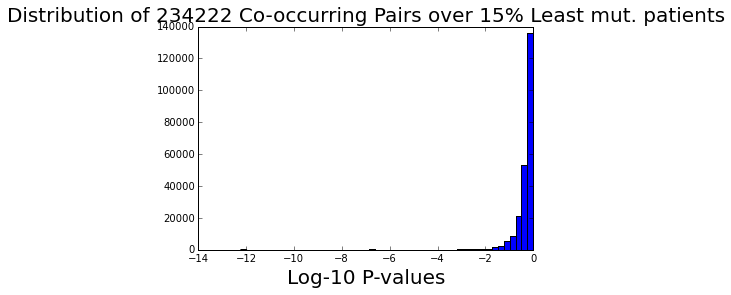

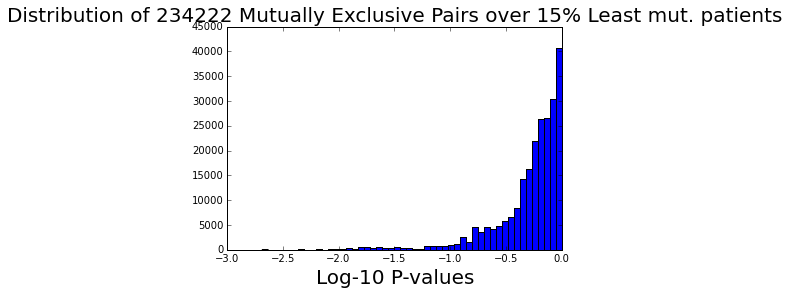

In [21]:
import matplotlib.pyplot as plt

%matplotlib inline
cpvalues = np.array([pairsdict[c]['1CBinomProb0'] for c in pairsdict])
logcp = np.log10(cpvalues)
mpvalues = np.array([pairsdict[c]['1MBinomProb0'] for c in pairsdict])
logmp = np.log10(mpvalues)


plt.figure()
plt.hist(logcp, bins=50)
plt.title("Distribution of " + str(len(logcp)) + " Co-occurring Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()

plt.figure()
plt.hist(logmp, bins=50)
plt.title("Distribution of " + str(len(logmp))  + " Mutually Exclusive Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()

# Set the cutoff of significant pairs to test over the whole distribution

In [22]:
cpairPercentile = 10
# Percentile of most significant co-occurring pairs to test

mpairPercentile = 10

# Visualize the cutoff
## Go back and adjust if you'd like!

Top  10 percent of cooccurring pairs:  0.182634792957
Top  10 percent of mutually exclusive pairs :  0.201509302185
Now number of mutex pairs to test  24058
Now number of coocurr pairs to test  23444
Number of genes  729


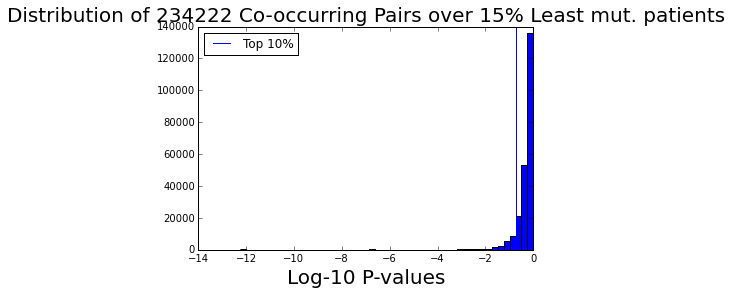

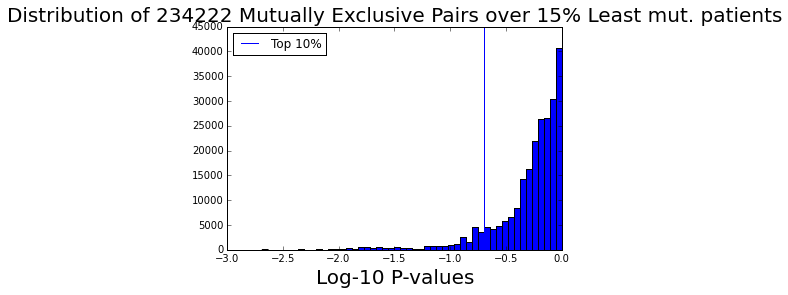

In [23]:
import matplotlib.pyplot as plt

%matplotlib inline
cpvalues = np.array([pairsdict[c]['1CBinomProb0'] for c in pairsdict])
logcp = np.log10(cpvalues)
mpvalues = np.array([pairsdict[c]['1MBinomProb0'] for c in pairsdict])
logmp = np.log10(mpvalues)


cthreshold = stats.scoreatpercentile(cpvalues, cpairPercentile)
mthreshold = stats.scoreatpercentile(mpvalues, mpairPercentile)
print "Top ", cpairPercentile, "percent of cooccurring pairs: ", cthreshold
print "Top ", mpairPercentile, "percent of mutually exclusive pairs : ", mthreshold

# Let's get the top 10 percent of pairs

goodcpairs = [c for c in pairsdict if (pairsdict[c]['1CBinomProb0'] <= cthreshold)]
goodmpairs = [c for c in pairsdict if (pairsdict[c]['1MBinomProb0'] <= mthreshold)]
goodpairs = goodcpairs + goodmpairs
goodgenes = set.union(*(set(goodpair) for goodpair in goodpairs))
print "Now number of mutex pairs to test ", len(goodmpairs)
print "Now number of coocurr pairs to test ", len(goodcpairs)
print "Number of genes ", len(goodgenes)

plt.figure()
plt.hist(logcp, bins=50)
plt.axvline(x= np.log10(cthreshold), label="Top " + str(cpairPercentile) + "%")
plt.title("Distribution of " + str(len(logcp)) + " Co-occurring Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()



plt.figure()
plt.hist(logmp, bins=50)
plt.axvline(x= np.log10(mthreshold), label="Top " + str(mpairPercentile) + "%")
plt.title("Distribution of " + str(len(logmp))  + " Mutually Exclusive Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()



### Test new pairs

In [24]:
print "Getting normal statistics across whole distribution"

new_mpairsdict, new_mgenedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, goodmpairs, compute_mutex=compute_mutex)
new_cpairsdict, new_cgenedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, goodcpairs, compute_mutex=compute_mutex)

print "Testing across the whole distribution"

new_mpairsdict = chi.add_BinomP_cohorts_all_pairs(new_mpairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)
new_cpairsdict = chi.add_BinomP_cohorts_all_pairs(new_cpairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)

new_pairsdict = new_mpairsdict.copy()
new_pairsdict.update(new_mpairsdict)


print "All tested pairs have been written to ", new_pairfile

fieldnames = (new_pairsdict.values()[0]).keys()
fieldnames.remove('MutationFrequencies')
fieldnames.remove('MutationFrequencyDifference')
fieldnames.remove('MutationFrequencyDifferenceRatio')
fieldnames.remove('CooccurrenceRatio')
fieldnames.remove('Coverage')
fieldnames.remove('SetScore')
fieldnames.remove('AverageOverlapPMN')
fieldnames.remove('CombinedScore')
fieldnames.remove('Concordance')
fieldnames.remove('Somatic')
fieldnames.remove('RoundedLogPCov')
fieldnames.remove('GeneSet')
fieldnames.remove('Type')

fieldnames.insert(2, 'Type')
fieldnames.insert(3, 'AllMBinomProb')
fieldnames.insert(3, 'AllCBinomProb')

met.writeanydict(new_pairsdict, new_pairfile, fieldnames=fieldnames)

os.system('say "whole distribution pairs finished"')

Getting normal statistics across whole distribution
Testing across the whole distribution
All tested pairs have been written to  output/BRCA_wustl-som-seg-gl-pairs-min_cohort_filtered.txt


256

### Plot results

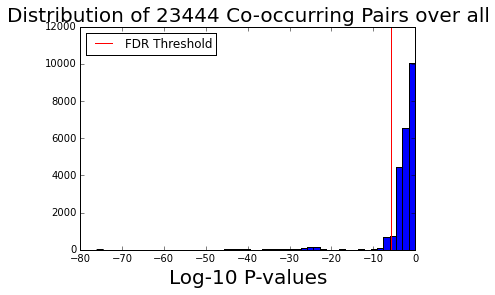

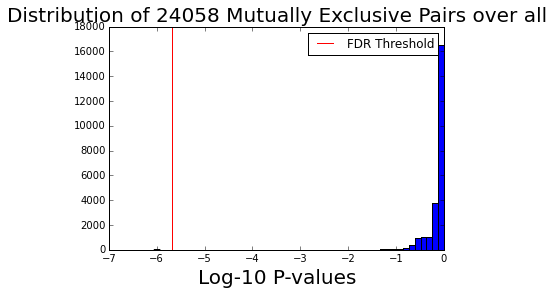

Number significant mutex 1
Number significant coocurr 1789


In [25]:
import matplotlib.pyplot as plt

%matplotlib inline
# Left off here: jonathan
cpvalues = np.array([new_cpairsdict[c]['AllCBinomProb'] for c in new_cpairsdict])
logcp = np.log10(cpvalues)
mpvalues = np.array([new_mpairsdict[c]['AllMBinomProb'] for c in new_mpairsdict])
logmp = np.log10(mpvalues)

cthreshold = cpvaluethreshold/len(logcp)
mthreshold = mpvaluethreshold/len(logmp)
                            
plt.figure()
plt.hist(logcp, bins=50)
plt.axvline(x=np.log10(cthreshold), label="FDR Threshold", c='r')
plt.title("Distribution of " + str(len(logcp)) + " Co-occurring Pairs over all", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()

plt.figure()
plt.hist(logmp, bins=50)
plt.axvline(x=np.log10(mthreshold), label="FDR Threshold", c='r')
plt.title("Distribution of " + str(len(logmp))  + " Mutually Exclusive Pairs over all", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()


# filter all the pairs




        
# Split into mutex and cooccur
new_sig_m_dict = new_mpairsdict.copy()
new_sig_c_dict = new_cpairsdict.copy()

for pair in new_mpairsdict:
    if new_sig_m_dict[pair]['AllMBinomProb'] > mthreshold:
        new_sig_m_dict.pop(pair)

for pair in new_cpairsdict:
    if new_sig_c_dict[pair]['AllCBinomProb'] > cthreshold:
        new_sig_c_dict.pop(pair)
print "Number significant mutex", len(new_sig_m_dict)
print "Number significant coocurr", len(new_sig_c_dict)


new_sig_dict = new_sig_m_dict.copy()
new_sig_dict.update(new_sig_c_dict)
# new_sig_dict = new_pairsdict.copy()
# for pair in new_pairsdict:
#     if new_sig_dict[pair]['AllCBinomProb'] > cthreshold and new_sig_dict[pair]['AllMBinomProb'] > mthreshold:
#         new_sig_dict.pop(pair)

## Mutual exclusivity info

In [26]:


bgbp.write_segment_infos(goodgenes, segment_info_file)



print "*********MUTUAL EXCLUSIVITY INFO**********\n"

print len(new_sig_m_dict), " Mutually exclusive pairs"

mfieldnames = ['Gene0', 'Gene1', 'Gene0Cytobands', 'Gene1Cytobands', 'AllMBinomProb', 
                'AllFreqs', 'AllOverlap', 'AllSize','1MBinomProb0', '1Freqs0', '1Overlap0',
               '1Size0']


gene_m_dict = {}
cyto_m_dict = {}
cyto_pair_m_dict = {}

for pair in new_sig_m_dict:
    if new_sig_m_dict[pair]['Gene0'][-4:] in {'loss', 'gain'}:
        suffix0 = new_sig_m_dict[pair]['Gene0'][-4:]
    else:
        suffix0 = ""

    if new_sig_m_dict[pair]['Gene1'][-4:] in {'loss', 'gain'}:
        suffix1 = new_sig_m_dict[pair]['Gene1'][-4:]
    else:
        suffix1 = ""
    
    
    info0 = bgbp.get_segment_gene_info(new_sig_m_dict[pair]['Gene0'])
    new_sig_m_dict[pair]['Gene0Loc'] = str(info0['Chromosome']) + ':' + str(info0['Start'])
    info1 = bgbp.get_segment_gene_info(new_sig_m_dict[pair]['Gene1'])
    new_sig_m_dict[pair]['Gene1Loc'] = str(info1['Chromosome']) + ':' + str(info1['Start'])
    new_sig_m_dict[pair]['Gene0Cytobands'] = str(info0['Cytobands'])
    new_sig_m_dict[pair]['Gene1Cytobands'] = str(info1['Cytobands'])
    
    
    if new_sig_m_dict[pair]['Gene0'] not in gene_m_dict:
        gene_m_dict[new_sig_m_dict[pair]['Gene0']] = set()
    gene_m_dict[new_sig_m_dict[pair]['Gene0']].add(pair)
    if new_sig_m_dict[pair]['Gene1'] not in gene_m_dict:
        gene_m_dict[new_sig_m_dict[pair]['Gene1']] = set()
    gene_m_dict[new_sig_m_dict[pair]['Gene1']].add(pair)
    
    
    
    if str(info0['Cytobands']) + suffix0 not in cyto_m_dict:
        cyto_m_dict[str(info0['Cytobands']) + suffix0] = set()
    cyto_m_dict[str(info0['Cytobands']) + suffix0].add(pair)
    if str(info1['Cytobands']) + suffix1 not in cyto_m_dict:
        cyto_m_dict[str(info1['Cytobands']) + suffix1] = set()
    cyto_m_dict[str(info1['Cytobands']) + suffix1].add(pair)
    
    
    
    cyto_pair = frozenset([str(info0['Cytobands']) + suffix0, str(info1['Cytobands']) + suffix1])
    
    if cyto_pair not in cyto_pair_m_dict:
        cyto_pair_m_dict[cyto_pair] = set()
        
    cyto_pair_m_dict[cyto_pair].add(pair)


if new_sig_m_dict:
    for key in new_sig_m_dict[pair].keys():
        if key not in mfieldnames:
            mfieldnames.append(key)
    

orderedmpairs = sorted(new_sig_m_dict.keys(), key=lambda entry: (new_sig_m_dict[entry]['AllMBinomProb'],))
    
met.writeanydict(new_sig_m_dict, new_mpairfile, fieldnames=mfieldnames, orderedkeys=orderedmpairs)
print "updated with segment info ", new_mpairfile
!python add_COSMIC.py -ic Gene0 Gene1 -ip $COSMIC_pair_insertion_index -i $new_mpairfile -o $new_mpairfile
print "updated with COSMIC info ", new_mpairfile


# Writing gene infos
    

sorted_genes = sorted(gene_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytobands = sorted(cyto_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytotuples = sorted(cyto_pair_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)

print "\n**********SINGLE GENES**********"
print_length = 15
for gene in sorted_genes:
    if len(gene[0]) <= print_length + 4:
        print gene[0], "has", len(gene[1])
    else:
        print gene[0][0:print_length] + gene[0][-4:], "has\t", len(gene[1])

print "\n**********SINGLE CYTOBANDS**********"
for cytoband in sorted_cytobands:
    print cytoband[0], "has", len(cytoband[1])

print "\n**********PAIRED CYTOBANDS**********"
for cytotuple in sorted_cytotuples:
    print  cytotuple[0], "has", len(cytotuple[1])


os.system('say "finished"')

*********MUTUAL EXCLUSIVITY INFO**********

1  Mutually exclusive pairs
updated with segment info  output/BRCA_wustl-som-seg-gl-mpairs-min_cohort_filtered.txt
updated with COSMIC info  output/BRCA_wustl-som-seg-gl-mpairs-min_cohort_filtered.txt

**********SINGLE GENES**********
B9D1_MIR1180_MAloss has	1
MAP3K1 has 1

**********SINGLE CYTOBANDS**********
['5q11.2'] has 1
['17p11.2']loss has 1

**********PAIRED CYTOBANDS**********
frozenset(["['5q11.2']", "['17p11.2']loss"]) has 1


256

# Draw mutual exclusivity network

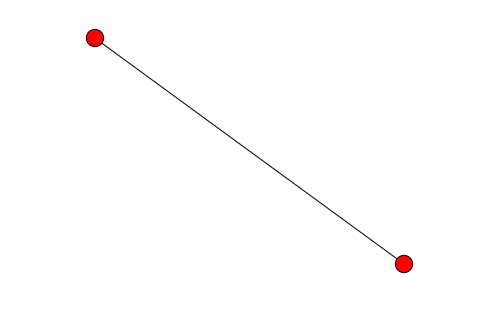


***********************
COMPONENT 0
***********************
Number of nodes  2
Number of edges  1
---
Top 3 nodes by degree centraliy in component 0
Gene: Degree Centrality   Degree
MAP3K1 : 1.0 1
B9D1_MIR1180_MAPK7_MFAP4_RNF112_SLC47A1_SNORA59B_ALDH3A2_SLC47A2_ALDH3A1_ULK2_AKAP10loss : 1.0 1
---
Writing nodes to:  output/BRCA_wustl-som-seg-gl-mpairs-min_cohort_filtered_network_comp0.txt


In [27]:
import networkx as nx
import csv

G=nx.Graph()
for pair in new_sig_m_dict:
    pair_type = new_sig_m_dict[pair]['Type']
    
    G.add_edge(tuple(pair)[0], tuple(pair)[1], {"Type": pair_type})

pos = nx.spring_layout(G)
nx.draw(G, pos)

# show graph
plt.show()

graphs = list(nx.connected_component_subgraphs(G))

top_number = 3

for i in range(len(graphs)):
    print "\n***********************"
    print "COMPONENT " + str(i) 
    print "***********************"
    graph = graphs[i]
    print "Number of nodes ", graph.number_of_nodes()
    print "Number of edges ", graph.number_of_edges()
    
    node_items = [g + (graph.degree(g[0]),) for g in nx.degree_centrality(graph).items()]
    node_items = sorted(node_items, key=lambda entry: entry[1], reverse = True)
    

    print "---"
    print "Top", top_number, "nodes by degree centraliy in component", i
    print "Gene: Degree Centrality   Degree"
    for j in range(min(top_number, len(node_items))):
        print node_items[j][0], ":", np.round(node_items[j][1], 2), node_items[j][2]
    
    component_file = network_m_file[:-4] + "_comp" + str(i) + ".txt"
    
    print "---"
    print "Writing nodes to: ", component_file
    with open(component_file, 'w') as csvfile:
        writer = csv.writer(csvfile, delimiter='\t')
        writer.writerow(["Node", "Degreee Centrality", "Degree"])
        for node_item in node_items:
            writer.writerow(node_item)

## Co-occurrence info

In [28]:
bgbp.write_segment_infos(goodgenes, segment_info_file)




print "*********COOCCURRENCE INFO**********\n"

print len(new_sig_c_dict), " Co-occurring pairs"

cfieldnames = ['Gene0', 'Gene1', 'Gene0Cytobands', 'Gene1Cytobands', 'AllCBinomProb', 
               'AllFreqs', 'AllOverlap', 'AllSize','1CBinomProb0', '1Freqs0', '1Overlap0',
               '1Size0']


gene_c_dict = {}
cyto_c_dict = {}
cyto_pair_c_dict = {}

for pair in new_sig_c_dict:
    if new_sig_c_dict[pair]['Gene0'][-4:] in {'loss', 'gain'}:
        suffix0 = new_sig_c_dict[pair]['Gene0'][-4:]
    else:
        suffix0 = ""

    if new_sig_c_dict[pair]['Gene1'][-4:] in {'loss', 'gain'}:
        suffix1 = new_sig_c_dict[pair]['Gene1'][-4:]
    else:
        suffix1 = ""
    
    
    info0 = bgbp.get_segment_gene_info(new_sig_c_dict[pair]['Gene0'])
    new_sig_c_dict[pair]['Gene0Loc'] = str(info0['Chromosome']) + ':' + str(info0['Start'])
    info1 = bgbp.get_segment_gene_info(new_sig_c_dict[pair]['Gene1'])
    new_sig_c_dict[pair]['Gene1Loc'] = str(info1['Chromosome']) + ':' + str(info1['Start'])
    new_sig_c_dict[pair]['Gene0Cytobands'] = str(info0['Cytobands'])
    new_sig_c_dict[pair]['Gene1Cytobands'] = str(info1['Cytobands'])
    
    
    if new_sig_c_dict[pair]['Gene0'] not in gene_c_dict:
        gene_c_dict[new_sig_c_dict[pair]['Gene0']] = set()
    gene_c_dict[new_sig_c_dict[pair]['Gene0']].add(pair)
    if new_sig_c_dict[pair]['Gene1'] not in gene_c_dict:
        gene_c_dict[new_sig_c_dict[pair]['Gene1']] = set()
    gene_c_dict[new_sig_c_dict[pair]['Gene1']].add(pair)
    
    
    
    if str(info0['Cytobands']) + suffix0 not in cyto_c_dict:
        cyto_c_dict[str(info0['Cytobands']) + suffix0] = set()
    cyto_c_dict[str(info0['Cytobands']) + suffix0].add(pair)
    if str(info1['Cytobands']) + suffix1 not in cyto_c_dict:
        cyto_c_dict[str(info1['Cytobands']) + suffix1] = set()
    cyto_c_dict[str(info1['Cytobands']) + suffix1].add(pair)
    
    
    
    cyto_pair = frozenset([str(info0['Cytobands']) + suffix0, str(info1['Cytobands']) + suffix1])
    
    if cyto_pair not in cyto_pair_c_dict:
        cyto_pair_c_dict[cyto_pair] = set()
        
    cyto_pair_c_dict[cyto_pair].add(pair)
    
# Writing to file
if new_sig_c_dict:
    for key in new_sig_c_dict[pair].keys():
        if key not in cfieldnames:
            cfieldnames.append(key)
    
orderedcpairs = sorted(new_sig_c_dict.keys(), key=lambda entry: (new_sig_c_dict[entry]['AllCBinomProb'],))
    
met.writeanydict(new_sig_c_dict, new_cpairfile, fieldnames=cfieldnames, orderedkeys=orderedcpairs)
print "updated with segment info ", new_cpairfile
!python add_COSMIC.py -ic Gene0 Gene1 -ip $COSMIC_pair_insertion_index -i $new_cpairfile -o $new_cpairfile
print "updated with COSMIC info ", new_cpairfile


# Writing gene infos
    

sorted_genes = sorted(gene_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytobands = sorted(cyto_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytotuples = sorted(cyto_pair_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)

print "\n**********SINGLE GENES**********"
print_length = 15
for gene in sorted_genes:
    if len(gene[0]) <= print_length + 4:
        print gene[0], "has", len(gene[1])
    else:
        print gene[0][0:print_length] + gene[0][-4:], "has\t", len(gene[1])

print "\n**********SINGLE CYTOBANDS**********"
for cytoband in sorted_cytobands:
    print cytoband[0], "has", len(cytoband[1])

print "\n**********PAIRED CYTOBANDS**********"
for cytotuple in sorted_cytotuples:
    print  cytotuple[0], "has", len(cytotuple[1])


os.system('say "finished"')

*********COOCCURRENCE INFO**********

1789  Co-occurring pairs
updated with segment info  output/BRCA_wustl-som-seg-gl-cpairs-min_cohort_filtered.txt
updated with COSMIC info  output/BRCA_wustl-som-seg-gl-cpairs-min_cohort_filtered.txt

**********SINGLE GENES**********
RN7SL811Pgain has 82
RN7SL371Pgain has 82
NAA38gain has 82
ARC_JRK_PSCA_LYgain has	69
C8orf17_CHRAC1_gain has	61
TRAPPC9gain has 60
KCNK9gain has 58
SNORD22loss has 55
FAM135B_COL22A1gain has 51
ZFAT_MIR30B_MIRgain has	47
KHDRBS3gain has 47
SNORA44gain has 45
EFR3A_OC90_HHLAgain has	40
PTPRN2_MIR595_Mgain has	36
ADCY8gain has 36
OR4F21_RPL23AP5loss has	34
RNF32_LMBR1_NOMgain has	34
ASAP1gain has 34
PAXIP1_HTR5A_RNgain has	32
DLGAP2_CLN8_MIRloss has	32
RNA5SP251loss has 31
DPP6gain has 31
FABP5P3_RNA5SP2gain has	30
KMT2Cgain has 30
CSMD1loss has 29
RN7SL318P_RN7SKloss has	28
MIR548F4_RNA5SPgain has	27
RN7SL72P_C7orf3gain has	27
RN7SL178P_CLDN2loss has	26
LINC00977_RN7SKgain has	26
FAM20C_PDGFA_PRgain has	26
RN7SL605Ploss 

256

# Draw co-occurrence network

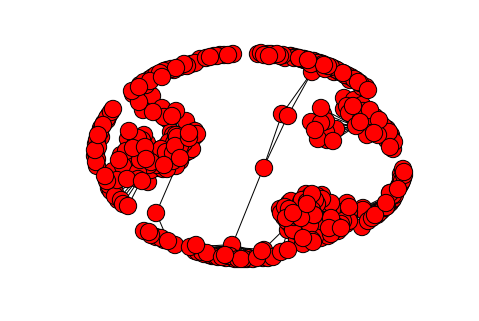


***********************
COMPONENT 0
***********************
Number of nodes  84
Number of edges  104
---
Top 3 nodes by degree centraliy in component 0
Gene: Degree Centrality   Degree
SNORD22loss : 0.66 55
RN7SL605Ploss : 0.31 26
TOPAZ1_TCAIM_LINC00694_ZNF445_ZNF852_ZKSCAN7_ZNF660_ZNF197_ZNF35_ZNF502_ZNF501_KIAA1143_KIF15_TMEM42_MIR564_TGM4_ZDHHC3_EXOSC7_CLEC3B_CDCP1_TMEM158_LARS2_LIMD1_SACM1L_RN7SL145P_SLC6A20_LZTFL1_CCR9_FYCO1_CXCR6_XCR1_CCR3_CCR1_CCR2_CCR5_LTF_RTP3_LRRC2_TDGF1_ALS2CL_TMIE_PRSS50_PRSS46_PRSS45_PRSS44_PRSS42_MYL3_PTH1R_CCDC12_NBEAL2_SETD2_KIF9_KLHL18_PTPN23_SCAP_ELP6_RN7SL870P_CSPG5_SMARCC1_DHX30_MIR1226_MAP4_RN7SL664P_CDC25A_MIR4443_CAMP_ZNF589_NME6_SPINK8_MIR2115_FBXW12_RN7SL321P_PLXNB1_CCDC51_TMA7_TREX1_ATRIP_SHISA5_PFKFB4_UCN2_COL7A1_MIR711_UQCRC1_TMEM89_SLC26A6_CELSR3_MIR4793_NCKIPSD_IP6K2_PRKAR2A_SLC25A20_ARIH2OS_ARIH2_P4HTM_WDR6_DALRD3_MIR425_NDUFAF3_MIR191_IMPDH2_QRICH1_RN7SL182P_QARS_USP19_LAMB2_CCDC71_KLHDC8B_C3orf84_CCDC36_C3orf62_MIR4271_USP4_GPX1_RHOA_T

In [29]:
import networkx as nx
import csv

G=nx.Graph()
for pair in new_sig_c_dict:
    pair_type = new_sig_c_dict[pair]['Type']
    
    G.add_edge(tuple(pair)[0], tuple(pair)[1], {"Type": pair_type})

pos = nx.spring_layout(G)
nx.draw(G, pos)

# show graph
plt.show()

graphs = list(nx.connected_component_subgraphs(G))

top_number = 3

for i in range(len(graphs)):
    print "\n***********************"
    print "COMPONENT " + str(i) 
    print "***********************"
    graph = graphs[i]
    print "Number of nodes ", graph.number_of_nodes()
    print "Number of edges ", graph.number_of_edges()
    
    node_items = [g + (graph.degree(g[0]),) for g in nx.degree_centrality(graph).items()]
    node_items = sorted(node_items, key=lambda entry: entry[1], reverse = True)
    

    print "---"
    print "Top", top_number, "nodes by degree centraliy in component", i
    print "Gene: Degree Centrality   Degree"
    for j in range(min(top_number, len(node_items))):
        print node_items[j][0], ":", np.round(node_items[j][1], 2), node_items[j][2]
    
    component_file = network_c_file[:-4] + "_comp" + str(i) + ".txt"
    
    print "---"
    print "Writing nodes to: ", component_file
    with open(component_file, 'w') as csvfile:
        writer = csv.writer(csvfile, delimiter='\t')
        writer.writerow(["Node", "Degreee Centrality", "Degree"])
        for node_item in node_items:
            writer.writerow(node_item)

## Search for triplets from among the pairs

In [30]:
# Search for triplets
import mutex_triangles as met
import edgereader as edg


        
    
    
# Search for triplets
import mutex_triangles as met
import edgereader as edg

genedict = edg.get_gene_dict(new_sig_dict)
Triplets, pairsdict_Triplets, sorted_pairs, genesdict_Triplets, sorted_genes = met.getTriplets(new_sig_dict, genedict, new_sig_dict, numCases, geneToCases=geneToCases, patientToGenes=patientToGenes)
Triplet_dict = met.sort_triplets_by_type(Triplets)

for t_type in Triplet_dict:
    print len(Triplet_dict[t_type]), " of type ",  t_type
    Triplet_dict[t_type] = sorted(Triplet_dict[t_type], key=lambda entry: entry.stats['Count'], reverse=True)
    triplet_file_name = triplet_output_prefix + t_type + '.txt'
    met.writeTriplets2(Triplet_dict[t_type], triplet_file_name)
    !python add_COSMIC.py -ic Gene0 Gene1 Gene2 -ip $COSMIC_triplet_insertion_index -i $triplet_file_name -o $triplet_file_name
    print "updated with COSMIC info ", triplet_file_name
    
    
    
    print "*********" + str(t_type) + "INFO**********\n"
    gene_t_dict = {}
    cyto_t_dict = {}
    cyto_trip_t_dict = {}
    
    
    # LEFT OFF HERE-JLU
    
    for triplet in Triplet_dict[t_type]:
        genes = triplet.genes
        suffixes = [gene[-4:] if gene[-4:] in {'loss', 'gain'} else "" for gene in genes]
        
        cytobands = set([str(bgbp.get_segment_gene_info(gene)['Cytobands']) for gene, suffix in zip(genes, suffixes)])
        
        for gene in genes:
            if gene not in gene_t_dict:
                gene_t_dict[gene] = set()
            gene_t_dict[gene].add(frozenset(genes.difference(set([gene]))))
    
        
        for cytoband in cytobands:
            if cytoband not in cyto_t_dict:
                cyto_t_dict[cytoband] = set()
            cyto_t_dict[cytoband].add(frozenset(cytobands.difference(set([cytoband]))))
    
        if frozenset(cytobands) not in cyto_trip_t_dict:
            cyto_trip_t_dict[frozenset(cytobands)] = set()
            
        cyto_trip_t_dict[frozenset(cytobands)].add(frozenset(genes))
    
    
    

    sorted_genes = sorted(gene_t_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
    sorted_cytobands = sorted(cyto_t_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
    sorted_cytotuples = sorted(cyto_trip_t_dict.items(), key = lambda entry: len(entry[1]), reverse=True)

    print "\n**********SINGLE GENES**********"
    print_length = 15
    for gene in sorted_genes:
        if len(gene[0]) <= print_length + 4:
            print gene[0], "has", len(gene[1])
        else:
            print gene[0][0:print_length] + gene[0][-4:], "has\t", len(gene[1])

    print "\n**********SINGLE CYTOBANDS**********"
    for cytoband in sorted_cytobands:
        print cytoband[0], "has", len(cytoband[1])

    print "\n**********PAIRED CYTOBANDS**********"
    for cytotuple in sorted_cytotuples:
        print  cytotuple[0], "has", len(cytotuple[1])


    os.system('say "finished"')



number of pairs  1790
Pair info of triplets initialized
1429  triplets calculated in  0.954550981522
Including sorting time  0.960516929626
1429  of type  CooccurringCooccurringCooccurring
Triplets written to  output/BRCA_wustl-som-seg-gl-triplets-CooccurringCooccurringCooccurring.txt
updated with COSMIC info  output/BRCA_wustl-som-seg-gl-triplets-CooccurringCooccurringCooccurring.txt
*********CooccurringCooccurringCooccurringINFO**********


**********SINGLE GENES**********
RN7SL811Pgain has 549
RN7SL371Pgain has 549
NAA38gain has 549
PTPRN2_MIR595_Mgain has	102
RNF32_LMBR1_NOMgain has	96
PAXIP1_HTR5A_RNgain has	90
DPP6gain has 87
KMT2Cgain has 84
FABP5P3_RNA5SP2gain has	84
RN7SL72P_C7orf3gain has	75
MIR548F4_RNA5SPgain has	75
FAM20C_PDGFA_PRgain has	72
MAD1L1_MIR4655_gain has	72
CNTNAP2gain has 72
SDK1gain has 69
FOXK1_AP5Z1_MIRgain has	66
CREB3L2_AKR1D1_gain has	63
CHRM2_MIR490_PTgain has	60
NDUFA4_PHF14gain has 60
THSD7A_TMEM106Bgain has	54
EXOC4_LRGUK_SLCgain has	54
AGMO_MEOX2gain

# Search specifically for two-hit on tumor suppressors

In [1]:
mutationmatrix = '/Users/jlu96/maf/new/BRCA_wustl/BRCA_wustl-som-cna-gl.m2'
# Set to name of tab-delimited matrix file. First column of each row should be Patient ID. Remaining row entries are names of present mutations

patientFile = '/Users/jlu96/maf/new/BRCA_wustl/shared_patients.plst'
# Text file with patient names. Set to None to use all the patients.

geneFile = '/Users/jlu96/conte/jlu/mutex/data/tumor_suppressors_twohit.glst'
# Only load genes listed in this file

geneList1 = '/Users/jlu96/conte/jlu/mutex/data/tumor_suppressors_twohit_somatic.glst'

geneList2 = '/Users/jlu96/conte/jlu/mutex/data/tumor_suppressors_twohit_copy.glst'
# If want to specifically look for pairs between certain genes, set geneList1 and geneList2. All
# pairs between one gene in geneList1 and one gene in geneList2 will be tested


output_prefix =  "output/BRCA_wustl-som-cna-gl-twohit"

# Prefix for the following output filenames:
pairfile = output_prefix + 'pairs-min_cohort.txt' #Pair statistics within the least mutated patients
new_pairfile = output_prefix + "-pairs-min_cohort_filtered.txt" #Pair statistics over all patients
new_cpairfile = output_prefix + "-cpairs-min_cohort_filtered.txt" #Co-occurringPair statistics over all patients
new_mpairfile = output_prefix + "-mpairs-min_cohort_filtered.txt"#Mutually exclusive Pair statistics over all patients
triplet_output_prefix = output_prefix + '-triplets-'
network_c_file = new_cpairfile[:-4] + "_network.txt"
network_m_file = new_mpairfile[:-4] + "_network.txt"
segment_info_file = output_prefix + "segment_info.txt" # Name of file to write segmentation information to



leastPatientThreshold = 30
# To choose which genes to test, first consider only the patients below this percentile. e.g. if set to 50, the bottom 50% of patients
# are called least mutated.

test_gene_threshold = 1
# Test genes that are mutated in at least this percentage of the least mutated patients.



minFreq = 0
# Minimum gene mutation frequency


closer_than_distance = 0
# Minimum distance between genes to test them, in bp.

only_filter_copy_distance = True
# Only filter the copy number distances. Don't touch this.

cFDRthreshold = 0.05
# FDR threshold for c-pvalues.

mFDRthreshold = 0.05
# FDR threshold for mutually exclusive pairs.

pairs_have_dependencies = True
#for FDR threshold. Set to True to be conservative, otherwise FDR only controls under independence/positive dependence assumptions

remove_missing_genes = True

# 1) Plot the distribution of mutations across genes and across patients
# 2) Plot distribution over the least mutated patients
# 3) Generate the gene pairs to be tested

A good rule of thumb is to 

38 genes x 963 patients
*******************************************************************
*                   PLOT MUTATION DISTRIBUTIONS                   *
*******************************************************************
GENE MUTATION DISTRIBUTION


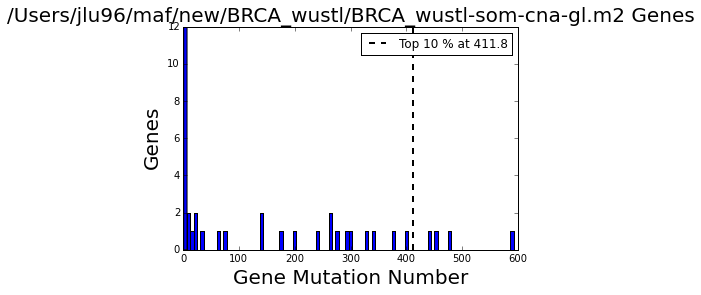

Zoomed into bottom 95 percent region


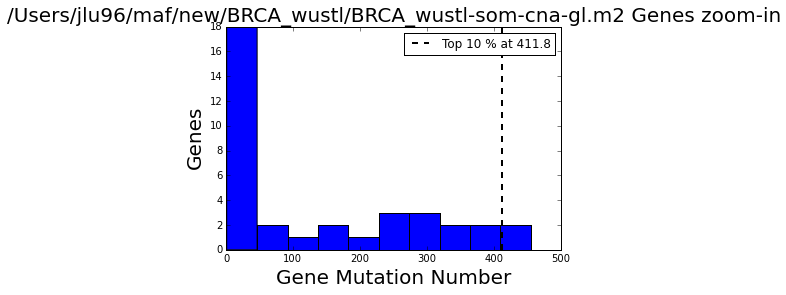


PATIENT MUTATION DISTRIBUTION


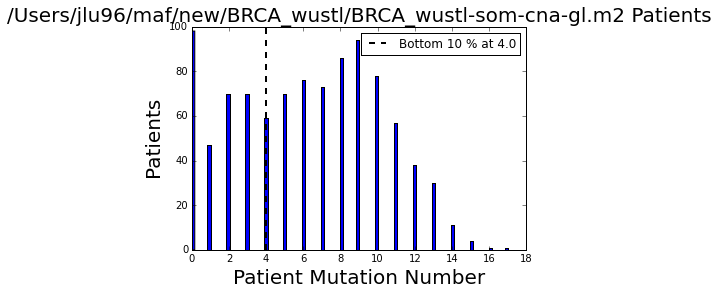

Zoomed into bottom 95 percent region


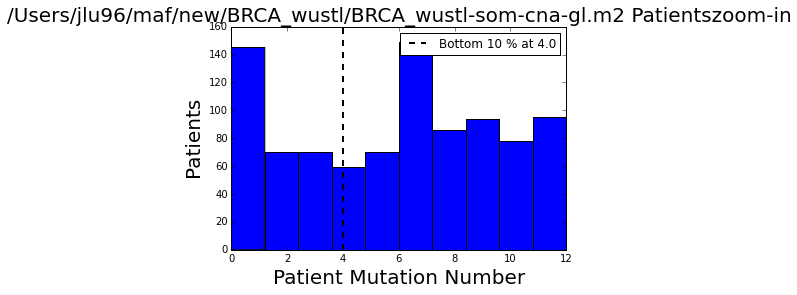

*******************************************************************
*         PLOT DISTRIBUTIONS AMONG LEAST MUTATED PATIENTS         *
*******************************************************************
GENE MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS


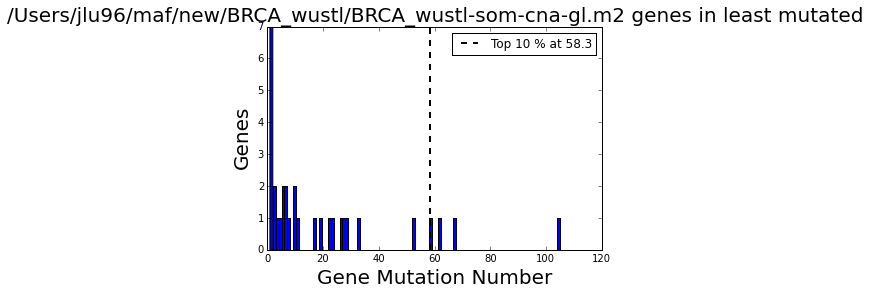


PATIENT MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS


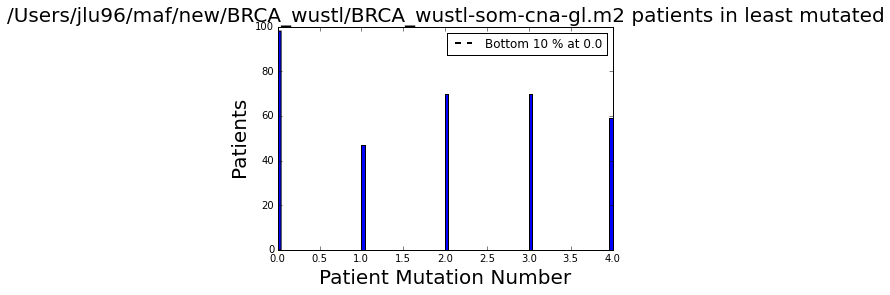

*******************************************************************
*                   GETTING TEST GENE PAIRS                       *
*******************************************************************
The least mutated patients are the bottom  30  % of patients
Least mutated patients: 32 genes x 344 patients
The test gene threshold is  1 % of the least mutated patients
Test genes are mutated at least  3  in th least mutated patients


Number of test genes:  25
All genes that weren't found in gene_positions file will not be considered
Number of pairs to test:  114
Number of pairs is  114  retrieved in time :  0.00260019302368


0

In [2]:
import mutex as mex
import csv
import mutex_triangles as met
import chisquared as chi
import bingenesbypairs as bgbp
import time
import os
import scipy.stats as stats
import partition as par
import numpy as np
import multi_testing as mt
%matplotlib inline

COSMIC_pair_insertion_index = 8
COSMIC_triplet_insertion_index = 5
compute_mutex = True

numGenes, numCases, genes, patients, geneToCases, patientToGenes = mex.load_mutation_data(mutationmatrix, patientFile, geneFile, minFreq)

print '%s genes x %s patients' % (numGenes, numCases)


print "*******************************************************************"
print "*                   PLOT MUTATION DISTRIBUTIONS                   *"
print "*******************************************************************"

print "GENE MUTATION DISTRIBUTION"
mex.graph_mutation_distribution(numCases, genes, geneToCases, filename=mutationmatrix + " Genes", bins=100, zoomin_percentile=95)


print "\nPATIENT MUTATION DISTRIBUTION"
mex.graph_patient_distribution(len(genes), patients, patientToGenes, mutationmatrix + " Patients", bottom_percentile=leastPatientThreshold, zoomin_percentile=95)


print "*******************************************************************"
print "*         PLOT DISTRIBUTIONS AMONG LEAST MUTATED PATIENTS         *"
print "*******************************************************************"




D = [len(patientToGenes[p]) for p in patientToGenes]
minThreshold = stats.scoreatpercentile(D, leastPatientThreshold)

c0patients = [p for p in patientToGenes if len(patientToGenes[p]) <= minThreshold]

c0cohort_dict = {0: c0patients}

c0genes, c0geneToCases, c0patientToGenes = par.get_cluster_gTC_pTG(geneToCases, patientToGenes, c0patients)

print "GENE MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS"
mex.graph_mutation_distribution(len(c0patients), c0genes, c0geneToCases, filename=mutationmatrix + " genes in least mutated", bins=100)

print "\nPATIENT MUTATION DISTRIBUTION IN LEAST MUTATED PATIENTS"
mex.graph_patient_distribution(len(genes), c0patients, c0patientToGenes, filename=mutationmatrix + " patients in least mutated")



print "*******************************************************************"
print "*                   GETTING TEST GENE PAIRS                       *"
print "*******************************************************************"
print "The least mutated patients are the bottom ", leastPatientThreshold, " % of patients"
print "Least mutated patients: %s genes x %s patients" % (len(c0genes), len(c0patients) )


test_minFreq = int( test_gene_threshold * 0.01 * len(c0patients))
print "The test gene threshold is ", test_gene_threshold, "% of the least mutated patients"
print "Test genes are mutated at least ", test_minFreq, " in th least mutated patients"

reload(bgbp)
print 
print
print "Number of test genes: ", len([g for g in c0genes if len(c0geneToCases[g]) >= test_minFreq and (not remove_missing_genes or
                                                                                                     bgbp.get_segment_gene_info(g)['Chromosome'] != bgbp.missing_chromosome)])

t = time.time()
if geneList1 != None and geneList2 !=None:
    with open(geneList1) as f:
            genes1 = set(l.rstrip().split()[0] for l in f if not l.startswith("#"))
    with open(geneList2) as f:
            genes2 = set(l.rstrip().split()[0] for l in f if not l.startswith("#"))
    
    genepairs = bgbp.getgenepairs(c0geneToCases, genes1, genes2=genes2, test_minFreq=test_minFreq, closer_than_distance=closer_than_distance, only_filter_copy_distance=only_filter_copy_distance,
                                 remove_missing_genes=remove_missing_genes)
    
            
else:
    genepairs = bgbp.getgenepairs(c0geneToCases, c0genes, test_minFreq=test_minFreq, closer_than_distance=closer_than_distance, only_filter_copy_distance=only_filter_copy_distance,
                                 remove_missing_genes=remove_missing_genes)
print "Number of pairs is ", len(genepairs), " retrieved in time : ", time.time() - t

os.system('say "exploration finished"')

In [3]:
print sorted(c0genes)
with_copy_number = [gene for gene in c0genes if gene + 'loss' in c0genes]
print "Those with copy number: "
print with_copy_number, len(with_copy_number)
print genepairs

['APC', 'APCloss', 'BRCA1', 'BRCA1loss', 'CDKN1B', 'CDKN1Bloss', 'CDKN2Aloss', 'DLDloss', 'PTEN', 'PTENloss', 'RB1', 'RB1loss', 'SDHB', 'SDHBloss', 'SDHDloss', 'SFRP1loss', 'ST14loss', 'ST5', 'ST5loss', 'ST7', 'ST7loss', 'TCF21loss', 'TP53', 'TP53loss', 'TP63', 'TP63loss', 'TP73', 'TP73loss', 'TSC1', 'TSC1loss', 'TSC2', 'TSC2loss']
Those with copy number: 
['CDKN1B', 'RB1', 'TSC2', 'TSC1', 'TP63', 'ST5', 'ST7', 'BRCA1', 'TP53', 'TP73', 'PTEN', 'APC', 'SDHB'] 13
[frozenset(['APC', 'SFRP1loss']), frozenset(['PTEN', 'TSC1loss']), frozenset(['TSC2', 'SDHDloss']), frozenset(['APC', 'TSC2loss']), frozenset(['CDKN1B', 'TCF21loss']), frozenset(['APC', 'SDHBloss']), frozenset(['BRCA1', 'PTENloss']), frozenset(['PTENloss', 'PTEN']), frozenset(['APC', 'TP53loss']), frozenset(['TP53', 'SFRP1loss']), frozenset(['TSC2', 'RB1loss']), frozenset(['CDKN1B', 'TP73loss']), frozenset(['BRCA1', 'SDHDloss']), frozenset(['ST7loss', 'TP53']), frozenset(['APC', 'TCF21loss']), frozenset(['CDKN1B', 'SDHBloss']), 

## Perform statistical tests of each of the pairs
### This cell's runtime is usually about (number of pairs)/ 900 seconds.

In [4]:
print "Getting normal statistics..."
t = time.time()
pairsdict, genedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, genepairs, compute_mutex=compute_mutex)
print "Finished in ", time.time() - t

print "Testing among least mutated patients..."
t = time.time()
pairsdict = chi.add_BinomP_cohorts_all_pairs(pairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)
print "Finished in ", time.time() - t
print "All pairs tested in least mutated patients written to ",  pairfile

fieldnames = (pairsdict.values()[0]).keys()
fieldnames.remove('MutationFrequencies')
fieldnames.remove('MutationFrequencyDifference')
fieldnames.remove('MutationFrequencyDifferenceRatio')
fieldnames.remove('CooccurrenceRatio')
fieldnames.remove('Coverage')
fieldnames.remove('SetScore')
fieldnames.remove('AverageOverlapPMN')
fieldnames.remove('CombinedScore')
fieldnames.remove('Concordance')
fieldnames.remove('Somatic')
fieldnames.remove('RoundedLogPCov')
fieldnames.remove('GeneSet')
fieldnames.remove('Type')


fieldnames.insert(2, 'Type')
fieldnames.insert(3, '1CBinomProb0')
fieldnames.insert(3, '1MBinomProb0')

met.writeanydict(pairsdict, pairfile, fieldnames=fieldnames)
print "Pairs in least mutated patients finished"
os.system('say "Pairs in least mutated patients finished"')



Getting normal statistics...
Finished in  0.776859045029
Testing among least mutated patients...
Finished in  0.168688058853
All pairs tested in least mutated patients written to  output/BRCA_wustl-som-cna-gl-twohitpairs-min_cohort.txt
Pairs in least mutated patients finished


0

# Plot the distribution of p-values.

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


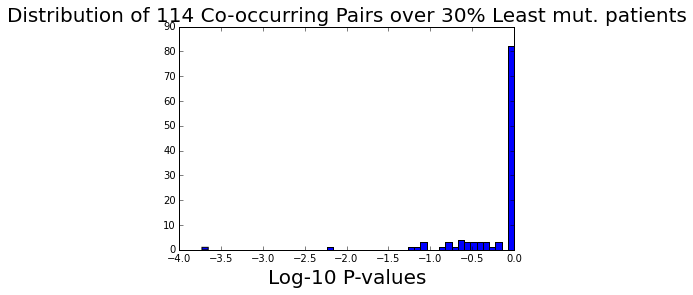

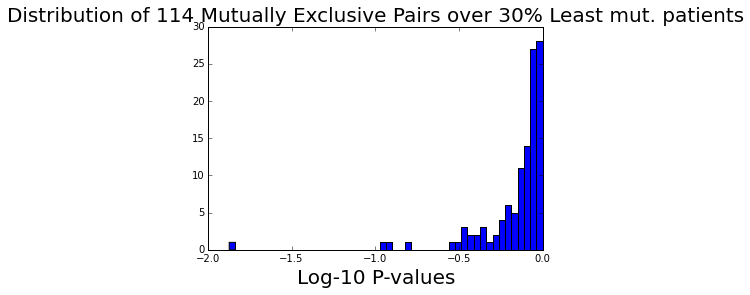

In [5]:
import matplotlib.pyplot as plt

%matplotlib inline
cpvalues = np.array([pairsdict[c]['1CBinomProb0'] for c in pairsdict])
logcp = np.log10(cpvalues)
mpvalues = np.array([pairsdict[c]['1MBinomProb0'] for c in pairsdict])
logmp = np.log10(mpvalues)


plt.figure()
plt.hist(logcp, bins=50)
plt.title("Distribution of " + str(len(logcp)) + " Co-occurring Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()

plt.figure()
plt.hist(logmp, bins=50)
plt.title("Distribution of " + str(len(logmp))  + " Mutually Exclusive Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()

# Set the cutoff of significant pairs to test over the whole distribution

In [31]:
cpairPercentile = 50
# Percentile of most significant co-occurring pairs to test

mpairPercentile = 10

# Visualize the cutoff
## Go back and adjust if you'd like!

Top  50 percent of cooccurring pairs:  1.0
Top  10 percent of mutually exclusive pairs :  0.403259703354
Now number of mutex pairs to test  13
Now number of coocurr pairs to test  114
Number of genes  25


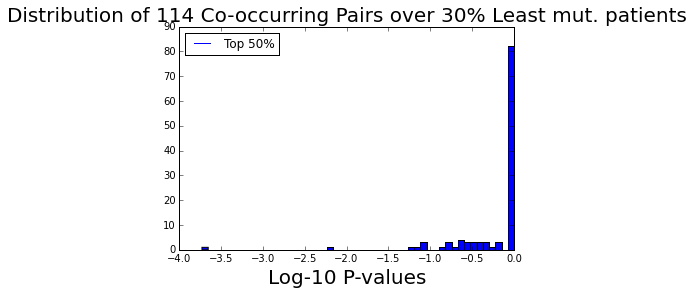

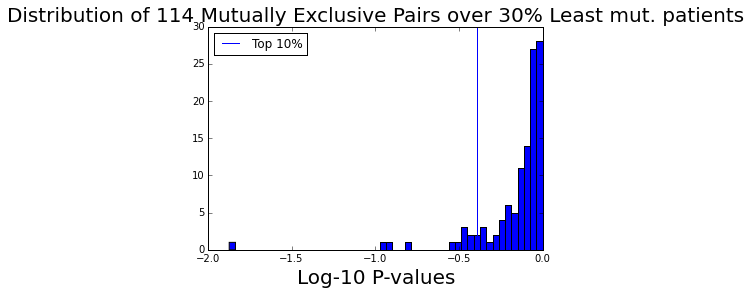

In [32]:
import matplotlib.pyplot as plt

%matplotlib inline
cpvalues = np.array([pairsdict[c]['1CBinomProb0'] for c in pairsdict])
logcp = np.log10(cpvalues)
mpvalues = np.array([pairsdict[c]['1MBinomProb0'] for c in pairsdict])
logmp = np.log10(mpvalues)


cthreshold = stats.scoreatpercentile(cpvalues, cpairPercentile)
mthreshold = stats.scoreatpercentile(mpvalues, mpairPercentile)
print "Top ", cpairPercentile, "percent of cooccurring pairs: ", cthreshold
print "Top ", mpairPercentile, "percent of mutually exclusive pairs : ", mthreshold

# Let's get the top 10 percent of pairs

goodcpairs = [c for c in pairsdict if (pairsdict[c]['1CBinomProb0'] <= cthreshold)]
goodmpairs = [c for c in pairsdict if (pairsdict[c]['1MBinomProb0'] <= mthreshold)]
goodpairs = goodcpairs + goodmpairs
goodgenes = set.union(*(set(goodpair) for goodpair in goodpairs))
print "Now number of mutex pairs to test ", len(goodmpairs)
print "Now number of coocurr pairs to test ", len(goodcpairs)
print "Number of genes ", len(goodgenes)

plt.figure()
plt.hist(logcp, bins=50)
plt.axvline(x= np.log10(cthreshold), label="Top " + str(cpairPercentile) + "%")
plt.title("Distribution of " + str(len(logcp)) + " Co-occurring Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()



plt.figure()
plt.hist(logmp, bins=50)
plt.axvline(x= np.log10(mthreshold), label="Top " + str(mpairPercentile) + "%")
plt.title("Distribution of " + str(len(logmp))  + " Mutually Exclusive Pairs over " + str(leastPatientThreshold) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()



### Test new pairs

In [33]:
print "Getting normal statistics across whole distribution"

new_mpairsdict, new_mgenedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, goodmpairs, compute_mutex=compute_mutex)
new_cpairsdict, new_cgenedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, goodcpairs, compute_mutex=compute_mutex)

print "Testing across the whole distribution"

new_mpairsdict = chi.add_BinomP_cohorts_all_pairs(new_mpairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)
new_cpairsdict = chi.add_BinomP_cohorts_all_pairs(new_cpairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)

new_pairsdict = new_mpairsdict.copy()
new_pairsdict.update(new_mpairsdict)


print "All tested pairs have been written to ", new_pairfile

fieldnames = (new_pairsdict.values()[0]).keys()
fieldnames.remove('MutationFrequencies')
fieldnames.remove('MutationFrequencyDifference')
fieldnames.remove('MutationFrequencyDifferenceRatio')
fieldnames.remove('CooccurrenceRatio')
fieldnames.remove('Coverage')
fieldnames.remove('SetScore')
fieldnames.remove('AverageOverlapPMN')
fieldnames.remove('CombinedScore')
fieldnames.remove('Concordance')
fieldnames.remove('Somatic')
fieldnames.remove('RoundedLogPCov')
fieldnames.remove('GeneSet')
fieldnames.remove('Type')

fieldnames.insert(2, 'Type')
fieldnames.insert(3, 'AllMBinomProb')
fieldnames.insert(3, 'AllCBinomProb')

met.writeanydict(new_pairsdict, new_pairfile, fieldnames=fieldnames)

os.system('say "whole distribution pairs finished"')

Getting normal statistics across whole distribution
Testing across the whole distribution
All tested pairs have been written to  output/BRCA_wustl-som-cna-gl-twohit-pairs-min_cohort_filtered.txt


0

### Plot results

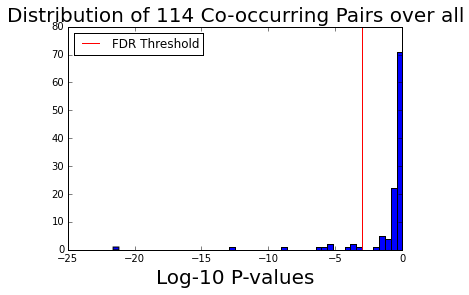

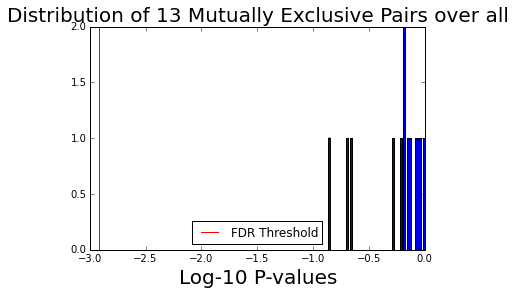

Number significant mutex 0
Number significant coocurr 11


In [34]:
import matplotlib.pyplot as plt

%matplotlib inline

cpairs = [c for c in new_cpairsdict]
cpvalues = np.array([new_cpairsdict[c]['AllCBinomProb'] for c in new_cpairsdict])
sig_cpairs, sig_cpvalues, cthreshold = mt.BH(cpairs, cpvalues, Q=cFDRthreshold, use_dependencies=pairs_have_dependencies)

not_sig_cpairs = set(new_cpairsdict.keys()).difference(set(sig_cpairs))

new_sig_c_dict = new_cpairsdict.copy()
for not_sig_cpair in not_sig_cpairs:
    del new_sig_c_dict[not_sig_cpair]

logcp = np.log10(cpvalues)

if len(logcp) > 1:
    plt.figure()
    plt.hist(logcp, bins=50)
    plt.axvline(x=np.log10(cthreshold), label="FDR Threshold", c='r')
    plt.title("Distribution of " + str(len(logcp)) + " Co-occurring Pairs over all", fontsize=20)
    plt.xlabel("Log-10 P-values", fontsize=20)
    plt.legend(loc='best')
    plt.show()
elif len(logcp) == 1:
    print "One tested co-occurring pair with p=", cpvalues[0]


mpairs = [c for c in new_mpairsdict]
mpvalues = np.array([new_mpairsdict[c]['AllMBinomProb'] for c in new_mpairsdict])
sig_mpairs, sig_mpvalues, mthreshold = mt.BH(mpairs, mpvalues, Q=mFDRthreshold, use_dependencies=pairs_have_dependencies)

not_sig_mpairs = set(new_mpairsdict.keys()).difference(set(sig_mpairs))

new_sig_m_dict = new_mpairsdict.copy()
for not_sig_mpair in not_sig_mpairs:
    del new_sig_m_dict[not_sig_mpair]

logmp = np.log10(mpvalues)

if len(logmp) > 1:
    plt.figure()
    plt.hist(logmp, bins=50)
    plt.axvline(x=np.log10(mthreshold), label="FDR Threshold", c='r')
    plt.title("Distribution of " + str(len(logmp)) + " Mutually Exclusive Pairs over all", fontsize=20)
    plt.xlabel("Log-10 P-values", fontsize=20)
    plt.legend(loc='best')
    plt.show()
elif len(logmp) == 1:
    print "One tested mutex pair with p=", mpvalues[0]




print "Number significant mutex", len(new_sig_m_dict)
print "Number significant coocurr", len(new_sig_c_dict)


new_sig_dict = new_sig_m_dict.copy()
new_sig_dict.update(new_sig_c_dict)


## Mutual exclusivity info

In [35]:


bgbp.write_segment_infos(goodgenes, segment_info_file)



print "*********MUTUAL EXCLUSIVITY INFO**********\n"

print len(new_sig_m_dict), " Mutually exclusive pairs"

mfieldnames = ['Gene0', 'Gene1', 'Gene0Cytobands', 'Gene1Cytobands', 'AllMBinomProb', 
                'AllFreqs', 'AllOverlap', 'AllSize','1MBinomProb0', '1Freqs0', '1Overlap0',
               '1Size0']


gene_m_dict = {}
cyto_m_dict = {}
cyto_pair_m_dict = {}

for pair in new_sig_m_dict:
    if new_sig_m_dict[pair]['Gene0'][-4:] in {'loss', 'gain'}:
        suffix0 = new_sig_m_dict[pair]['Gene0'][-4:]
    else:
        suffix0 = ""

    if new_sig_m_dict[pair]['Gene1'][-4:] in {'loss', 'gain'}:
        suffix1 = new_sig_m_dict[pair]['Gene1'][-4:]
    else:
        suffix1 = ""
    
    
    info0 = bgbp.get_segment_gene_info(new_sig_m_dict[pair]['Gene0'])
    new_sig_m_dict[pair]['Gene0Loc'] = str(info0['Chromosome']) + ':' + str(info0['Start'])
    info1 = bgbp.get_segment_gene_info(new_sig_m_dict[pair]['Gene1'])
    new_sig_m_dict[pair]['Gene1Loc'] = str(info1['Chromosome']) + ':' + str(info1['Start'])
    new_sig_m_dict[pair]['Gene0Cytobands'] = str(info0['Cytobands'])
    new_sig_m_dict[pair]['Gene1Cytobands'] = str(info1['Cytobands'])
    
    
    if new_sig_m_dict[pair]['Gene0'] not in gene_m_dict:
        gene_m_dict[new_sig_m_dict[pair]['Gene0']] = set()
    gene_m_dict[new_sig_m_dict[pair]['Gene0']].add(pair)
    if new_sig_m_dict[pair]['Gene1'] not in gene_m_dict:
        gene_m_dict[new_sig_m_dict[pair]['Gene1']] = set()
    gene_m_dict[new_sig_m_dict[pair]['Gene1']].add(pair)
    
    
    
    if str(info0['Cytobands']) + suffix0 not in cyto_m_dict:
        cyto_m_dict[str(info0['Cytobands']) + suffix0] = set()
    cyto_m_dict[str(info0['Cytobands'])].add(pair)
    if str(info1['Cytobands']) + suffix1 not in cyto_m_dict:
        cyto_m_dict[str(info1['Cytobands']) + suffix1] = set()
    cyto_m_dict[str(info1['Cytobands'])].add(pair)
    
    
    
    cyto_pair = frozenset([str(info0['Cytobands']) + suffix0, str(info1['Cytobands']) + suffix1])
    
    if cyto_pair not in cyto_pair_m_dict:
        cyto_pair_m_dict[cyto_pair] = set()
        
    cyto_pair_m_dict[cyto_pair].add(pair)


if new_sig_m_dict:
    for key in new_sig_m_dict[pair].keys():
        if key not in mfieldnames:
            mfieldnames.append(key)
    

orderedmpairs = sorted(new_sig_m_dict.keys(), key=lambda entry: (new_sig_m_dict[entry]['AllMBinomProb'],))
    
met.writeanydict(new_sig_m_dict, new_mpairfile, fieldnames=mfieldnames, orderedkeys=orderedmpairs)
print "updated with segment info ", new_mpairfile
!python add_COSMIC.py -ic Gene0 Gene1 -ip $COSMIC_pair_insertion_index -i $new_mpairfile -o $new_mpairfile
print "updated with COSMIC info ", new_mpairfile


# Writing gene infos
    

sorted_genes = sorted(gene_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytobands = sorted(cyto_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytotuples = sorted(cyto_pair_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)

print "\n**********SINGLE GENES**********"
print_length = 15
for gene in sorted_genes:
    if len(gene[0]) <= print_length + 4:
        print gene[0], "has", len(gene[1])
    else:
        print gene[0][0:print_length] + gene[0][-4:], "has\t", len(gene[1])

print "\n**********SINGLE CYTOBANDS**********"
for cytoband in sorted_cytobands:
    print cytoband[0], "has", len(cytoband[1])

print "\n**********PAIRED CYTOBANDS**********"
for cytotuple in sorted_cytotuples:
    print  cytotuple[0], "has", len(cytotuple[1])


os.system('say "finished"')

*********MUTUAL EXCLUSIVITY INFO**********

0  Mutually exclusive pairs
updated with segment info  output/BRCA_wustl-som-cna-gl-twohit-mpairs-min_cohort_filtered.txt
updated with COSMIC info  output/BRCA_wustl-som-cna-gl-twohit-mpairs-min_cohort_filtered.txt

**********SINGLE GENES**********

**********SINGLE CYTOBANDS**********

**********PAIRED CYTOBANDS**********


0

# Draw mutual exclusivity network

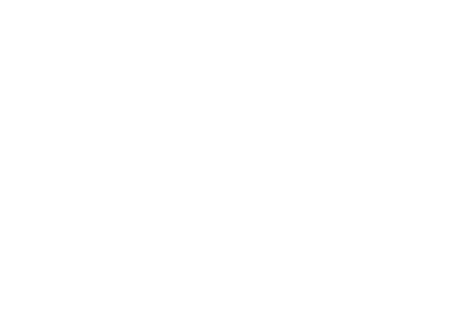

In [36]:
import networkx as nx
import csv

G=nx.Graph()
for pair in new_sig_m_dict:
    pair_type = new_sig_m_dict[pair]['Type']
    
    G.add_edge(tuple(pair)[0], tuple(pair)[1], {"Type": pair_type})

pos = nx.spring_layout(G)
nx.draw(G, pos)

# show graph
plt.show()

graphs = list(nx.connected_component_subgraphs(G))
graphs = sorted(graphs, key = lambda entry: entry.number_of_nodes(), reverse=True)

top_number = 3

for i in range(len(graphs)):
    print "\n***********************"
    print "COMPONENT " + str(i) 
    print "***********************"
    graph = graphs[i]
    print "Number of nodes ", graph.number_of_nodes()
    print "Number of edges ", graph.number_of_edges()
    
    node_items = [g + (graph.degree(g[0]),) for g in nx.degree_centrality(graph).items()]
    node_items = sorted(node_items, key=lambda entry: entry[1], reverse = True)
    

    print "---"
    print "Top", top_number, "nodes by degree centraliy in component", i
    print "Gene: Degree Centrality   Degree"
    for j in range(min(top_number, len(node_items))):
        print node_items[j][0], ":", np.round(node_items[j][1], 2), node_items[j][2]
    
    component_file = network_m_file[:-4] + "_comp" + str(i) + ".txt"
    
    print "---"
    print "Writing nodes to: ", component_file
    with open(component_file, 'w') as csvfile:
        writer = csv.writer(csvfile, delimiter='\t')
        writer.writerow(["Node", "Degreee Centrality", "Degree"])
        for node_item in node_items:
            writer.writerow(node_item)

## Co-occurrence info

In [37]:
bgbp.write_segment_infos(goodgenes, segment_info_file)




print "*********COOCCURRENCE INFO**********\n"

print len(new_sig_c_dict), " Co-occurring pairs"

cfieldnames = ['Gene0', 'Gene1', 'Gene0Cytobands', 'Gene1Cytobands', 'AllCBinomProb', 
               'AllFreqs', 'AllOverlap', 'AllSize','1CBinomProb0', '1Freqs0', '1Overlap0',
               '1Size0']


gene_c_dict = {}
cyto_c_dict = {}
cyto_pair_c_dict = {}

for pair in new_sig_c_dict:
    if new_sig_c_dict[pair]['Gene0'][-4:] in {'loss', 'gain'}:
        suffix0 = new_sig_c_dict[pair]['Gene0'][-4:]
    else:
        suffix0 = ""

    if new_sig_c_dict[pair]['Gene1'][-4:] in {'loss', 'gain'}:
        suffix1 = new_sig_c_dict[pair]['Gene1'][-4:]
    else:
        suffix1 = ""
    
    
    info0 = bgbp.get_segment_gene_info(new_sig_c_dict[pair]['Gene0'])
    new_sig_c_dict[pair]['Gene0Loc'] = str(info0['Chromosome']) + ':' + str(info0['Start'])
    info1 = bgbp.get_segment_gene_info(new_sig_c_dict[pair]['Gene1'])
    new_sig_c_dict[pair]['Gene1Loc'] = str(info1['Chromosome']) + ':' + str(info1['Start'])
    new_sig_c_dict[pair]['Gene0Cytobands'] = str(info0['Cytobands'])
    new_sig_c_dict[pair]['Gene1Cytobands'] = str(info1['Cytobands'])
    
    
    if new_sig_c_dict[pair]['Gene0'] not in gene_c_dict:
        gene_c_dict[new_sig_c_dict[pair]['Gene0']] = set()
    gene_c_dict[new_sig_c_dict[pair]['Gene0']].add(pair)
    if new_sig_c_dict[pair]['Gene1'] not in gene_c_dict:
        gene_c_dict[new_sig_c_dict[pair]['Gene1']] = set()
    gene_c_dict[new_sig_c_dict[pair]['Gene1']].add(pair)
    
    
    
    if str(info0['Cytobands']) + suffix0 not in cyto_c_dict:
        cyto_c_dict[str(info0['Cytobands']) + suffix0] = set()
    cyto_c_dict[str(info0['Cytobands']) + suffix0].add(pair)
    if str(info1['Cytobands']) + suffix1 not in cyto_c_dict:
        cyto_c_dict[str(info1['Cytobands']) + suffix1] = set()
    cyto_c_dict[str(info1['Cytobands']) + suffix1].add(pair)
    
    
    
    cyto_pair = frozenset([str(info0['Cytobands']) + suffix0, str(info1['Cytobands']) + suffix1])
    
    if cyto_pair not in cyto_pair_c_dict:
        cyto_pair_c_dict[cyto_pair] = set()
        
    cyto_pair_c_dict[cyto_pair].add(pair)
    
# Writing to file
if new_sig_c_dict:
    for key in new_sig_c_dict[pair].keys():
        if key not in cfieldnames:
            cfieldnames.append(key)
    
orderedcpairs = sorted(new_sig_c_dict.keys(), key=lambda entry: (new_sig_c_dict[entry]['AllCBinomProb'],))
    
met.writeanydict(new_sig_c_dict, new_cpairfile, fieldnames=cfieldnames, orderedkeys=orderedcpairs)
print "updated with segment info ", new_cpairfile
!python add_COSMIC.py -ic Gene0 Gene1 -ip $COSMIC_pair_insertion_index -i $new_cpairfile -o $new_cpairfile
print "updated with COSMIC info ", new_cpairfile


# Writing gene infos
    

sorted_genes = sorted(gene_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytobands = sorted(cyto_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytotuples = sorted(cyto_pair_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)

print "\n**********SINGLE GENES**********"
print_length = 15
for gene in sorted_genes:
    if len(gene[0]) <= print_length + 4:
        print gene[0], "has", len(gene[1])
    else:
        print gene[0][0:print_length] + gene[0][-4:], "has\t", len(gene[1])

print "\n**********SINGLE CYTOBANDS**********"
for cytoband in sorted_cytobands:
    print cytoband[0], "has", len(cytoband[1])

print "\n**********PAIRED CYTOBANDS**********"
for cytotuple in sorted_cytotuples:
    print  cytotuple[0], "has", len(cytotuple[1])


os.system('say "finished"')

*********COOCCURRENCE INFO**********

11  Co-occurring pairs
updated with segment info  output/BRCA_wustl-som-cna-gl-twohit-cpairs-min_cohort_filtered.txt
updated with COSMIC info  output/BRCA_wustl-som-cna-gl-twohit-cpairs-min_cohort_filtered.txt

**********SINGLE GENES**********
TP53 has 11
PTENloss has 1
TSC1loss has 1
APCloss has 1
TP53loss has 1
TSC2loss has 1
BRCA1loss has 1
CDKN2Aloss has 1
CDKN1Bloss has 1
ST5loss has 1
SFRP1loss has 1
RB1loss has 1

**********SINGLE CYTOBANDS**********
['17p13.1'] has 11
['5q22.2']loss has 1
['9q34.11']loss has 1
['17q21.31']loss has 1
['12p13.2']loss has 1
['10q23.1', '10q23.2']loss has 1
['17p13.1']loss has 1
['9p21.3']loss has 1
['13q14.2']loss has 1
['8p11.21']loss has 1
['11p15.4']loss has 1
['16p13.3']loss has 1

**********PAIRED CYTOBANDS**********
frozenset(["['17p13.1']", "['17q21.31']loss"]) has 1
frozenset(["['10q23.1', '10q23.2']loss", "['17p13.1']"]) has 1
frozenset(["['16p13.3']loss", "['17p13.1']"]) has 1
frozenset(["['5q22.2']l

0

# Draw co-occurrence network

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


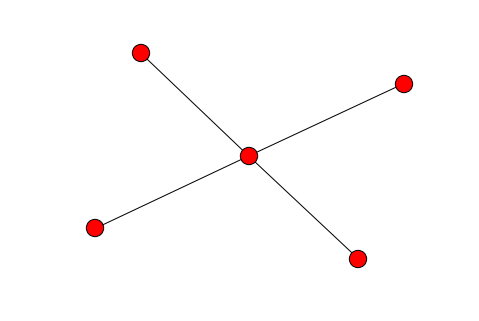


***********************
COMPONENT 0
***********************
Number of nodes  5
Number of edges  4
---
Top 3 nodes by degree centraliy in component 0
Gene: Degree Centrality   Degree
TP53 : 1.0 4
PTENloss : 0.25 1
ST5loss : 0.25 1
---
Writing nodes to:  output/BRCA_wustl-som-cna-gl-twohit-cpairs-min_cohort_filtered_network_comp0.txt


In [13]:
import networkx as nx
import csv

G=nx.Graph()
for pair in new_sig_c_dict:
    pair_type = new_sig_c_dict[pair]['Type']
    
    G.add_edge(tuple(pair)[0], tuple(pair)[1], {"Type": pair_type})

pos = nx.spring_layout(G)
nx.draw(G, pos)

# show graph
plt.show()

graphs = list(nx.connected_component_subgraphs(G))
graphs = sorted(graphs, key = lambda entry: entry.number_of_nodes(), reverse=True)

top_number = 3

for i in range(len(graphs)):
    print "\n***********************"
    print "COMPONENT " + str(i) 
    print "***********************"
    graph = graphs[i]
    print "Number of nodes ", graph.number_of_nodes()
    print "Number of edges ", graph.number_of_edges()
    
    node_items = [g + (graph.degree(g[0]),) for g in nx.degree_centrality(graph).items()]
    node_items = sorted(node_items, key=lambda entry: entry[1], reverse = True)
    

    print "---"
    print "Top", top_number, "nodes by degree centraliy in component", i
    print "Gene: Degree Centrality   Degree"
    for j in range(min(top_number, len(node_items))):
        print node_items[j][0], ":", np.round(node_items[j][1], 2), node_items[j][2]
    
    component_file = network_c_file[:-4] + "_comp" + str(i) + ".txt"
    
    print "---"
    print "Writing nodes to: ", component_file
    with open(component_file, 'w') as csvfile:
        writer = csv.writer(csvfile, delimiter='\t')
        writer.writerow(["Node", "Degreee Centrality", "Degree"])
        for node_item in node_items:
            writer.writerow(node_item)

## Search for triplets from among the pairs

In [14]:
# Search for triplets
import mutex_triangles as met
import edgereader as edg


        
    
    
# Search for triplets
import mutex_triangles as met
import edgereader as edg

genedict = edg.get_gene_dict(new_sig_dict)
Triplets, pairsdict_Triplets, sorted_pairs, genesdict_Triplets, sorted_genes = met.getTriplets(new_sig_dict, genedict, new_sig_dict, numCases, geneToCases=geneToCases, patientToGenes=patientToGenes)
Triplet_dict = met.sort_triplets_by_type(Triplets)

for t_type in Triplet_dict:
    print len(Triplet_dict[t_type]), " of type ",  t_type
    Triplet_dict[t_type] = sorted(Triplet_dict[t_type], key=lambda entry: entry.stats['Count'], reverse=True)
    triplet_file_name = triplet_output_prefix + t_type + '.txt'
    met.writeTriplets2(Triplet_dict[t_type], triplet_file_name)
    !python add_COSMIC.py -ic Gene0 Gene1 Gene2 -ip $COSMIC_triplet_insertion_index -i $triplet_file_name -o $triplet_file_name
    print "updated with COSMIC info ", triplet_file_name
    
    
    
    print "*********" + str(t_type) + "INFO**********\n"
    gene_t_dict = {}
    cyto_t_dict = {}
    cyto_trip_t_dict = {}
    
    
    # LEFT OFF HERE-JLU
    
    for triplet in Triplet_dict[t_type]:
        genes = triplet.genes
        suffixes = [gene[-4:] if gene[-4:] in {'loss', 'gain'} else "" for gene in genes]
        
        cytobands = set([str(bgbp.get_segment_gene_info(gene)['Cytobands']) for gene, suffix in zip(genes, suffixes)])
        
        for gene in genes:
            if gene not in gene_t_dict:
                gene_t_dict[gene] = set()
            gene_t_dict[gene].add(frozenset(genes.difference(set([gene]))))
    
        
        for cytoband in cytobands:
            if cytoband not in cyto_t_dict:
                cyto_t_dict[cytoband] = set()
            cyto_t_dict[cytoband].add(frozenset(cytobands.difference(set([cytoband]))))
    
        if frozenset(cytobands) not in cyto_trip_t_dict:
            cyto_trip_t_dict[frozenset(cytobands)] = set()
            
        cyto_trip_t_dict[frozenset(cytobands)].add(frozenset(genes))
    
    
    

    sorted_genes = sorted(gene_t_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
    sorted_cytobands = sorted(cyto_t_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
    sorted_cytotuples = sorted(cyto_trip_t_dict.items(), key = lambda entry: len(entry[1]), reverse=True)

    print "\n**********SINGLE GENES**********"
    print_length = 15
    for gene in sorted_genes:
        if len(gene[0]) <= print_length + 4:
            print gene[0], "has", len(gene[1])
        else:
            print gene[0][0:print_length] + gene[0][-4:], "has\t", len(gene[1])

    print "\n**********SINGLE CYTOBANDS**********"
    for cytoband in sorted_cytobands:
        print cytoband[0], "has", len(cytoband[1])

    print "\n**********TRIPLET CYTOBANDS**********"
    for cytotuple in sorted_cytotuples:
        print  cytotuple[0], "has", len(cytotuple[1])


    os.system('say "finished"')



number of pairs  4
Pair info of triplets initialized
0  triplets calculated in  0.000540018081665
Including sorting time  0.000613927841187


In [15]:
num_samples = 1000
pthresh = 0.05
num_permute = 100

mutationmatrix = '/Users/jlu96/maf/new/BRCA_wustl/BRCA_wustl-som-cna-gl.m2'
cancer_name = mutationmatrix.split("/")[-1][:-3]

weSME_folder = '/Users/jlu96/conte/wsampling/'
weSME_data_folder = '/Users/jlu96/conte/wsampling/data/' + cancer_name + '/'
weSME_file = weSME_data_folder + cancer_name + "-list.txt"
weSME_freq_file = weSME_data_folder + cancer_name + "-freqs.txt"
weSME_sampling_folder = weSME_data_folder + 'sampling/'
weSME_permute_folder = weSME_data_folder + 'permute/'
weSME_permute_prefix = weSME_permute_folder + "permute"
me_output = weSME_data_folder + "ME_" + str(pthresh) + ".txt"
co_output = weSME_data_folder + "CO_" + str(pthresh) + ".txt"
permute_me_output_prefix = weSME_permute_folder + "permute_output_ME_" + str(pthresh)
permute_co_output_prefix = weSME_permute_folder + "permute_output_CO_" + str(pthresh)
fdr_me_output = weSME_data_folder + "ME_FDR.txt"
fdr_co_output = weSME_data_folder + "CO_FDR.txt"
pv_fdr_me_output = weSME_data_folder + "pv_ME_FDR.txt"
pv_fdr_co_output = weSME_data_folder + "pv_CO_FDR.txt"



geneList1 = '/Users/jlu96/conte/jlu/mutex/data/tumor_suppressors_twohit_somatic.glst'

geneList2 = '/Users/jlu96/conte/jlu/mutex/data/tumor_suppressors_twohit_copy.glst'


comp_sample_weights = weSME_folder + 'comp_sample_weights.py'
comp_me_for_all_pairs = weSME_folder + 'comp_me_for_all_pairs.py'
comp_co_for_all_pairs = weSME_folder + 'comp_co_for_all_pairs.py'
comp_fdr = weSME_folder + 'comp_fdr.py'
run_permute_data = weSME_folder + 'run_permute_data.py'
run_weighted_sampling = weSME_folder + 'run_weighted_sampling.py'

In [16]:
filtered_mutationmatrix = "/Users/jlu96/maf/new/BRCA_wustl/BRCA_wustl-som-cna-gl-onlyshared.m2"
shared_patients_file = '/Users/jlu96/maf/new/BRCA_wustl/shared_patients.plst'

!python preprocessing/filter_matrix.py -i $mutationmatrix -p $shared_patients_file -o $filtered_mutationmatrix

Filtered matrix written to  /Users/jlu96/maf/new/BRCA_wustl/BRCA_wustl-som-cna-gl-onlyshared.m2


In [17]:
# convert the mutationmatirx to weSME format

!mkdir $weSME_data_folder
!python preprocessing/matrixToMut_list.py -i $filtered_mutationmatrix -o $weSME_file


mkdir: /Users/jlu96/conte/wsampling/data/BRCA_wustl-som-cna-gl/: File exists
WeSME mut_list written to  /Users/jlu96/conte/wsampling/data/BRCA_wustl-som-cna-gl/BRCA_wustl-som-cna-gl-list.txt


In [18]:
# sample

!python $comp_sample_weights $cancer_name $cancer_name -i $weSME_file -o $weSME_freq_file
!mkdir $weSME_sampling_folder

print "Making samples"
!time python $run_weighted_sampling $cancer_name $cancer_name $num_samples -m $weSME_file -f $weSME_freq_file -o $weSME_sampling_folder
!echo "Sampling written to " $weSME_sampling_folder

INFO:root:BRCA_wustl-som-cna-gl
mkdir: /Users/jlu96/conte/wsampling/data/BRCA_wustl-som-cna-gl/sampling/: File exists
Making samples
INFO:root:BRCA_wustl-som-cna-gl
INFO:root:for all observed k's

real	14m56.469s
user	14m3.439s
sys	0m14.929s
Sampling written to  /Users/jlu96/conte/wsampling/data/BRCA_wustl-som-cna-gl/sampling/


In [23]:
import os

# Get mutex + co-occurrence
# !time python $comp_me_for_all_pairs $cancer_name $cancer_name $pthresh -m $weSME_file -s $weSME_sampling_folder -o $me_output
# !echo "Mutex written to " $me_output
!time python $comp_co_for_all_pairs $cancer_name $cancer_name $pthresh -m $weSME_file -s $weSME_sampling_folder -o $co_output -gl1 $geneList1 -gl2 $geneList2
!echo "Cooccur written to " $co_output

os.system('Pairs completed"')

DEBUG:root:comp CO for BRCA_wustl-som-cna-gl, BRCA_wustl-som-cna-gl
gene list 1 is  /Users/jlu96/conte/jlu/mutex/data/tumor_suppressors_twohit_somatic.glst
gene list 2 is  /Users/jlu96/conte/jlu/mutex/data/tumor_suppressors_twohit_copy.glst
Gene1 is  set(['BRCA1', 'TP63', 'CDKN2A', 'TP53', 'DLD', 'PTEN', 'CDKN1B', 'SFRP1', 'RB1', 'SDHD', 'ST5', 'ST14', 'ST7', 'TP73', 'APC', 'SDHB', 'TSC2', 'TCF21', 'TSC1'])
Gene2 is  set(['ST5loss', 'PTENloss', 'APCloss', 'TSC1loss', 'SDHDloss', 'TP53loss', 'DLDloss', 'ST14loss', 'ST7loss', 'TP73loss', 'TCF21loss', 'TSC2loss', 'SDHBloss', 'TP63loss', 'BRCA1loss', 'CDKN2Aloss', 'CDKN1Bloss', 'SFRP1loss', 'RB1loss'])
Pairs list is  set([('APC', 'TSC1loss'), ('TSC2', 'TSC1loss'), ('DLD', 'TP63loss'), ('ST5', 'TCF21loss'), ('CDKN1B', 'TSC1loss'), ('PTEN', 'TSC2loss'), ('CDKN1B', 'SFRP1loss'), ('TP73', 'TCF21loss'), ('ST14', 'TSC2loss'), ('PTEN', 'ST14loss'), ('PTEN', 'TP73loss'), ('APC', 'SFRP1loss'), ('SDHB', 'DLDloss'), ('TCF21', 'TP73loss'), ('TP73', 'T

512